### This code runs the ML models using the data processed from data processing script

- Make sure the data is kept in appropriate paths as defined

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import os
from tqdm import tqdm
from itertools import combinations
import gc
from scipy.stats import variation

In [2]:
TrainPath = Path(r'C:\Users\EIAJRTW\OneDrive - Ericsson AB\Err Hackathon\Prob-7 NPS & KPI Correlation\Train')
TestPath = Path(r'C:\Users\EIAJRTW\OneDrive - Ericsson AB\Err Hackathon\Prob-7 NPS & KPI Correlation\Test')

In [3]:
KPI_tr = pd.read_csv(os.path.join(TrainPath,'kpi_data_to_share_train_raw.csv'))
KPI_te = pd.read_csv(os.path.join(TestPath,'kpi_data_to_share_test_raw.csv'))
# NPS_tr = pd.read_csv(os.path.join(TrainPath,'nps_data_to_share_train.csv'))

In [4]:
### function to reduce memory of dataframe ###
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in tqdm(df.columns):
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

KPI_tr = reduce_mem_usage(KPI_tr)
# NPS_tr  = reduce_mem_usage(NPS_tr)
KPI_te = reduce_mem_usage(KPI_te)
# NPS_te  = reduce_mem_usage(NPS_te)

100%|██████████| 14/14 [00:03<00:00,  4.56it/s]


Memory usage after optimization is: 322.65 MB
Decreased by 69.6%


100%|██████████| 14/14 [00:01<00:00, 12.76it/s]


Memory usage after optimization is: 99.31 MB
Decreased by 69.6%


In [5]:
NPS_tr = pd.read_csv('NPS_tr.csv')
NPS_te = pd.read_csv('NPS_te.csv')

In [6]:
del _;gc.collect()

20

In [7]:
### function to drop features with lower coeff of variance ###

def getLowVarianceCols(NPS,thresh=0.1):
    from scipy.stats import variation  
    drop = []
    for i in tqdm(NPS.columns[4:]):
        stat = variation(NPS[i]) ### coeff of variation rather than vanilla variance
        if stat < thresh:
            drop.append(i)
        elif NPS[i].nunique() == 1:
            drop.append(i)
    print("Total of {} columns will be dropped".format(len(drop)))
    return drop

drop = getLowVarianceCols(NPS_tr,0.05)
_ = NPS_tr.shape[1]
NPS_tr.drop(drop,1,inplace=True)
NPS_te.drop(drop,1,inplace=True)
print("Columns before: {} Columns After:{} ".format(_,NPS_tr.shape[1]))

  0%|          | 0/2517 [00:00<?, ?it/s]C:\Users\EIAJRTW\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1025: RuntimeWarning: invalid value encountered in double_scalars
  return a.std(axis) / a.mean(axis)
 48%|████▊     | 1202/2517 [00:00<00:00, 3989.44it/s]C:\Users\EIAJRTW\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
100%|██████████| 2517/2517 [00:00<00:00, 3654.72it/s]


Total of 994 columns will be dropped
Columns before: 2521 Columns After:1527 


In [8]:
pd.set_option('display.max_columns',1000)
NPS_tr.head()

region  cluster  month  nps_values  region_count  cluster_count  \
0       2        0      1        0.31       1736326           8798   
1       2        1      1        0.14       1736326          32255   
2       2        2      1        0.22       1736326          91203   
3       2        3      1        0.29       1736326          39919   
4       2        4      1        0.24       1736326          72009   

   month_count  region_cluster_count  region_month_count  cluster_month_count  \
0      1359345                  8798              234341                 1200   
1      1359345                 32255              234341                 4101   
2      1359345                 91203              234341                12438   
3      1359345                 39919              234341                 5236   
4      1359345                 72009              234341                 9900   

   cluster_kpi1_min  region_kpi1_max  cluster_kpi1_max  month_kpi1_max  \
0               0.0            185.2             100.0           184.9   
1               0.0            185.2             100.0           184.9   
2               0.0            185.2             100.0           184.9   
3               0.0            185.2             100.0           184.9   
4               0.0            185.2             100.0           184.9   

   region_kpi1_std  cluster_kpi1_std  month_kpi1_std  region_kpi1_kurt  \
0              9.1            24.000          12.055             109.9   
1              9.1             6.234          12.055             109.9   
2              9.1             6.297          12.055             109.9   
3              9.1             8.695          12.055             109.9   
4              9.1             9.210          12.055             109.9   

   cluster_kpi1_kurt  month_kpi1_kurt  region_kpi2_mean  cluster_kpi2_mean  \
0              11.28            60.72             4.867              3.660   
1             215.90            60.72             4.867              6.793   
2             218.60            60.72             4.867              5.062   
3             119.75            60.72             4.867              5.016   
4             109.50            60.72             4.867              4.695   

   month_kpi2_mean  region_kpi2_median  cluster_kpi2_median  \
0              4.4                3.97                 2.42   
1              4.4                3.97                 6.12   
2              4.4                3.97                 4.05   
3              4.4                3.97                 3.82   
4              4.4                3.97                 3.68   

   month_kpi2_median  cluster_kpi2_min  region_kpi2_max  cluster_kpi2_max  \
0                3.5               0.0            48.38             40.97   
1                3.5               0.0            48.38             36.50   
2                3.5               0.0            48.38             29.78   
3                3.5               0.0            48.38             29.60   
4                3.5               0.0            48.38             48.38   

   month_kpi2_max  region_kpi2_std  cluster_kpi2_std  region_kpi2_skew  \
0            40.3            3.998             3.668             1.095   
1            40.3            3.998             4.418             1.095   
2            40.3            3.998             4.062             1.095   
3            40.3            3.998             4.402             1.095   
4            40.3            3.998             4.070             1.095   

   cluster_kpi2_skew  region_kpi2_kurt  cluster_kpi2_kurt  month_kpi2_kurt  \
0              1.399             1.232             3.2200           1.8955   
1              0.745             1.232             0.4006           1.8955   
2              1.245             1.232             1.7930           1.8955   
3              1.317             1.232             1.8880           1.8955   
4              1.281             1.232             2.2290  

In [9]:
### repalce -inf and inf with nan values
NPS_tr = NPS_tr.replace([np.inf, -np.inf], np.nan)
NPS_te = NPS_te.replace([np.inf, -np.inf], np.nan)

In [10]:
## drop columns with lots of nulls 
NPS_tr.drop(list(NPS_tr.isnull().sum()[NPS_tr.isnull().sum()>500].index),1,inplace=True)
NPS_te.drop(list(NPS_tr.isnull().sum()[NPS_tr.isnull().sum()>500].index),1,inplace=True)

In [12]:
### Bin prep for stratification -- we bin the raw nps values and create k folds based on these 10 bins-- \
### for better representation of all data points
labels = ["nps_bin_{}".format(i) for i in range(10)]
NPS_tr['nps_bins']=pd.cut(NPS_tr['nps_values'],10,labels=labels)

In [13]:
### fn to generate end predictions if preds is already labels
def generatePreds(NPS,preds):
    _ = NPS[['region','cluster','month']]
    _['nps_values'] = preds
    return _

### Regression Appraoch - XgBoost

##### Tree parameters

In [14]:
MAX_TREE_DEPTH = 13
ITERATIONS = 10000
SUBSAMPLE = 0.5
REGULARIZATION = 0.1
GAMMA = 0.3
EARLY_STOP = 100
colsample_bytree = 0.5

params = {'tree_method': 'auto','booster':'gblinear', 'max_depth': MAX_TREE_DEPTH, 'alpha': REGULARIZATION,
          'gamma': GAMMA, 'subsample': SUBSAMPLE,'colsample_bytree':colsample_bytree, 'learning_rate': 0.008, 
          'silent': 1, 'objective':'reg:linear', 'eval_metric': ['rmse','mae'],'early_stopping_rounds':EARLY_STOP}

params = {'tree_method': 'auto','booster':'gblinear', 'max_depth': MAX_TREE_DEPTH, 'alpha': REGULARIZATION,
          'gamma': GAMMA, 'subsample': SUBSAMPLE,'colsample_bytree':colsample_bytree, 'learning_rate': 0.008, 
          'silent': 1, 'objective':'reg:linear', 'eval_metric': ['rmse','mae']}

##### 5 fold loop and savinf the out of folds for validation purposes

In [15]:
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from xgboost import XGBClassifier,XGBRegressor

NFOLDS = 5
kfold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=42)
drop_features = ['region','cluster','month','nps_bins','nps_values']
y = NPS_tr['nps_values']
X = NPS_tr.drop(drop_features,axis=1)
commonCols = [i for i in X.columns if i in NPS_te.columns]
X = X[commonCols]
test = NPS_te[commonCols]
feature_importance_df = pd.DataFrame()
oof = np.zeros_like(y)
preds = np.zeros(len(test))

for i,(tr_idx,val_idx) in enumerate(kfold.split(X, NPS_tr['nps_bins'])):
    print("Fold {}".format(i+1))
    X_tr, X_val, Y_tr, Y_val = X.loc[tr_idx,:], X.loc[val_idx,:], y[tr_idx], y[val_idx]
    bst  = XGBRegressor(max_depth=13, learning_rate=0.1, n_estimators=2000, n_jobs=4, verbosity=3, objective='reg:squarederror', booster='gblinear', 
                        tree_method='auto', gamma=0.3, subsample=0.5, colsample_bytree=0.5, colsample_bylevel=0.5,
                        reg_alpha=1, reg_lambda=1, random_state=42, importance_type='gain')
    bst.fit(X_tr,Y_tr,early_stopping_rounds=250, eval_set=[(X_tr,Y_tr),(X_val, Y_val)],eval_metric=['rmse','mae'] ,verbose=True)

    oof[val_idx] = bst.predict(X_val,ntree_limit = 0)
    
    preds += bst.predict(test,ntree_limit = 0)/NFOLDS

C:\Users\EIAJRTW\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Fold 1


C:\Users\EIAJRTW\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	validation_0-rmse:0.123171	validation_0-mae:0.095178
Multiple eval metrics have been passed: 'validation_0-mae' will be used for early stopping.

Will train until validation_0-mae hasn't improved in 250 rounds.
[1]	validation_0-rmse:0.12111	validation_0-mae:0.093256
[2]	validation_0-rmse:0.120151	validation_0-mae:0.092578
[3]	validation_0-rmse:0.119556	validation_0-mae:0.092136
[4]	validation_0-rmse:0.119124	validation_0-mae:0.091758
[5]	validation_0-rmse:0.118797	validation_0-mae:0.091433
[6]	validation_0-rmse:0.118537	validation_0-mae:0.091217
[7]	validation_0-rmse:0.1183	validation_0-mae:0.090959
[8]	validation_0-rmse:0.118098	validation_0-mae:0.090797
[9]	validation_0-rmse:0.117932	validation_0-mae:0.090658
[10]	validation_0-rmse:0.11779	validation_0-mae:0.090582
[11]	validation_0-rmse:0.117656	validation_0-mae:0.090439
[12]	validation_0-rmse:0.117537	validation_0-mae:0.090324
[13]	validation_0-rmse:0.117425	validation_0-mae:0.0902
[14]	validation_0-rmse:0.117323	validation_0-m

[139]	validation_0-rmse:0.115595	validation_0-mae:0.087754
[140]	validation_0-rmse:0.115592	validation_0-mae:0.08775
[141]	validation_0-rmse:0.115587	validation_0-mae:0.087745
[142]	validation_0-rmse:0.115584	validation_0-mae:0.087738
[143]	validation_0-rmse:0.115583	validation_0-mae:0.087738
[144]	validation_0-rmse:0.115578	validation_0-mae:0.087733
[145]	validation_0-rmse:0.115575	validation_0-mae:0.087727
[146]	validation_0-rmse:0.115571	validation_0-mae:0.087722
[147]	validation_0-rmse:0.115567	validation_0-mae:0.087717
[148]	validation_0-rmse:0.115565	validation_0-mae:0.087715
[149]	validation_0-rmse:0.115562	validation_0-mae:0.087709
[150]	validation_0-rmse:0.11556	validation_0-mae:0.087706
[151]	validation_0-rmse:0.115557	validation_0-mae:0.087702
[152]	validation_0-rmse:0.115555	validation_0-mae:0.087699
[153]	validation_0-rmse:0.115552	validation_0-mae:0.087695
[154]	validation_0-rmse:0.115549	validation_0-mae:0.087691
[155]	validation_0-rmse:0.115546	validation_0-mae:0.087688

[279]	validation_0-rmse:0.11548	validation_0-mae:0.087526
[280]	validation_0-rmse:0.11548	validation_0-mae:0.087527
[281]	validation_0-rmse:0.115481	validation_0-mae:0.087526
[282]	validation_0-rmse:0.115481	validation_0-mae:0.087527
[283]	validation_0-rmse:0.115481	validation_0-mae:0.087526
[284]	validation_0-rmse:0.115481	validation_0-mae:0.087528
[285]	validation_0-rmse:0.115481	validation_0-mae:0.087527
[286]	validation_0-rmse:0.115481	validation_0-mae:0.087527
[287]	validation_0-rmse:0.115481	validation_0-mae:0.087528
[288]	validation_0-rmse:0.115481	validation_0-mae:0.087527
[289]	validation_0-rmse:0.115482	validation_0-mae:0.087526
[290]	validation_0-rmse:0.115481	validation_0-mae:0.087527
[291]	validation_0-rmse:0.115482	validation_0-mae:0.087526
[292]	validation_0-rmse:0.115482	validation_0-mae:0.087527
[293]	validation_0-rmse:0.115482	validation_0-mae:0.087527
[294]	validation_0-rmse:0.115482	validation_0-mae:0.087528
[295]	validation_0-rmse:0.115482	validation_0-mae:0.087528

[419]	validation_0-rmse:0.115453	validation_0-mae:0.087513
[420]	validation_0-rmse:0.115453	validation_0-mae:0.087512
[421]	validation_0-rmse:0.115453	validation_0-mae:0.087512
[422]	validation_0-rmse:0.115453	validation_0-mae:0.087511
[423]	validation_0-rmse:0.115453	validation_0-mae:0.087512
[424]	validation_0-rmse:0.115452	validation_0-mae:0.087512
[425]	validation_0-rmse:0.115453	validation_0-mae:0.08751
[426]	validation_0-rmse:0.115453	validation_0-mae:0.087512
[427]	validation_0-rmse:0.115453	validation_0-mae:0.087512
[428]	validation_0-rmse:0.115453	validation_0-mae:0.087511
[429]	validation_0-rmse:0.115453	validation_0-mae:0.087512
[430]	validation_0-rmse:0.115453	validation_0-mae:0.087512
[431]	validation_0-rmse:0.115453	validation_0-mae:0.08751
[432]	validation_0-rmse:0.115453	validation_0-mae:0.087511
[433]	validation_0-rmse:0.115453	validation_0-mae:0.087511
[434]	validation_0-rmse:0.115453	validation_0-mae:0.087512
[435]	validation_0-rmse:0.115453	validation_0-mae:0.087512

[559]	validation_0-rmse:0.115451	validation_0-mae:0.087498
[560]	validation_0-rmse:0.115451	validation_0-mae:0.087499
[561]	validation_0-rmse:0.115451	validation_0-mae:0.087497
[562]	validation_0-rmse:0.115451	validation_0-mae:0.087498
[563]	validation_0-rmse:0.115451	validation_0-mae:0.087498
[564]	validation_0-rmse:0.115451	validation_0-mae:0.087498
[565]	validation_0-rmse:0.115451	validation_0-mae:0.087497
[566]	validation_0-rmse:0.115452	validation_0-mae:0.087498
[567]	validation_0-rmse:0.115452	validation_0-mae:0.087498
[568]	validation_0-rmse:0.115452	validation_0-mae:0.087497
[569]	validation_0-rmse:0.115452	validation_0-mae:0.087499
[570]	validation_0-rmse:0.115452	validation_0-mae:0.087499
[571]	validation_0-rmse:0.115452	validation_0-mae:0.087498
[572]	validation_0-rmse:0.115453	validation_0-mae:0.087498
[573]	validation_0-rmse:0.115453	validation_0-mae:0.087498
[574]	validation_0-rmse:0.115453	validation_0-mae:0.087498
[575]	validation_0-rmse:0.115453	validation_0-mae:0.0874

[699]	validation_0-rmse:0.115459	validation_0-mae:0.087478
[700]	validation_0-rmse:0.115459	validation_0-mae:0.087478
[701]	validation_0-rmse:0.115459	validation_0-mae:0.087478
[702]	validation_0-rmse:0.115459	validation_0-mae:0.087477
[703]	validation_0-rmse:0.115459	validation_0-mae:0.087477
[704]	validation_0-rmse:0.115459	validation_0-mae:0.087477
[705]	validation_0-rmse:0.115459	validation_0-mae:0.087476
[706]	validation_0-rmse:0.115459	validation_0-mae:0.087476
[707]	validation_0-rmse:0.115459	validation_0-mae:0.087475
[708]	validation_0-rmse:0.115459	validation_0-mae:0.087475
[709]	validation_0-rmse:0.11546	validation_0-mae:0.087475
[710]	validation_0-rmse:0.11546	validation_0-mae:0.087475
[711]	validation_0-rmse:0.11546	validation_0-mae:0.087474
[712]	validation_0-rmse:0.11546	validation_0-mae:0.087474
[713]	validation_0-rmse:0.11546	validation_0-mae:0.087474
[714]	validation_0-rmse:0.11546	validation_0-mae:0.087473
[715]	validation_0-rmse:0.115461	validation_0-mae:0.087473
[71

[839]	validation_0-rmse:0.115461	validation_0-mae:0.087447
[840]	validation_0-rmse:0.115461	validation_0-mae:0.087446
[841]	validation_0-rmse:0.115461	validation_0-mae:0.087446
[842]	validation_0-rmse:0.115461	validation_0-mae:0.087446
[843]	validation_0-rmse:0.115461	validation_0-mae:0.087446
[844]	validation_0-rmse:0.115461	validation_0-mae:0.087446
[845]	validation_0-rmse:0.115461	validation_0-mae:0.087446
[846]	validation_0-rmse:0.115461	validation_0-mae:0.087446
[847]	validation_0-rmse:0.115461	validation_0-mae:0.087446
[848]	validation_0-rmse:0.115461	validation_0-mae:0.087446
[849]	validation_0-rmse:0.115461	validation_0-mae:0.087446
[850]	validation_0-rmse:0.115461	validation_0-mae:0.087446
[851]	validation_0-rmse:0.115461	validation_0-mae:0.087445
[852]	validation_0-rmse:0.11546	validation_0-mae:0.087445
[853]	validation_0-rmse:0.115461	validation_0-mae:0.087445
[854]	validation_0-rmse:0.115461	validation_0-mae:0.087445
[855]	validation_0-rmse:0.115461	validation_0-mae:0.08744

[980]	validation_0-rmse:0.11546	validation_0-mae:0.087433
[981]	validation_0-rmse:0.11546	validation_0-mae:0.087433
[982]	validation_0-rmse:0.11546	validation_0-mae:0.087434
[983]	validation_0-rmse:0.11546	validation_0-mae:0.087434
[984]	validation_0-rmse:0.11546	validation_0-mae:0.087433
[985]	validation_0-rmse:0.11546	validation_0-mae:0.087434
[986]	validation_0-rmse:0.11546	validation_0-mae:0.087433
[987]	validation_0-rmse:0.11546	validation_0-mae:0.087433
[988]	validation_0-rmse:0.11546	validation_0-mae:0.087433
[989]	validation_0-rmse:0.11546	validation_0-mae:0.087433
[990]	validation_0-rmse:0.11546	validation_0-mae:0.087433
[991]	validation_0-rmse:0.11546	validation_0-mae:0.087433
[992]	validation_0-rmse:0.11546	validation_0-mae:0.087433
[993]	validation_0-rmse:0.11546	validation_0-mae:0.087432
[994]	validation_0-rmse:0.11546	validation_0-mae:0.087432
[995]	validation_0-rmse:0.11546	validation_0-mae:0.087432
[996]	validation_0-rmse:0.11546	validation_0-mae:0.087432
[997]	validati

[1118]	validation_0-rmse:0.115461	validation_0-mae:0.087437
[1119]	validation_0-rmse:0.115461	validation_0-mae:0.087438
[1120]	validation_0-rmse:0.115461	validation_0-mae:0.087439
[1121]	validation_0-rmse:0.115461	validation_0-mae:0.087438
[1122]	validation_0-rmse:0.115462	validation_0-mae:0.087438
[1123]	validation_0-rmse:0.115462	validation_0-mae:0.087439
[1124]	validation_0-rmse:0.115461	validation_0-mae:0.087439
[1125]	validation_0-rmse:0.115461	validation_0-mae:0.087439
[1126]	validation_0-rmse:0.115461	validation_0-mae:0.087439
[1127]	validation_0-rmse:0.115461	validation_0-mae:0.087439
[1128]	validation_0-rmse:0.115461	validation_0-mae:0.087438
[1129]	validation_0-rmse:0.115461	validation_0-mae:0.087439
[1130]	validation_0-rmse:0.115461	validation_0-mae:0.087439
[1131]	validation_0-rmse:0.115461	validation_0-mae:0.087439
[1132]	validation_0-rmse:0.115461	validation_0-mae:0.087439
[1133]	validation_0-rmse:0.115461	validation_0-mae:0.087439
[1134]	validation_0-rmse:0.115461	valida

[1256]	validation_0-rmse:0.115458	validation_0-mae:0.08745
[1257]	validation_0-rmse:0.115458	validation_0-mae:0.08745
[1258]	validation_0-rmse:0.115458	validation_0-mae:0.08745
Stopping. Best iteration:
[1008]	validation_0-rmse:0.11546	validation_0-mae:0.08743

Fold 2
[12:05:28] ======== Monitor: Learner ========
[12:05:28] EvalOneIter: 0.33321s, 1259 calls @ 264us
[12:05:28] GetGradient: 0.165469s, 1259 calls @ 131us
[12:05:28] PredictRaw: 0.0122961s, 1259 calls @ 9us
[12:05:28] UpdateOneIter: 28.6772s, 1259 calls @ 22777us
[12:05:28] ======== Monitor: GBLinear ========
[12:05:28] DoBoost: 28.4926s, 1259 calls @ 22631us
[12:05:28] PredictBatch: 0.0195046s, 2520 calls @ 7us
[12:05:28] PredictBatchInternal: 13.3054s, 2521 calls @ 5277us
[0]	validation_0-rmse:0.125064	validation_0-mae:0.094329
Multiple eval metrics have been passed: 'validation_0-mae' will be used for early stopping.

Will train until validation_0-mae hasn't improved in 250 rounds.
[1]	validation_0-rmse:0.12269	validatio

[126]	validation_0-rmse:0.118379	validation_0-mae:0.086389
[127]	validation_0-rmse:0.118372	validation_0-mae:0.086385
[128]	validation_0-rmse:0.118362	validation_0-mae:0.086382
[129]	validation_0-rmse:0.118355	validation_0-mae:0.086378
[130]	validation_0-rmse:0.118347	validation_0-mae:0.086375
[131]	validation_0-rmse:0.118342	validation_0-mae:0.086372
[132]	validation_0-rmse:0.118335	validation_0-mae:0.08637
[133]	validation_0-rmse:0.118328	validation_0-mae:0.086366
[134]	validation_0-rmse:0.118319	validation_0-mae:0.086363
[135]	validation_0-rmse:0.118312	validation_0-mae:0.086361
[136]	validation_0-rmse:0.118309	validation_0-mae:0.086358
[137]	validation_0-rmse:0.118302	validation_0-mae:0.086357
[138]	validation_0-rmse:0.118297	validation_0-mae:0.086354
[139]	validation_0-rmse:0.118291	validation_0-mae:0.086352
[140]	validation_0-rmse:0.118286	validation_0-mae:0.086348
[141]	validation_0-rmse:0.118279	validation_0-mae:0.086345
[142]	validation_0-rmse:0.118272	validation_0-mae:0.08634

[266]	validation_0-rmse:0.117773	validation_0-mae:0.086103
[267]	validation_0-rmse:0.11777	validation_0-mae:0.086102
[268]	validation_0-rmse:0.117767	validation_0-mae:0.0861
[269]	validation_0-rmse:0.117763	validation_0-mae:0.086098
[270]	validation_0-rmse:0.117761	validation_0-mae:0.086097
[271]	validation_0-rmse:0.117758	validation_0-mae:0.086096
[272]	validation_0-rmse:0.117755	validation_0-mae:0.086095
[273]	validation_0-rmse:0.117753	validation_0-mae:0.086093
[274]	validation_0-rmse:0.11775	validation_0-mae:0.086092
[275]	validation_0-rmse:0.117748	validation_0-mae:0.086092
[276]	validation_0-rmse:0.117745	validation_0-mae:0.08609
[277]	validation_0-rmse:0.117741	validation_0-mae:0.086089
[278]	validation_0-rmse:0.117738	validation_0-mae:0.086087
[279]	validation_0-rmse:0.117736	validation_0-mae:0.086085
[280]	validation_0-rmse:0.117732	validation_0-mae:0.086084
[281]	validation_0-rmse:0.117731	validation_0-mae:0.086084
[282]	validation_0-rmse:0.117728	validation_0-mae:0.086082
[2

[406]	validation_0-rmse:0.117499	validation_0-mae:0.085966
[407]	validation_0-rmse:0.117499	validation_0-mae:0.085965
[408]	validation_0-rmse:0.117497	validation_0-mae:0.085964
[409]	validation_0-rmse:0.117495	validation_0-mae:0.085963
[410]	validation_0-rmse:0.117494	validation_0-mae:0.085963
[411]	validation_0-rmse:0.117493	validation_0-mae:0.085962
[412]	validation_0-rmse:0.117491	validation_0-mae:0.085961
[413]	validation_0-rmse:0.11749	validation_0-mae:0.08596
[414]	validation_0-rmse:0.117489	validation_0-mae:0.08596
[415]	validation_0-rmse:0.117487	validation_0-mae:0.085959
[416]	validation_0-rmse:0.117486	validation_0-mae:0.085958
[417]	validation_0-rmse:0.117485	validation_0-mae:0.085958
[418]	validation_0-rmse:0.117485	validation_0-mae:0.085958
[419]	validation_0-rmse:0.117484	validation_0-mae:0.085957
[420]	validation_0-rmse:0.117484	validation_0-mae:0.085957
[421]	validation_0-rmse:0.117483	validation_0-mae:0.085956
[422]	validation_0-rmse:0.117481	validation_0-mae:0.085955


[546]	validation_0-rmse:0.117409	validation_0-mae:0.085924
[547]	validation_0-rmse:0.117409	validation_0-mae:0.085924
[548]	validation_0-rmse:0.117408	validation_0-mae:0.085924
[549]	validation_0-rmse:0.117408	validation_0-mae:0.085924
[550]	validation_0-rmse:0.117408	validation_0-mae:0.085925
[551]	validation_0-rmse:0.117408	validation_0-mae:0.085925
[552]	validation_0-rmse:0.117407	validation_0-mae:0.085924
[553]	validation_0-rmse:0.117407	validation_0-mae:0.085924
[554]	validation_0-rmse:0.117407	validation_0-mae:0.085924
[555]	validation_0-rmse:0.117406	validation_0-mae:0.085923
[556]	validation_0-rmse:0.117406	validation_0-mae:0.085923
[557]	validation_0-rmse:0.117405	validation_0-mae:0.085923
[558]	validation_0-rmse:0.117405	validation_0-mae:0.085923
[559]	validation_0-rmse:0.117405	validation_0-mae:0.085923
[560]	validation_0-rmse:0.117404	validation_0-mae:0.085922
[561]	validation_0-rmse:0.117404	validation_0-mae:0.085922
[562]	validation_0-rmse:0.117403	validation_0-mae:0.0859

[686]	validation_0-rmse:0.117355	validation_0-mae:0.085888
[687]	validation_0-rmse:0.117355	validation_0-mae:0.085887
[688]	validation_0-rmse:0.117355	validation_0-mae:0.085887
[689]	validation_0-rmse:0.117355	validation_0-mae:0.085887
[690]	validation_0-rmse:0.117354	validation_0-mae:0.085886
[691]	validation_0-rmse:0.117354	validation_0-mae:0.085886
[692]	validation_0-rmse:0.117353	validation_0-mae:0.085886
[693]	validation_0-rmse:0.117353	validation_0-mae:0.085886
[694]	validation_0-rmse:0.117353	validation_0-mae:0.085885
[695]	validation_0-rmse:0.117353	validation_0-mae:0.085885
[696]	validation_0-rmse:0.117353	validation_0-mae:0.085885
[697]	validation_0-rmse:0.117352	validation_0-mae:0.085884
[698]	validation_0-rmse:0.117352	validation_0-mae:0.085884
[699]	validation_0-rmse:0.117352	validation_0-mae:0.085884
[700]	validation_0-rmse:0.117352	validation_0-mae:0.085884
[701]	validation_0-rmse:0.117351	validation_0-mae:0.085883
[702]	validation_0-rmse:0.117351	validation_0-mae:0.0858

[826]	validation_0-rmse:0.117315	validation_0-mae:0.085843
[827]	validation_0-rmse:0.117315	validation_0-mae:0.085843
[828]	validation_0-rmse:0.117315	validation_0-mae:0.085843
[829]	validation_0-rmse:0.117315	validation_0-mae:0.085842
[830]	validation_0-rmse:0.117315	validation_0-mae:0.085842
[831]	validation_0-rmse:0.117314	validation_0-mae:0.085842
[832]	validation_0-rmse:0.117314	validation_0-mae:0.085842
[833]	validation_0-rmse:0.117314	validation_0-mae:0.085841
[834]	validation_0-rmse:0.117314	validation_0-mae:0.085841
[835]	validation_0-rmse:0.117314	validation_0-mae:0.085841
[836]	validation_0-rmse:0.117313	validation_0-mae:0.08584
[837]	validation_0-rmse:0.117313	validation_0-mae:0.08584
[838]	validation_0-rmse:0.117313	validation_0-mae:0.08584
[839]	validation_0-rmse:0.117313	validation_0-mae:0.08584
[840]	validation_0-rmse:0.117313	validation_0-mae:0.085839
[841]	validation_0-rmse:0.117312	validation_0-mae:0.085839
[842]	validation_0-rmse:0.117312	validation_0-mae:0.085839
[

[966]	validation_0-rmse:0.117276	validation_0-mae:0.085794
[967]	validation_0-rmse:0.117276	validation_0-mae:0.085794
[968]	validation_0-rmse:0.117276	validation_0-mae:0.085794
[969]	validation_0-rmse:0.117276	validation_0-mae:0.085794
[970]	validation_0-rmse:0.117275	validation_0-mae:0.085793
[971]	validation_0-rmse:0.117275	validation_0-mae:0.085793
[972]	validation_0-rmse:0.117274	validation_0-mae:0.085792
[973]	validation_0-rmse:0.117275	validation_0-mae:0.085792
[974]	validation_0-rmse:0.117274	validation_0-mae:0.085792
[975]	validation_0-rmse:0.117274	validation_0-mae:0.085791
[976]	validation_0-rmse:0.117273	validation_0-mae:0.085791
[977]	validation_0-rmse:0.117273	validation_0-mae:0.08579
[978]	validation_0-rmse:0.117272	validation_0-mae:0.08579
[979]	validation_0-rmse:0.117272	validation_0-mae:0.085789
[980]	validation_0-rmse:0.117272	validation_0-mae:0.085789
[981]	validation_0-rmse:0.117271	validation_0-mae:0.085789
[982]	validation_0-rmse:0.11727	validation_0-mae:0.085788


[1104]	validation_0-rmse:0.11724	validation_0-mae:0.085758
[1105]	validation_0-rmse:0.11724	validation_0-mae:0.085758
[1106]	validation_0-rmse:0.11724	validation_0-mae:0.085758
[1107]	validation_0-rmse:0.117239	validation_0-mae:0.085757
[1108]	validation_0-rmse:0.117239	validation_0-mae:0.085757
[1109]	validation_0-rmse:0.117239	validation_0-mae:0.085757
[1110]	validation_0-rmse:0.117239	validation_0-mae:0.085757
[1111]	validation_0-rmse:0.117239	validation_0-mae:0.085757
[1112]	validation_0-rmse:0.117239	validation_0-mae:0.085757
[1113]	validation_0-rmse:0.117239	validation_0-mae:0.085756
[1114]	validation_0-rmse:0.117238	validation_0-mae:0.085756
[1115]	validation_0-rmse:0.117238	validation_0-mae:0.085756
[1116]	validation_0-rmse:0.117238	validation_0-mae:0.085756
[1117]	validation_0-rmse:0.117238	validation_0-mae:0.085756
[1118]	validation_0-rmse:0.117238	validation_0-mae:0.085755
[1119]	validation_0-rmse:0.117237	validation_0-mae:0.085755
[1120]	validation_0-rmse:0.117237	validatio

[1242]	validation_0-rmse:0.117216	validation_0-mae:0.085728
[1243]	validation_0-rmse:0.117216	validation_0-mae:0.085728
[1244]	validation_0-rmse:0.117215	validation_0-mae:0.085728
[1245]	validation_0-rmse:0.117215	validation_0-mae:0.085728
[1246]	validation_0-rmse:0.117215	validation_0-mae:0.085728
[1247]	validation_0-rmse:0.117216	validation_0-mae:0.085728
[1248]	validation_0-rmse:0.117215	validation_0-mae:0.085727
[1249]	validation_0-rmse:0.117215	validation_0-mae:0.085727
[1250]	validation_0-rmse:0.117215	validation_0-mae:0.085727
[1251]	validation_0-rmse:0.117215	validation_0-mae:0.085727
[1252]	validation_0-rmse:0.117215	validation_0-mae:0.085727
[1253]	validation_0-rmse:0.117215	validation_0-mae:0.085726
[1254]	validation_0-rmse:0.117215	validation_0-mae:0.085726
[1255]	validation_0-rmse:0.117214	validation_0-mae:0.085726
[1256]	validation_0-rmse:0.117214	validation_0-mae:0.085725
[1257]	validation_0-rmse:0.117215	validation_0-mae:0.085726
[1258]	validation_0-rmse:0.117214	valida

[1379]	validation_0-rmse:0.117204	validation_0-mae:0.085706
[1380]	validation_0-rmse:0.117204	validation_0-mae:0.085706
[1381]	validation_0-rmse:0.117203	validation_0-mae:0.085705
[1382]	validation_0-rmse:0.117203	validation_0-mae:0.085705
[1383]	validation_0-rmse:0.117203	validation_0-mae:0.085705
[1384]	validation_0-rmse:0.117203	validation_0-mae:0.085705
[1385]	validation_0-rmse:0.117203	validation_0-mae:0.085705
[1386]	validation_0-rmse:0.117203	validation_0-mae:0.085705
[1387]	validation_0-rmse:0.117203	validation_0-mae:0.085705
[1388]	validation_0-rmse:0.117203	validation_0-mae:0.085705
[1389]	validation_0-rmse:0.117203	validation_0-mae:0.085705
[1390]	validation_0-rmse:0.117203	validation_0-mae:0.085705
[1391]	validation_0-rmse:0.117202	validation_0-mae:0.085704
[1392]	validation_0-rmse:0.117202	validation_0-mae:0.085704
[1393]	validation_0-rmse:0.117202	validation_0-mae:0.085704
[1394]	validation_0-rmse:0.117202	validation_0-mae:0.085703
[1395]	validation_0-rmse:0.117201	valida

[1517]	validation_0-rmse:0.117189	validation_0-mae:0.085688
[1518]	validation_0-rmse:0.117189	validation_0-mae:0.085688
[1519]	validation_0-rmse:0.117189	validation_0-mae:0.085688
[1520]	validation_0-rmse:0.117189	validation_0-mae:0.085688
[1521]	validation_0-rmse:0.117189	validation_0-mae:0.085687
[1522]	validation_0-rmse:0.117188	validation_0-mae:0.085687
[1523]	validation_0-rmse:0.117188	validation_0-mae:0.085687
[1524]	validation_0-rmse:0.117189	validation_0-mae:0.085687
[1525]	validation_0-rmse:0.117189	validation_0-mae:0.085687
[1526]	validation_0-rmse:0.117188	validation_0-mae:0.085687
[1527]	validation_0-rmse:0.117189	validation_0-mae:0.085687
[1528]	validation_0-rmse:0.117188	validation_0-mae:0.085687
[1529]	validation_0-rmse:0.117188	validation_0-mae:0.085687
[1530]	validation_0-rmse:0.117188	validation_0-mae:0.085686
[1531]	validation_0-rmse:0.117188	validation_0-mae:0.085687
[1532]	validation_0-rmse:0.117188	validation_0-mae:0.085686
[1533]	validation_0-rmse:0.117188	valida

[1654]	validation_0-rmse:0.117174	validation_0-mae:0.085671
[1655]	validation_0-rmse:0.117174	validation_0-mae:0.085671
[1656]	validation_0-rmse:0.117173	validation_0-mae:0.085671
[1657]	validation_0-rmse:0.117174	validation_0-mae:0.085671
[1658]	validation_0-rmse:0.117174	validation_0-mae:0.085671
[1659]	validation_0-rmse:0.117174	validation_0-mae:0.085671
[1660]	validation_0-rmse:0.117173	validation_0-mae:0.085671
[1661]	validation_0-rmse:0.117173	validation_0-mae:0.08567
[1662]	validation_0-rmse:0.117173	validation_0-mae:0.08567
[1663]	validation_0-rmse:0.117173	validation_0-mae:0.08567
[1664]	validation_0-rmse:0.117173	validation_0-mae:0.08567
[1665]	validation_0-rmse:0.117173	validation_0-mae:0.08567
[1666]	validation_0-rmse:0.117174	validation_0-mae:0.08567
[1667]	validation_0-rmse:0.117173	validation_0-mae:0.08567
[1668]	validation_0-rmse:0.117173	validation_0-mae:0.08567
[1669]	validation_0-rmse:0.117173	validation_0-mae:0.08567
[1670]	validation_0-rmse:0.117173	validation_0-ma

[1791]	validation_0-rmse:0.117163	validation_0-mae:0.085653
[1792]	validation_0-rmse:0.117163	validation_0-mae:0.085653
[1793]	validation_0-rmse:0.117163	validation_0-mae:0.085653
[1794]	validation_0-rmse:0.117163	validation_0-mae:0.085653
[1795]	validation_0-rmse:0.117163	validation_0-mae:0.085653
[1796]	validation_0-rmse:0.117162	validation_0-mae:0.085653
[1797]	validation_0-rmse:0.117162	validation_0-mae:0.085652
[1798]	validation_0-rmse:0.117162	validation_0-mae:0.085652
[1799]	validation_0-rmse:0.117162	validation_0-mae:0.085652
[1800]	validation_0-rmse:0.117162	validation_0-mae:0.085652
[1801]	validation_0-rmse:0.117162	validation_0-mae:0.085652
[1802]	validation_0-rmse:0.117162	validation_0-mae:0.085652
[1803]	validation_0-rmse:0.117162	validation_0-mae:0.085652
[1804]	validation_0-rmse:0.117161	validation_0-mae:0.085651
[1805]	validation_0-rmse:0.117162	validation_0-mae:0.085651
[1806]	validation_0-rmse:0.117161	validation_0-mae:0.085651
[1807]	validation_0-rmse:0.117161	valida

[1929]	validation_0-rmse:0.117147	validation_0-mae:0.085637
[1930]	validation_0-rmse:0.117146	validation_0-mae:0.085637
[1931]	validation_0-rmse:0.117147	validation_0-mae:0.085637
[1932]	validation_0-rmse:0.117147	validation_0-mae:0.085637
[1933]	validation_0-rmse:0.117146	validation_0-mae:0.085636
[1934]	validation_0-rmse:0.117146	validation_0-mae:0.085636
[1935]	validation_0-rmse:0.117146	validation_0-mae:0.085636
[1936]	validation_0-rmse:0.117146	validation_0-mae:0.085636
[1937]	validation_0-rmse:0.117146	validation_0-mae:0.085636
[1938]	validation_0-rmse:0.117146	validation_0-mae:0.085636
[1939]	validation_0-rmse:0.117146	validation_0-mae:0.085635
[1940]	validation_0-rmse:0.117146	validation_0-mae:0.085635
[1941]	validation_0-rmse:0.117145	validation_0-mae:0.085635
[1942]	validation_0-rmse:0.117145	validation_0-mae:0.085635
[1943]	validation_0-rmse:0.117145	validation_0-mae:0.085634
[1944]	validation_0-rmse:0.117145	validation_0-mae:0.085634
[1945]	validation_0-rmse:0.117145	valida

[58]	validation_0-rmse:0.115701	validation_0-mae:0.086899
[59]	validation_0-rmse:0.115695	validation_0-mae:0.086899
[60]	validation_0-rmse:0.115688	validation_0-mae:0.086897
[61]	validation_0-rmse:0.115679	validation_0-mae:0.086891
[62]	validation_0-rmse:0.115677	validation_0-mae:0.086898
[63]	validation_0-rmse:0.115667	validation_0-mae:0.08689
[64]	validation_0-rmse:0.115667	validation_0-mae:0.086897
[65]	validation_0-rmse:0.11566	validation_0-mae:0.086891
[66]	validation_0-rmse:0.115657	validation_0-mae:0.086893
[67]	validation_0-rmse:0.115653	validation_0-mae:0.086894
[68]	validation_0-rmse:0.115644	validation_0-mae:0.086886
[69]	validation_0-rmse:0.11564	validation_0-mae:0.086889
[70]	validation_0-rmse:0.115634	validation_0-mae:0.086884
[71]	validation_0-rmse:0.115632	validation_0-mae:0.086888
[72]	validation_0-rmse:0.115627	validation_0-mae:0.086883
[73]	validation_0-rmse:0.115624	validation_0-mae:0.086884
[74]	validation_0-rmse:0.115615	validation_0-mae:0.086875
[75]	validation_0

[199]	validation_0-rmse:0.115436	validation_0-mae:0.087127
[200]	validation_0-rmse:0.115435	validation_0-mae:0.087126
[201]	validation_0-rmse:0.115435	validation_0-mae:0.087127
[202]	validation_0-rmse:0.115435	validation_0-mae:0.087127
[203]	validation_0-rmse:0.115434	validation_0-mae:0.087127
[204]	validation_0-rmse:0.115433	validation_0-mae:0.087128
[205]	validation_0-rmse:0.115432	validation_0-mae:0.087128
[206]	validation_0-rmse:0.115432	validation_0-mae:0.087129
[207]	validation_0-rmse:0.115431	validation_0-mae:0.087129
[208]	validation_0-rmse:0.115431	validation_0-mae:0.087129
[209]	validation_0-rmse:0.115431	validation_0-mae:0.08713
[210]	validation_0-rmse:0.115431	validation_0-mae:0.087131
[211]	validation_0-rmse:0.11543	validation_0-mae:0.087131
[212]	validation_0-rmse:0.115429	validation_0-mae:0.087132
[213]	validation_0-rmse:0.115428	validation_0-mae:0.087132
[214]	validation_0-rmse:0.115428	validation_0-mae:0.087134
[215]	validation_0-rmse:0.115427	validation_0-mae:0.087134

[1]	validation_0-rmse:0.145595	validation_0-mae:0.095021
[2]	validation_0-rmse:0.144531	validation_0-mae:0.093881
[3]	validation_0-rmse:0.143755	validation_0-mae:0.093032
[4]	validation_0-rmse:0.143167	validation_0-mae:0.092375
[5]	validation_0-rmse:0.142678	validation_0-mae:0.091811
[6]	validation_0-rmse:0.142267	validation_0-mae:0.091293
[7]	validation_0-rmse:0.141916	validation_0-mae:0.090848
[8]	validation_0-rmse:0.141618	validation_0-mae:0.090469
[9]	validation_0-rmse:0.141367	validation_0-mae:0.090145
[10]	validation_0-rmse:0.141145	validation_0-mae:0.089864
[11]	validation_0-rmse:0.140959	validation_0-mae:0.089608
[12]	validation_0-rmse:0.140784	validation_0-mae:0.08941
[13]	validation_0-rmse:0.140641	validation_0-mae:0.089224
[14]	validation_0-rmse:0.140511	validation_0-mae:0.089051
[15]	validation_0-rmse:0.140399	validation_0-mae:0.088906
[16]	validation_0-rmse:0.140306	validation_0-mae:0.088778
[17]	validation_0-rmse:0.140211	validation_0-mae:0.088662
[18]	validation_0-rmse:0

[143]	validation_0-rmse:0.13852	validation_0-mae:0.086922
[144]	validation_0-rmse:0.138519	validation_0-mae:0.086918
[145]	validation_0-rmse:0.138515	validation_0-mae:0.086914
[146]	validation_0-rmse:0.138512	validation_0-mae:0.086911
[147]	validation_0-rmse:0.13851	validation_0-mae:0.086908
[148]	validation_0-rmse:0.138508	validation_0-mae:0.086904
[149]	validation_0-rmse:0.138505	validation_0-mae:0.0869
[150]	validation_0-rmse:0.138504	validation_0-mae:0.086896
[151]	validation_0-rmse:0.138502	validation_0-mae:0.086893
[152]	validation_0-rmse:0.138501	validation_0-mae:0.08689
[153]	validation_0-rmse:0.1385	validation_0-mae:0.086887
[154]	validation_0-rmse:0.138498	validation_0-mae:0.086883
[155]	validation_0-rmse:0.138496	validation_0-mae:0.08688
[156]	validation_0-rmse:0.138493	validation_0-mae:0.086875
[157]	validation_0-rmse:0.138491	validation_0-mae:0.086872
[158]	validation_0-rmse:0.138489	validation_0-mae:0.086868
[159]	validation_0-rmse:0.138487	validation_0-mae:0.086864
[160]

[283]	validation_0-rmse:0.138491	validation_0-mae:0.086601
[284]	validation_0-rmse:0.138492	validation_0-mae:0.0866
[285]	validation_0-rmse:0.138493	validation_0-mae:0.086599
[286]	validation_0-rmse:0.138495	validation_0-mae:0.086599
[287]	validation_0-rmse:0.138496	validation_0-mae:0.086598
[288]	validation_0-rmse:0.138497	validation_0-mae:0.086597
[289]	validation_0-rmse:0.138498	validation_0-mae:0.086596
[290]	validation_0-rmse:0.138498	validation_0-mae:0.086594
[291]	validation_0-rmse:0.138498	validation_0-mae:0.086593
[292]	validation_0-rmse:0.138499	validation_0-mae:0.086591
[293]	validation_0-rmse:0.1385	validation_0-mae:0.08659
[294]	validation_0-rmse:0.1385	validation_0-mae:0.086588
[295]	validation_0-rmse:0.138501	validation_0-mae:0.086587
[296]	validation_0-rmse:0.138501	validation_0-mae:0.086585
[297]	validation_0-rmse:0.138502	validation_0-mae:0.086584
[298]	validation_0-rmse:0.138503	validation_0-mae:0.086582
[299]	validation_0-rmse:0.138503	validation_0-mae:0.086581
[300

[423]	validation_0-rmse:0.138561	validation_0-mae:0.086493
[424]	validation_0-rmse:0.138562	validation_0-mae:0.086492
[425]	validation_0-rmse:0.138562	validation_0-mae:0.086492
[426]	validation_0-rmse:0.138562	validation_0-mae:0.086491
[427]	validation_0-rmse:0.138563	validation_0-mae:0.086492
[428]	validation_0-rmse:0.138564	validation_0-mae:0.086492
[429]	validation_0-rmse:0.138565	validation_0-mae:0.086492
[430]	validation_0-rmse:0.138565	validation_0-mae:0.086492
[431]	validation_0-rmse:0.138565	validation_0-mae:0.086492
[432]	validation_0-rmse:0.138566	validation_0-mae:0.086493
[433]	validation_0-rmse:0.138566	validation_0-mae:0.086493
[434]	validation_0-rmse:0.138567	validation_0-mae:0.086493
[435]	validation_0-rmse:0.138567	validation_0-mae:0.086493
[436]	validation_0-rmse:0.138568	validation_0-mae:0.086493
[437]	validation_0-rmse:0.138568	validation_0-mae:0.086493
[438]	validation_0-rmse:0.138569	validation_0-mae:0.086493
[439]	validation_0-rmse:0.13857	validation_0-mae:0.08649

[563]	validation_0-rmse:0.138625	validation_0-mae:0.086513
[564]	validation_0-rmse:0.138626	validation_0-mae:0.086513
[565]	validation_0-rmse:0.138626	validation_0-mae:0.086513
[566]	validation_0-rmse:0.138626	validation_0-mae:0.086513
[567]	validation_0-rmse:0.138626	validation_0-mae:0.086513
[568]	validation_0-rmse:0.138627	validation_0-mae:0.086513
[569]	validation_0-rmse:0.138627	validation_0-mae:0.086513
[570]	validation_0-rmse:0.138627	validation_0-mae:0.086513
[571]	validation_0-rmse:0.138628	validation_0-mae:0.086513
[572]	validation_0-rmse:0.138628	validation_0-mae:0.086513
[573]	validation_0-rmse:0.138628	validation_0-mae:0.086513
[574]	validation_0-rmse:0.138628	validation_0-mae:0.086513
[575]	validation_0-rmse:0.138628	validation_0-mae:0.086513
[576]	validation_0-rmse:0.138628	validation_0-mae:0.086513
[577]	validation_0-rmse:0.138628	validation_0-mae:0.086513
[578]	validation_0-rmse:0.138629	validation_0-mae:0.086514
[579]	validation_0-rmse:0.138629	validation_0-mae:0.0865

[14]	validation_0-rmse:0.114719	validation_0-mae:0.08948
[15]	validation_0-rmse:0.114609	validation_0-mae:0.089389
[16]	validation_0-rmse:0.114502	validation_0-mae:0.089297
[17]	validation_0-rmse:0.114388	validation_0-mae:0.089194
[18]	validation_0-rmse:0.114279	validation_0-mae:0.089099
[19]	validation_0-rmse:0.114177	validation_0-mae:0.088998
[20]	validation_0-rmse:0.114074	validation_0-mae:0.088907
[21]	validation_0-rmse:0.113985	validation_0-mae:0.088821
[22]	validation_0-rmse:0.113891	validation_0-mae:0.088729
[23]	validation_0-rmse:0.113807	validation_0-mae:0.08864
[24]	validation_0-rmse:0.11372	validation_0-mae:0.08855
[25]	validation_0-rmse:0.113631	validation_0-mae:0.088461
[26]	validation_0-rmse:0.113548	validation_0-mae:0.088372
[27]	validation_0-rmse:0.113474	validation_0-mae:0.088291
[28]	validation_0-rmse:0.113402	validation_0-mae:0.088214
[29]	validation_0-rmse:0.113328	validation_0-mae:0.088131
[30]	validation_0-rmse:0.113251	validation_0-mae:0.088048
[31]	validation_0-

[155]	validation_0-rmse:0.110161	validation_0-mae:0.085019
[156]	validation_0-rmse:0.110155	validation_0-mae:0.085013
[157]	validation_0-rmse:0.110148	validation_0-mae:0.085004
[158]	validation_0-rmse:0.110141	validation_0-mae:0.084997
[159]	validation_0-rmse:0.110135	validation_0-mae:0.084991
[160]	validation_0-rmse:0.11013	validation_0-mae:0.084984
[161]	validation_0-rmse:0.110122	validation_0-mae:0.084976
[162]	validation_0-rmse:0.110117	validation_0-mae:0.08497
[163]	validation_0-rmse:0.110112	validation_0-mae:0.084964
[164]	validation_0-rmse:0.110107	validation_0-mae:0.084959
[165]	validation_0-rmse:0.110102	validation_0-mae:0.084955
[166]	validation_0-rmse:0.110096	validation_0-mae:0.084948
[167]	validation_0-rmse:0.110091	validation_0-mae:0.084942
[168]	validation_0-rmse:0.110085	validation_0-mae:0.084937
[169]	validation_0-rmse:0.11008	validation_0-mae:0.084932
[170]	validation_0-rmse:0.110076	validation_0-mae:0.084927
[171]	validation_0-rmse:0.110071	validation_0-mae:0.084922


[295]	validation_0-rmse:0.109801	validation_0-mae:0.084584
[296]	validation_0-rmse:0.1098	validation_0-mae:0.084582
[297]	validation_0-rmse:0.109799	validation_0-mae:0.08458
[298]	validation_0-rmse:0.109798	validation_0-mae:0.084579
[299]	validation_0-rmse:0.109797	validation_0-mae:0.084577
[300]	validation_0-rmse:0.109795	validation_0-mae:0.084575
[301]	validation_0-rmse:0.109793	validation_0-mae:0.084573
[302]	validation_0-rmse:0.109792	validation_0-mae:0.084571
[303]	validation_0-rmse:0.109791	validation_0-mae:0.084569
[304]	validation_0-rmse:0.10979	validation_0-mae:0.084568
[305]	validation_0-rmse:0.109788	validation_0-mae:0.084566
[306]	validation_0-rmse:0.109787	validation_0-mae:0.084565
[307]	validation_0-rmse:0.109786	validation_0-mae:0.084564
[308]	validation_0-rmse:0.109786	validation_0-mae:0.084562
[309]	validation_0-rmse:0.109785	validation_0-mae:0.08456
[310]	validation_0-rmse:0.109785	validation_0-mae:0.08456
[311]	validation_0-rmse:0.109784	validation_0-mae:0.084558
[31

[435]	validation_0-rmse:0.10975	validation_0-mae:0.084404
[436]	validation_0-rmse:0.109751	validation_0-mae:0.084403
[437]	validation_0-rmse:0.109752	validation_0-mae:0.084403
[438]	validation_0-rmse:0.109752	validation_0-mae:0.084403
[439]	validation_0-rmse:0.109753	validation_0-mae:0.084402
[440]	validation_0-rmse:0.109754	validation_0-mae:0.084402
[441]	validation_0-rmse:0.109755	validation_0-mae:0.084401
[442]	validation_0-rmse:0.109756	validation_0-mae:0.084402
[443]	validation_0-rmse:0.109757	validation_0-mae:0.084402
[444]	validation_0-rmse:0.109758	validation_0-mae:0.084401
[445]	validation_0-rmse:0.109759	validation_0-mae:0.084401
[446]	validation_0-rmse:0.10976	validation_0-mae:0.084401
[447]	validation_0-rmse:0.109761	validation_0-mae:0.084401
[448]	validation_0-rmse:0.109761	validation_0-mae:0.084401
[449]	validation_0-rmse:0.109762	validation_0-mae:0.084401
[450]	validation_0-rmse:0.109762	validation_0-mae:0.0844
[451]	validation_0-rmse:0.109763	validation_0-mae:0.0844
[45

[575]	validation_0-rmse:0.109839	validation_0-mae:0.084377
[576]	validation_0-rmse:0.10984	validation_0-mae:0.084376
[577]	validation_0-rmse:0.109841	validation_0-mae:0.084376
[578]	validation_0-rmse:0.109841	validation_0-mae:0.084376
[579]	validation_0-rmse:0.109841	validation_0-mae:0.084375
[580]	validation_0-rmse:0.109842	validation_0-mae:0.084375
[581]	validation_0-rmse:0.109842	validation_0-mae:0.084374
[582]	validation_0-rmse:0.109843	validation_0-mae:0.084374
[583]	validation_0-rmse:0.109844	validation_0-mae:0.084374
[584]	validation_0-rmse:0.109844	validation_0-mae:0.084374
[585]	validation_0-rmse:0.109845	validation_0-mae:0.084373
[586]	validation_0-rmse:0.109845	validation_0-mae:0.084373
[587]	validation_0-rmse:0.109846	validation_0-mae:0.084373
[588]	validation_0-rmse:0.109847	validation_0-mae:0.084372
[589]	validation_0-rmse:0.109847	validation_0-mae:0.084372
[590]	validation_0-rmse:0.109848	validation_0-mae:0.084372
[591]	validation_0-rmse:0.109848	validation_0-mae:0.08437

[715]	validation_0-rmse:0.109913	validation_0-mae:0.084336
[716]	validation_0-rmse:0.109913	validation_0-mae:0.084335
[717]	validation_0-rmse:0.109913	validation_0-mae:0.084335
[718]	validation_0-rmse:0.109914	validation_0-mae:0.084335
[719]	validation_0-rmse:0.109915	validation_0-mae:0.084334
[720]	validation_0-rmse:0.109915	validation_0-mae:0.084333
[721]	validation_0-rmse:0.109916	validation_0-mae:0.084333
[722]	validation_0-rmse:0.109916	validation_0-mae:0.084333
[723]	validation_0-rmse:0.109916	validation_0-mae:0.084332
[724]	validation_0-rmse:0.109917	validation_0-mae:0.084332
[725]	validation_0-rmse:0.109918	validation_0-mae:0.084332
[726]	validation_0-rmse:0.109918	validation_0-mae:0.084332
[727]	validation_0-rmse:0.109919	validation_0-mae:0.084332
[728]	validation_0-rmse:0.10992	validation_0-mae:0.084331
[729]	validation_0-rmse:0.10992	validation_0-mae:0.084331
[730]	validation_0-rmse:0.109921	validation_0-mae:0.084331
[731]	validation_0-rmse:0.109921	validation_0-mae:0.084331

[855]	validation_0-rmse:0.109981	validation_0-mae:0.084315
[856]	validation_0-rmse:0.109982	validation_0-mae:0.084315
[857]	validation_0-rmse:0.109982	validation_0-mae:0.084315
[858]	validation_0-rmse:0.109983	validation_0-mae:0.084315
[859]	validation_0-rmse:0.109984	validation_0-mae:0.084315
[860]	validation_0-rmse:0.109984	validation_0-mae:0.084315
[861]	validation_0-rmse:0.109985	validation_0-mae:0.084315
[862]	validation_0-rmse:0.109986	validation_0-mae:0.084315
[863]	validation_0-rmse:0.109987	validation_0-mae:0.084315
[864]	validation_0-rmse:0.109988	validation_0-mae:0.084315
[865]	validation_0-rmse:0.109989	validation_0-mae:0.084316
[866]	validation_0-rmse:0.10999	validation_0-mae:0.084316
[867]	validation_0-rmse:0.109992	validation_0-mae:0.084316
[868]	validation_0-rmse:0.109992	validation_0-mae:0.084316
[869]	validation_0-rmse:0.109993	validation_0-mae:0.084316
[870]	validation_0-rmse:0.109994	validation_0-mae:0.084316
[871]	validation_0-rmse:0.109994	validation_0-mae:0.08431

[995]	validation_0-rmse:0.110118	validation_0-mae:0.084322
[996]	validation_0-rmse:0.110118	validation_0-mae:0.084321
[997]	validation_0-rmse:0.110118	validation_0-mae:0.084321
[998]	validation_0-rmse:0.110119	validation_0-mae:0.084321
[999]	validation_0-rmse:0.110121	validation_0-mae:0.084322
[1000]	validation_0-rmse:0.110121	validation_0-mae:0.084321
[1001]	validation_0-rmse:0.110122	validation_0-mae:0.084322
[1002]	validation_0-rmse:0.110124	validation_0-mae:0.084322
[1003]	validation_0-rmse:0.110125	validation_0-mae:0.084322
[1004]	validation_0-rmse:0.110126	validation_0-mae:0.084322
[1005]	validation_0-rmse:0.110127	validation_0-mae:0.084322
[1006]	validation_0-rmse:0.110128	validation_0-mae:0.084322
[1007]	validation_0-rmse:0.110129	validation_0-mae:0.084322
[1008]	validation_0-rmse:0.110129	validation_0-mae:0.084323
[1009]	validation_0-rmse:0.11013	validation_0-mae:0.084322
[1010]	validation_0-rmse:0.110131	validation_0-mae:0.084322
[1011]	validation_0-rmse:0.110132	validation_0

In [19]:
from sklearn.metrics import mean_squared_error
from math import sqrt

print("Final RMSE:{}".format(sqrt(mean_squared_error(y, oof))))
print("Final MAE:{}".format(mean_squared_error(y, oof)))

Final RMSE:0.11979589245837713
Final MAE:0.014351055849899057


''

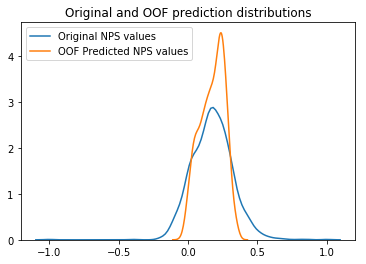

In [17]:
sns.kdeplot(y,label="Original NPS values")
sns.kdeplot(oof,label="OOF Predicted NPS values")
plt.title("Original and OOF prediction distributions")
;

In [ ]:
def getBins(preds):
    _ = preds.copy()
    _[preds<=0.1] = 1
    _[preds>0.1] = 0
    return _

### Regressor does not do too well on this --> we will shift to classifier 

### XgBoost - Classifier

In [28]:
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from xgboost import XGBClassifier,XGBRegressor

NFOLDS = 5
kfold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=42)
drop_features = ['region','cluster','month','nps_bins','nps_values']
y = NPS_tr['nps_values']
X = NPS_tr.drop(drop_features,axis=1)
commonCols = [i for i in X.columns if i in NPS_te.columns]
X = X[commonCols]
test = NPS_te[commonCols]
feature_importance_df = pd.DataFrame()
oof = np.zeros_like(y)
preds = np.zeros(len(test))

y = getBins(y)

for i,(tr_idx,val_idx) in enumerate(kfold.split(X, y)):
    print("Fold {}".format(i+1))
    X_tr, X_val, Y_tr, Y_val = X.loc[tr_idx,:], X.loc[val_idx,:], y[tr_idx], y[val_idx]
    bst  = XGBClassifier(max_depth=13, learning_rate=0.008, n_estimators=2000, n_jobs=4,verbosity=1, objective='binary:logistic', booster='gbtree', 
                        tree_method='auto', gamma=0.3, subsample=0.5, colsample_bytree=0.5, colsample_bylevel=0.5,
                        reg_alpha=1.75, reg_lambda=1, random_state=42, importance_type='gain')
    bst.fit(X_tr,Y_tr,early_stopping_rounds=250, eval_set=[(X_tr,Y_tr),(X_val, Y_val)],eval_metric = ['logloss','auc'] ,verbose=True)

    oof[val_idx] = bst.predict_proba(X_val)[:,1]
    
    preds += (bst.predict_proba(test)[:,1])/NFOLDS

Fold 1
[0]	validation_0-logloss:0.689483	validation_0-auc:0.850922	validation_1-logloss:0.689561	validation_1-auc:0.817372
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 250 rounds.
[1]	validation_0-logloss:0.685741	validation_0-auc:0.883018	validation_1-logloss:0.685921	validation_1-auc:0.849885
[2]	validation_0-logloss:0.682098	validation_0-auc:0.889073	validation_1-logloss:0.682515	validation_1-auc:0.854728
[3]	validation_0-logloss:0.678578	validation_0-auc:0.891778	validation_1-logloss:0.678878	validation_1-auc:0.859462
[4]	validation_0-logloss:0.675014	validation_0-auc:0.892759	validation_1-logloss:0.67554	validation_1-auc:0.859332
[5]	validation_0-logloss:0.671557	validation_0-auc:0.896708	validation_1-logloss:0.672009	validation_1-auc:0.865947
[6]	validation_0-logloss:0.668204	validation_0-auc:0.897206	validation_1-logloss:0.668881	validation_1-auc:0.865213
[7]	validation_0-logloss

[69]	validation_0-logloss:0.516866	validation_0-auc:0.916439	validation_1-logloss:0.523478	validation_1-auc:0.891673
[70]	validation_0-logloss:0.515207	validation_0-auc:0.916556	validation_1-logloss:0.521832	validation_1-auc:0.891586
[71]	validation_0-logloss:0.513643	validation_0-auc:0.916204	validation_1-logloss:0.520312	validation_1-auc:0.891802
[72]	validation_0-logloss:0.512074	validation_0-auc:0.916135	validation_1-logloss:0.518878	validation_1-auc:0.89124
[73]	validation_0-logloss:0.510392	validation_0-auc:0.916407	validation_1-logloss:0.517422	validation_1-auc:0.891024
[74]	validation_0-logloss:0.508873	validation_0-auc:0.916301	validation_1-logloss:0.515975	validation_1-auc:0.890981
[75]	validation_0-logloss:0.507415	validation_0-auc:0.916352	validation_1-logloss:0.514585	validation_1-auc:0.891111
[76]	validation_0-logloss:0.50588	validation_0-auc:0.916646	validation_1-logloss:0.513196	validation_1-auc:0.891932
[77]	validation_0-logloss:0.504152	validation_0-auc:0.91715	valida

[140]	validation_0-logloss:0.426844	validation_0-auc:0.927819	validation_1-logloss:0.444146	validation_1-auc:0.893035
[141]	validation_0-logloss:0.425962	validation_0-auc:0.927996	validation_1-logloss:0.443624	validation_1-auc:0.892602
[142]	validation_0-logloss:0.42496	validation_0-auc:0.928051	validation_1-logloss:0.442725	validation_1-auc:0.892429
[143]	validation_0-logloss:0.424063	validation_0-auc:0.928149	validation_1-logloss:0.441892	validation_1-auc:0.893078
[144]	validation_0-logloss:0.423233	validation_0-auc:0.928342	validation_1-logloss:0.441338	validation_1-auc:0.892862
[145]	validation_0-logloss:0.422349	validation_0-auc:0.928249	validation_1-logloss:0.44043	validation_1-auc:0.892689
[146]	validation_0-logloss:0.421388	validation_0-auc:0.928529	validation_1-logloss:0.439909	validation_1-auc:0.89204
[147]	validation_0-logloss:0.420404	validation_0-auc:0.928674	validation_1-logloss:0.439123	validation_1-auc:0.892473
[148]	validation_0-logloss:0.419443	validation_0-auc:0.9288

[210]	validation_0-logloss:0.373311	validation_0-auc:0.937369	validation_1-logloss:0.405975	validation_1-auc:0.89083
[211]	validation_0-logloss:0.372782	validation_0-auc:0.937407	validation_1-logloss:0.405526	validation_1-auc:0.8907
[212]	validation_0-logloss:0.37214	validation_0-auc:0.937544	validation_1-logloss:0.405027	validation_1-auc:0.890959
[213]	validation_0-logloss:0.37154	validation_0-auc:0.937726	validation_1-logloss:0.404813	validation_1-auc:0.890873
[214]	validation_0-logloss:0.37088	validation_0-auc:0.93806	validation_1-logloss:0.404729	validation_1-auc:0.890397
[215]	validation_0-logloss:0.370241	validation_0-auc:0.93827	validation_1-logloss:0.404382	validation_1-auc:0.890786
[216]	validation_0-logloss:0.369577	validation_0-auc:0.93846	validation_1-logloss:0.404155	validation_1-auc:0.890527
[217]	validation_0-logloss:0.369043	validation_0-auc:0.938556	validation_1-logloss:0.403615	validation_1-auc:0.890613
[218]	validation_0-logloss:0.368442	validation_0-auc:0.938681	val

[280]	validation_0-logloss:0.337958	validation_0-auc:0.945197	validation_1-logloss:0.38949	validation_1-auc:0.886722
[281]	validation_0-logloss:0.337636	validation_0-auc:0.945257	validation_1-logloss:0.389294	validation_1-auc:0.886766
[282]	validation_0-logloss:0.337258	validation_0-auc:0.94532	validation_1-logloss:0.389127	validation_1-auc:0.886852
[283]	validation_0-logloss:0.336868	validation_0-auc:0.945369	validation_1-logloss:0.388993	validation_1-auc:0.886766
[284]	validation_0-logloss:0.336456	validation_0-auc:0.945369	validation_1-logloss:0.388762	validation_1-auc:0.886809
[285]	validation_0-logloss:0.335985	validation_0-auc:0.945439	validation_1-logloss:0.388566	validation_1-auc:0.886809
[286]	validation_0-logloss:0.335615	validation_0-auc:0.945521	validation_1-logloss:0.388475	validation_1-auc:0.886549
[287]	validation_0-logloss:0.335192	validation_0-auc:0.945646	validation_1-logloss:0.38833	validation_1-auc:0.886376
[288]	validation_0-logloss:0.334781	validation_0-auc:0.9456

[350]	validation_0-logloss:0.312207	validation_0-auc:0.951341	validation_1-logloss:0.382371	validation_1-auc:0.885036
[351]	validation_0-logloss:0.311932	validation_0-auc:0.951376	validation_1-logloss:0.382196	validation_1-auc:0.885123
[352]	validation_0-logloss:0.311596	validation_0-auc:0.951469	validation_1-logloss:0.382108	validation_1-auc:0.885036
[353]	validation_0-logloss:0.311259	validation_0-auc:0.951512	validation_1-logloss:0.382013	validation_1-auc:0.885166
[354]	validation_0-logloss:0.310919	validation_0-auc:0.951583	validation_1-logloss:0.382073	validation_1-auc:0.88495
[355]	validation_0-logloss:0.310582	validation_0-auc:0.951654	validation_1-logloss:0.382109	validation_1-auc:0.88495
[356]	validation_0-logloss:0.310266	validation_0-auc:0.951708	validation_1-logloss:0.38192	validation_1-auc:0.885036
[357]	validation_0-logloss:0.310079	validation_0-auc:0.951776	validation_1-logloss:0.381979	validation_1-auc:0.884733
[358]	validation_0-logloss:0.309761	validation_0-auc:0.9518

[54]	validation_0-logloss:0.536035	validation_0-auc:0.92321	validation_1-logloss:0.573676	validation_1-auc:0.829208
[55]	validation_0-logloss:0.534003	validation_0-auc:0.923148	validation_1-logloss:0.572345	validation_1-auc:0.829165
[56]	validation_0-logloss:0.531934	validation_0-auc:0.923327	validation_1-logloss:0.570679	validation_1-auc:0.829946
[57]	validation_0-logloss:0.529851	validation_0-auc:0.923249	validation_1-logloss:0.569109	validation_1-auc:0.829686
[58]	validation_0-logloss:0.528018	validation_0-auc:0.923309	validation_1-logloss:0.567954	validation_1-auc:0.828991
[59]	validation_0-logloss:0.526197	validation_0-auc:0.923176	validation_1-logloss:0.566424	validation_1-auc:0.829251
[60]	validation_0-logloss:0.524272	validation_0-auc:0.923269	validation_1-logloss:0.565026	validation_1-auc:0.829642
[61]	validation_0-logloss:0.522437	validation_0-auc:0.923464	validation_1-logloss:0.563468	validation_1-auc:0.830641
[62]	validation_0-logloss:0.520532	validation_0-auc:0.923644	vali

[125]	validation_0-logloss:0.428957	validation_0-auc:0.933454	validation_1-logloss:0.49932	validation_1-auc:0.831879
[126]	validation_0-logloss:0.427842	validation_0-auc:0.933456	validation_1-logloss:0.498582	validation_1-auc:0.831835
[127]	validation_0-logloss:0.426721	validation_0-auc:0.933568	validation_1-logloss:0.497744	validation_1-auc:0.832009
[128]	validation_0-logloss:0.425586	validation_0-auc:0.933535	validation_1-logloss:0.497137	validation_1-auc:0.831748
[129]	validation_0-logloss:0.424573	validation_0-auc:0.933842	validation_1-logloss:0.496756	validation_1-auc:0.831227
[130]	validation_0-logloss:0.423558	validation_0-auc:0.933946	validation_1-logloss:0.49609	validation_1-auc:0.831184
[131]	validation_0-logloss:0.422554	validation_0-auc:0.934117	validation_1-logloss:0.495586	validation_1-auc:0.831466
[132]	validation_0-logloss:0.421462	validation_0-auc:0.934255	validation_1-logloss:0.494968	validation_1-auc:0.831205
[133]	validation_0-logloss:0.420462	validation_0-auc:0.934

[195]	validation_0-logloss:0.369384	validation_0-auc:0.940498	validation_1-logloss:0.466576	validation_1-auc:0.834332
[196]	validation_0-logloss:0.368769	validation_0-auc:0.940436	validation_1-logloss:0.466266	validation_1-auc:0.834549
[197]	validation_0-logloss:0.368138	validation_0-auc:0.940528	validation_1-logloss:0.466078	validation_1-auc:0.834289
[198]	validation_0-logloss:0.36761	validation_0-auc:0.940634	validation_1-logloss:0.465815	validation_1-auc:0.834376
[199]	validation_0-logloss:0.367014	validation_0-auc:0.940702	validation_1-logloss:0.465294	validation_1-auc:0.834897
[200]	validation_0-logloss:0.36637	validation_0-auc:0.940925	validation_1-logloss:0.465013	validation_1-auc:0.83481
[201]	validation_0-logloss:0.365749	validation_0-auc:0.940966	validation_1-logloss:0.464706	validation_1-auc:0.834723
[202]	validation_0-logloss:0.365095	validation_0-auc:0.941189	validation_1-logloss:0.46444	validation_1-auc:0.83468
[203]	validation_0-logloss:0.364417	validation_0-auc:0.94127	

[265]	validation_0-logloss:0.331161	validation_0-auc:0.947652	validation_1-logloss:0.453019	validation_1-auc:0.834897
[266]	validation_0-logloss:0.330747	validation_0-auc:0.947692	validation_1-logloss:0.453074	validation_1-auc:0.834853
[267]	validation_0-logloss:0.330283	validation_0-auc:0.94788	validation_1-logloss:0.453042	validation_1-auc:0.834766
[268]	validation_0-logloss:0.329857	validation_0-auc:0.947981	validation_1-logloss:0.452741	validation_1-auc:0.834897
[269]	validation_0-logloss:0.329303	validation_0-auc:0.948184	validation_1-logloss:0.452396	validation_1-auc:0.835505
[270]	validation_0-logloss:0.328925	validation_0-auc:0.94822	validation_1-logloss:0.452268	validation_1-auc:0.83494
[271]	validation_0-logloss:0.328554	validation_0-auc:0.948282	validation_1-logloss:0.451878	validation_1-auc:0.835201
[272]	validation_0-logloss:0.328082	validation_0-auc:0.948391	validation_1-logloss:0.451707	validation_1-auc:0.835157
[273]	validation_0-logloss:0.327584	validation_0-auc:0.9484

[335]	validation_0-logloss:0.304746	validation_0-auc:0.953112	validation_1-logloss:0.447559	validation_1-auc:0.834897
[336]	validation_0-logloss:0.304411	validation_0-auc:0.953299	validation_1-logloss:0.44735	validation_1-auc:0.835244
[337]	validation_0-logloss:0.304032	validation_0-auc:0.953354	validation_1-logloss:0.447473	validation_1-auc:0.835157
[338]	validation_0-logloss:0.303766	validation_0-auc:0.953305	validation_1-logloss:0.447393	validation_1-auc:0.835374
[339]	validation_0-logloss:0.303506	validation_0-auc:0.953335	validation_1-logloss:0.447472	validation_1-auc:0.834984
[340]	validation_0-logloss:0.303234	validation_0-auc:0.953348	validation_1-logloss:0.447442	validation_1-auc:0.83481
[341]	validation_0-logloss:0.30289	validation_0-auc:0.953416	validation_1-logloss:0.447677	validation_1-auc:0.834636
[342]	validation_0-logloss:0.302594	validation_0-auc:0.95353	validation_1-logloss:0.44781	validation_1-auc:0.834636
[343]	validation_0-logloss:0.302321	validation_0-auc:0.953525

[405]	validation_0-logloss:0.284358	validation_0-auc:0.958349	validation_1-logloss:0.44572	validation_1-auc:0.83646
[406]	validation_0-logloss:0.284127	validation_0-auc:0.958349	validation_1-logloss:0.445672	validation_1-auc:0.83646
[407]	validation_0-logloss:0.283865	validation_0-auc:0.958463	validation_1-logloss:0.445632	validation_1-auc:0.836417
[408]	validation_0-logloss:0.28358	validation_0-auc:0.958531	validation_1-logloss:0.445758	validation_1-auc:0.836417
[409]	validation_0-logloss:0.28334	validation_0-auc:0.958594	validation_1-logloss:0.445775	validation_1-auc:0.836199
[410]	validation_0-logloss:0.283042	validation_0-auc:0.958634	validation_1-logloss:0.445856	validation_1-auc:0.836113
[411]	validation_0-logloss:0.282778	validation_0-auc:0.958716	validation_1-logloss:0.445679	validation_1-auc:0.836547
[412]	validation_0-logloss:0.282484	validation_0-auc:0.958852	validation_1-logloss:0.445651	validation_1-auc:0.83659
[413]	validation_0-logloss:0.282235	validation_0-auc:0.958855	

[475]	validation_0-logloss:0.268484	validation_0-auc:0.962605	validation_1-logloss:0.446459	validation_1-auc:0.837025
[476]	validation_0-logloss:0.268326	validation_0-auc:0.962651	validation_1-logloss:0.446574	validation_1-auc:0.837285
[477]	validation_0-logloss:0.268096	validation_0-auc:0.962695	validation_1-logloss:0.446644	validation_1-auc:0.837068
[478]	validation_0-logloss:0.267901	validation_0-auc:0.962744	validation_1-logloss:0.44684	validation_1-auc:0.837068
[479]	validation_0-logloss:0.267611	validation_0-auc:0.962899	validation_1-logloss:0.446737	validation_1-auc:0.837242
[480]	validation_0-logloss:0.267437	validation_0-auc:0.962885	validation_1-logloss:0.446616	validation_1-auc:0.837285
[481]	validation_0-logloss:0.267122	validation_0-auc:0.963005	validation_1-logloss:0.446552	validation_1-auc:0.837589
[482]	validation_0-logloss:0.266878	validation_0-auc:0.963032	validation_1-logloss:0.446598	validation_1-auc:0.837242
[483]	validation_0-logloss:0.266647	validation_0-auc:0.96

[545]	validation_0-logloss:0.255056	validation_0-auc:0.96659	validation_1-logloss:0.448786	validation_1-auc:0.837893
[546]	validation_0-logloss:0.254922	validation_0-auc:0.966636	validation_1-logloss:0.44878	validation_1-auc:0.837936
[547]	validation_0-logloss:0.254762	validation_0-auc:0.966666	validation_1-logloss:0.448874	validation_1-auc:0.837806
[548]	validation_0-logloss:0.254593	validation_0-auc:0.966717	validation_1-logloss:0.448761	validation_1-auc:0.837806
[549]	validation_0-logloss:0.254338	validation_0-auc:0.966897	validation_1-logloss:0.448836	validation_1-auc:0.837893
[550]	validation_0-logloss:0.254225	validation_0-auc:0.96697	validation_1-logloss:0.448972	validation_1-auc:0.837676
[551]	validation_0-logloss:0.254054	validation_0-auc:0.966965	validation_1-logloss:0.449004	validation_1-auc:0.837589
[552]	validation_0-logloss:0.253878	validation_0-auc:0.966986	validation_1-logloss:0.449032	validation_1-auc:0.837763
[553]	validation_0-logloss:0.253748	validation_0-auc:0.9670

[615]	validation_0-logloss:0.24379	validation_0-auc:0.970234	validation_1-logloss:0.451804	validation_1-auc:0.83785
[616]	validation_0-logloss:0.243663	validation_0-auc:0.970264	validation_1-logloss:0.451712	validation_1-auc:0.837719
[617]	validation_0-logloss:0.243528	validation_0-auc:0.970286	validation_1-logloss:0.451627	validation_1-auc:0.837893
[618]	validation_0-logloss:0.243386	validation_0-auc:0.97034	validation_1-logloss:0.451708	validation_1-auc:0.837936
[619]	validation_0-logloss:0.243232	validation_0-auc:0.970389	validation_1-logloss:0.45186	validation_1-auc:0.837632
[620]	validation_0-logloss:0.243026	validation_0-auc:0.97043	validation_1-logloss:0.451911	validation_1-auc:0.837502
[621]	validation_0-logloss:0.242879	validation_0-auc:0.970476	validation_1-logloss:0.452091	validation_1-auc:0.837459
[622]	validation_0-logloss:0.242706	validation_0-auc:0.970555	validation_1-logloss:0.452187	validation_1-auc:0.837372
[623]	validation_0-logloss:0.242491	validation_0-auc:0.970596

[685]	validation_0-logloss:0.233762	validation_0-auc:0.973235	validation_1-logloss:0.454344	validation_1-auc:0.837328
[686]	validation_0-logloss:0.233636	validation_0-auc:0.973265	validation_1-logloss:0.454369	validation_1-auc:0.837328
[687]	validation_0-logloss:0.233565	validation_0-auc:0.973284	validation_1-logloss:0.454288	validation_1-auc:0.837719
[688]	validation_0-logloss:0.233468	validation_0-auc:0.973314	validation_1-logloss:0.454216	validation_1-auc:0.83798
[689]	validation_0-logloss:0.233298	validation_0-auc:0.973362	validation_1-logloss:0.454214	validation_1-auc:0.83785
[690]	validation_0-logloss:0.233201	validation_0-auc:0.97339	validation_1-logloss:0.454266	validation_1-auc:0.837936
[691]	validation_0-logloss:0.233093	validation_0-auc:0.973428	validation_1-logloss:0.454249	validation_1-auc:0.837806
[692]	validation_0-logloss:0.232948	validation_0-auc:0.973487	validation_1-logloss:0.45444	validation_1-auc:0.837632
[693]	validation_0-logloss:0.232809	validation_0-auc:0.97353

[755]	validation_0-logloss:0.224527	validation_0-auc:0.976129	validation_1-logloss:0.457531	validation_1-auc:0.837546
[756]	validation_0-logloss:0.224411	validation_0-auc:0.976159	validation_1-logloss:0.457538	validation_1-auc:0.837459
[757]	validation_0-logloss:0.224223	validation_0-auc:0.976257	validation_1-logloss:0.457443	validation_1-auc:0.837719
[758]	validation_0-logloss:0.224131	validation_0-auc:0.976292	validation_1-logloss:0.457403	validation_1-auc:0.83798
[759]	validation_0-logloss:0.224004	validation_0-auc:0.976371	validation_1-logloss:0.457496	validation_1-auc:0.837719
[760]	validation_0-logloss:0.223908	validation_0-auc:0.97645	validation_1-logloss:0.457514	validation_1-auc:0.837763
[761]	validation_0-logloss:0.223833	validation_0-auc:0.976412	validation_1-logloss:0.457679	validation_1-auc:0.837719
[762]	validation_0-logloss:0.223733	validation_0-auc:0.976483	validation_1-logloss:0.457851	validation_1-auc:0.837502
[763]	validation_0-logloss:0.223559	validation_0-auc:0.976

[36]	validation_0-logloss:0.580352	validation_0-auc:0.91524	validation_1-logloss:0.594957	validation_1-auc:0.857782
[37]	validation_0-logloss:0.577924	validation_0-auc:0.915358	validation_1-logloss:0.592746	validation_1-auc:0.858129
[38]	validation_0-logloss:0.575445	validation_0-auc:0.916174	validation_1-logloss:0.590797	validation_1-auc:0.857304
[39]	validation_0-logloss:0.572941	validation_0-auc:0.916356	validation_1-logloss:0.588547	validation_1-auc:0.858042
[40]	validation_0-logloss:0.570631	validation_0-auc:0.916902	validation_1-logloss:0.586498	validation_1-auc:0.859171
[41]	validation_0-logloss:0.568392	validation_0-auc:0.917861	validation_1-logloss:0.584589	validation_1-auc:0.858998
[42]	validation_0-logloss:0.566063	validation_0-auc:0.917976	validation_1-logloss:0.582832	validation_1-auc:0.858607
[43]	validation_0-logloss:0.563815	validation_0-auc:0.91801	validation_1-logloss:0.580603	validation_1-auc:0.859475
[44]	validation_0-logloss:0.56149	validation_0-auc:0.918082	valida

[107]	validation_0-logloss:0.455755	validation_0-auc:0.927921	validation_1-logloss:0.493847	validation_1-auc:0.866141
[108]	validation_0-logloss:0.454432	validation_0-auc:0.928153	validation_1-logloss:0.492793	validation_1-auc:0.866402
[109]	validation_0-logloss:0.45316	validation_0-auc:0.928239	validation_1-logloss:0.491854	validation_1-auc:0.866141
[110]	validation_0-logloss:0.452093	validation_0-auc:0.928212	validation_1-logloss:0.491027	validation_1-auc:0.866054
[111]	validation_0-logloss:0.451091	validation_0-auc:0.928114	validation_1-logloss:0.490342	validation_1-auc:0.866228
[112]	validation_0-logloss:0.449923	validation_0-auc:0.927989	validation_1-logloss:0.489404	validation_1-auc:0.866358
[113]	validation_0-logloss:0.448771	validation_0-auc:0.928158	validation_1-logloss:0.488568	validation_1-auc:0.866163
[114]	validation_0-logloss:0.4475	validation_0-auc:0.928302	validation_1-logloss:0.487818	validation_1-auc:0.865968
[115]	validation_0-logloss:0.446365	validation_0-auc:0.9284

[177]	validation_0-logloss:0.388562	validation_0-auc:0.936579	validation_1-logloss:0.446262	validation_1-auc:0.870158
[178]	validation_0-logloss:0.387848	validation_0-auc:0.936576	validation_1-logloss:0.44579	validation_1-auc:0.870071
[179]	validation_0-logloss:0.387168	validation_0-auc:0.93662	validation_1-logloss:0.445422	validation_1-auc:0.870288
[180]	validation_0-logloss:0.386478	validation_0-auc:0.936555	validation_1-logloss:0.444911	validation_1-auc:0.870201
[181]	validation_0-logloss:0.38573	validation_0-auc:0.936631	validation_1-logloss:0.444549	validation_1-auc:0.870201
[182]	validation_0-logloss:0.385003	validation_0-auc:0.936726	validation_1-logloss:0.44393	validation_1-auc:0.870375
[183]	validation_0-logloss:0.384413	validation_0-auc:0.936772	validation_1-logloss:0.443306	validation_1-auc:0.870375
[184]	validation_0-logloss:0.383684	validation_0-auc:0.936919	validation_1-logloss:0.442849	validation_1-auc:0.870375
[185]	validation_0-logloss:0.382903	validation_0-auc:0.93711

[247]	validation_0-logloss:0.347014	validation_0-auc:0.943283	validation_1-logloss:0.421963	validation_1-auc:0.873328
[248]	validation_0-logloss:0.346443	validation_0-auc:0.943337	validation_1-logloss:0.421803	validation_1-auc:0.873024
[249]	validation_0-logloss:0.346009	validation_0-auc:0.943298	validation_1-logloss:0.421503	validation_1-auc:0.873068
[250]	validation_0-logloss:0.345439	validation_0-auc:0.943499	validation_1-logloss:0.421344	validation_1-auc:0.873198
[251]	validation_0-logloss:0.344971	validation_0-auc:0.943692	validation_1-logloss:0.4213	validation_1-auc:0.872937
[252]	validation_0-logloss:0.344549	validation_0-auc:0.943792	validation_1-logloss:0.421059	validation_1-auc:0.873111
[253]	validation_0-logloss:0.3441	validation_0-auc:0.943822	validation_1-logloss:0.420842	validation_1-auc:0.873068
[254]	validation_0-logloss:0.343597	validation_0-auc:0.943917	validation_1-logloss:0.420794	validation_1-auc:0.873198
[255]	validation_0-logloss:0.343042	validation_0-auc:0.94403

[317]	validation_0-logloss:0.317891	validation_0-auc:0.949994	validation_1-logloss:0.411135	validation_1-auc:0.874327
[318]	validation_0-logloss:0.317527	validation_0-auc:0.950054	validation_1-logloss:0.4111	validation_1-auc:0.874066
[319]	validation_0-logloss:0.317177	validation_0-auc:0.950109	validation_1-logloss:0.410797	validation_1-auc:0.874283
[320]	validation_0-logloss:0.316798	validation_0-auc:0.950231	validation_1-logloss:0.410891	validation_1-auc:0.874283
[321]	validation_0-logloss:0.316458	validation_0-auc:0.950364	validation_1-logloss:0.41089	validation_1-auc:0.87424
[322]	validation_0-logloss:0.316089	validation_0-auc:0.950424	validation_1-logloss:0.410823	validation_1-auc:0.874153
[323]	validation_0-logloss:0.315655	validation_0-auc:0.950562	validation_1-logloss:0.410465	validation_1-auc:0.874457
[324]	validation_0-logloss:0.315327	validation_0-auc:0.95062	validation_1-logloss:0.410556	validation_1-auc:0.874457
[325]	validation_0-logloss:0.314975	validation_0-auc:0.95072	

[387]	validation_0-logloss:0.29694	validation_0-auc:0.954968	validation_1-logloss:0.406447	validation_1-auc:0.874805
[388]	validation_0-logloss:0.296629	validation_0-auc:0.955145	validation_1-logloss:0.406343	validation_1-auc:0.874805
[389]	validation_0-logloss:0.296322	validation_0-auc:0.95521	validation_1-logloss:0.406213	validation_1-auc:0.874805
[390]	validation_0-logloss:0.296022	validation_0-auc:0.955264	validation_1-logloss:0.406107	validation_1-auc:0.874978
[391]	validation_0-logloss:0.295751	validation_0-auc:0.955319	validation_1-logloss:0.405959	validation_1-auc:0.875109
[392]	validation_0-logloss:0.2955	validation_0-auc:0.955387	validation_1-logloss:0.405794	validation_1-auc:0.875109
[393]	validation_0-logloss:0.295259	validation_0-auc:0.955419	validation_1-logloss:0.405709	validation_1-auc:0.874891
[394]	validation_0-logloss:0.294957	validation_0-auc:0.955514	validation_1-logloss:0.405822	validation_1-auc:0.874935
[395]	validation_0-logloss:0.294738	validation_0-auc:0.95553

[457]	validation_0-logloss:0.279622	validation_0-auc:0.96014	validation_1-logloss:0.405131	validation_1-auc:0.875239
[458]	validation_0-logloss:0.279302	validation_0-auc:0.960281	validation_1-logloss:0.405022	validation_1-auc:0.875456
[459]	validation_0-logloss:0.279128	validation_0-auc:0.960301	validation_1-logloss:0.404958	validation_1-auc:0.875499
[460]	validation_0-logloss:0.27894	validation_0-auc:0.960333	validation_1-logloss:0.404976	validation_1-auc:0.875326
[461]	validation_0-logloss:0.278703	validation_0-auc:0.960377	validation_1-logloss:0.404925	validation_1-auc:0.875326
[462]	validation_0-logloss:0.278416	validation_0-auc:0.960545	validation_1-logloss:0.404877	validation_1-auc:0.875326
[463]	validation_0-logloss:0.278166	validation_0-auc:0.960667	validation_1-logloss:0.404947	validation_1-auc:0.875109
[464]	validation_0-logloss:0.277929	validation_0-auc:0.960779	validation_1-logloss:0.405071	validation_1-auc:0.875152
[465]	validation_0-logloss:0.277669	validation_0-auc:0.960

[527]	validation_0-logloss:0.265965	validation_0-auc:0.964198	validation_1-logloss:0.405181	validation_1-auc:0.875152
[528]	validation_0-logloss:0.265773	validation_0-auc:0.964304	validation_1-logloss:0.405205	validation_1-auc:0.875109
[529]	validation_0-logloss:0.265617	validation_0-auc:0.964388	validation_1-logloss:0.40524	validation_1-auc:0.875152
[530]	validation_0-logloss:0.265467	validation_0-auc:0.964402	validation_1-logloss:0.405298	validation_1-auc:0.875065
[531]	validation_0-logloss:0.265284	validation_0-auc:0.964481	validation_1-logloss:0.405402	validation_1-auc:0.874674
[532]	validation_0-logloss:0.26514	validation_0-auc:0.964543	validation_1-logloss:0.405345	validation_1-auc:0.874848
[533]	validation_0-logloss:0.265003	validation_0-auc:0.964529	validation_1-logloss:0.4053	validation_1-auc:0.874761
[534]	validation_0-logloss:0.264813	validation_0-auc:0.964606	validation_1-logloss:0.405186	validation_1-auc:0.874718
[535]	validation_0-logloss:0.264611	validation_0-auc:0.96475

[597]	validation_0-logloss:0.253941	validation_0-auc:0.968003	validation_1-logloss:0.40675	validation_1-auc:0.873849
[598]	validation_0-logloss:0.253818	validation_0-auc:0.968044	validation_1-logloss:0.406843	validation_1-auc:0.873719
[599]	validation_0-logloss:0.25364	validation_0-auc:0.968093	validation_1-logloss:0.406874	validation_1-auc:0.873458
[600]	validation_0-logloss:0.253451	validation_0-auc:0.968136	validation_1-logloss:0.406896	validation_1-auc:0.873502
[601]	validation_0-logloss:0.25328	validation_0-auc:0.96822	validation_1-logloss:0.406873	validation_1-auc:0.873545
[602]	validation_0-logloss:0.253167	validation_0-auc:0.968261	validation_1-logloss:0.406886	validation_1-auc:0.873415
[603]	validation_0-logloss:0.253052	validation_0-auc:0.968242	validation_1-logloss:0.406947	validation_1-auc:0.873285
[604]	validation_0-logloss:0.252763	validation_0-auc:0.968307	validation_1-logloss:0.406852	validation_1-auc:0.873154
[605]	validation_0-logloss:0.252552	validation_0-auc:0.96837

[11]	validation_0-logloss:0.649674	validation_0-auc:0.912764	validation_1-logloss:0.657738	validation_1-auc:0.820284
[12]	validation_0-logloss:0.646412	validation_0-auc:0.912369	validation_1-logloss:0.65506	validation_1-auc:0.820631
[13]	validation_0-logloss:0.643109	validation_0-auc:0.912314	validation_1-logloss:0.652183	validation_1-auc:0.821001
[14]	validation_0-logloss:0.639889	validation_0-auc:0.911784	validation_1-logloss:0.649398	validation_1-auc:0.821391
[15]	validation_0-logloss:0.63664	validation_0-auc:0.91119	validation_1-logloss:0.646848	validation_1-auc:0.819025
[16]	validation_0-logloss:0.633642	validation_0-auc:0.911079	validation_1-logloss:0.64433	validation_1-auc:0.817592
[17]	validation_0-logloss:0.63057	validation_0-auc:0.91128	validation_1-logloss:0.642014	validation_1-auc:0.815268
[18]	validation_0-logloss:0.627442	validation_0-auc:0.912461	validation_1-logloss:0.639415	validation_1-auc:0.819502
[19]	validation_0-logloss:0.624388	validation_0-auc:0.912767	validatio

[82]	validation_0-logloss:0.487042	validation_0-auc:0.925137	validation_1-logloss:0.532838	validation_1-auc:0.833333
[83]	validation_0-logloss:0.485439	validation_0-auc:0.925348	validation_1-logloss:0.531824	validation_1-auc:0.832725
[84]	validation_0-logloss:0.484016	validation_0-auc:0.925255	validation_1-logloss:0.53109	validation_1-auc:0.832421
[85]	validation_0-logloss:0.482459	validation_0-auc:0.925201	validation_1-logloss:0.530044	validation_1-auc:0.832595
[86]	validation_0-logloss:0.480866	validation_0-auc:0.925334	validation_1-logloss:0.528976	validation_1-auc:0.832812
[87]	validation_0-logloss:0.479389	validation_0-auc:0.925724	validation_1-logloss:0.527905	validation_1-auc:0.833073
[88]	validation_0-logloss:0.477799	validation_0-auc:0.925947	validation_1-logloss:0.527104	validation_1-auc:0.832942
[89]	validation_0-logloss:0.476298	validation_0-auc:0.92599	validation_1-logloss:0.526101	validation_1-auc:0.833203
[90]	validation_0-logloss:0.47477	validation_0-auc:0.926341	valida

[152]	validation_0-logloss:0.40482	validation_0-auc:0.934109	validation_1-logloss:0.481449	validation_1-auc:0.83785
[153]	validation_0-logloss:0.403855	validation_0-auc:0.934293	validation_1-logloss:0.481037	validation_1-auc:0.83798
[154]	validation_0-logloss:0.403064	validation_0-auc:0.934457	validation_1-logloss:0.480451	validation_1-auc:0.838197
[155]	validation_0-logloss:0.402212	validation_0-auc:0.93459	validation_1-logloss:0.479725	validation_1-auc:0.838935
[156]	validation_0-logloss:0.401359	validation_0-auc:0.934685	validation_1-logloss:0.47927	validation_1-auc:0.838458
[157]	validation_0-logloss:0.400467	validation_0-auc:0.934853	validation_1-logloss:0.478808	validation_1-auc:0.838631
[158]	validation_0-logloss:0.399556	validation_0-auc:0.935052	validation_1-logloss:0.478305	validation_1-auc:0.838501
[159]	validation_0-logloss:0.398705	validation_0-auc:0.935234	validation_1-logloss:0.477758	validation_1-auc:0.838805
[160]	validation_0-logloss:0.397859	validation_0-auc:0.935484

[222]	validation_0-logloss:0.35613	validation_0-auc:0.942061	validation_1-logloss:0.457703	validation_1-auc:0.84141
[223]	validation_0-logloss:0.355565	validation_0-auc:0.942156	validation_1-logloss:0.45748	validation_1-auc:0.841801
[224]	validation_0-logloss:0.354974	validation_0-auc:0.942325	validation_1-logloss:0.457206	validation_1-auc:0.842192
[225]	validation_0-logloss:0.354499	validation_0-auc:0.942488	validation_1-logloss:0.45673	validation_1-auc:0.842366
[226]	validation_0-logloss:0.353944	validation_0-auc:0.942539	validation_1-logloss:0.456629	validation_1-auc:0.842626
[227]	validation_0-logloss:0.35335	validation_0-auc:0.942811	validation_1-logloss:0.456437	validation_1-auc:0.842713
[228]	validation_0-logloss:0.352738	validation_0-auc:0.942811	validation_1-logloss:0.455952	validation_1-auc:0.842757
[229]	validation_0-logloss:0.352179	validation_0-auc:0.942993	validation_1-logloss:0.455731	validation_1-auc:0.843321
[230]	validation_0-logloss:0.351596	validation_0-auc:0.943135

[292]	validation_0-logloss:0.322696	validation_0-auc:0.948934	validation_1-logloss:0.445325	validation_1-auc:0.84762
[293]	validation_0-logloss:0.322299	validation_0-auc:0.948989	validation_1-logloss:0.445322	validation_1-auc:0.847577
[294]	validation_0-logloss:0.321965	validation_0-auc:0.949087	validation_1-logloss:0.445143	validation_1-auc:0.84762
[295]	validation_0-logloss:0.321565	validation_0-auc:0.949138	validation_1-logloss:0.445139	validation_1-auc:0.847794
[296]	validation_0-logloss:0.321181	validation_0-auc:0.949212	validation_1-logloss:0.444979	validation_1-auc:0.847273
[297]	validation_0-logloss:0.32086	validation_0-auc:0.949299	validation_1-logloss:0.444954	validation_1-auc:0.84736
[298]	validation_0-logloss:0.3205	validation_0-auc:0.949342	validation_1-logloss:0.444972	validation_1-auc:0.847186
[299]	validation_0-logloss:0.320058	validation_0-auc:0.94941	validation_1-logloss:0.4449	validation_1-auc:0.847273
[300]	validation_0-logloss:0.319712	validation_0-auc:0.949513	val

[362]	validation_0-logloss:0.29981	validation_0-auc:0.953941	validation_1-logloss:0.441892	validation_1-auc:0.848055
[363]	validation_0-logloss:0.299551	validation_0-auc:0.953982	validation_1-logloss:0.441887	validation_1-auc:0.848011
[364]	validation_0-logloss:0.299292	validation_0-auc:0.954011	validation_1-logloss:0.441997	validation_1-auc:0.847837
[365]	validation_0-logloss:0.299071	validation_0-auc:0.954049	validation_1-logloss:0.44199	validation_1-auc:0.847794
[366]	validation_0-logloss:0.298744	validation_0-auc:0.95415	validation_1-logloss:0.441924	validation_1-auc:0.848141
[367]	validation_0-logloss:0.298383	validation_0-auc:0.954237	validation_1-logloss:0.441977	validation_1-auc:0.847707
[368]	validation_0-logloss:0.298136	validation_0-auc:0.954302	validation_1-logloss:0.441928	validation_1-auc:0.847751
[369]	validation_0-logloss:0.297768	validation_0-auc:0.954419	validation_1-logloss:0.44208	validation_1-auc:0.847751
[370]	validation_0-logloss:0.297447	validation_0-auc:0.95449

[432]	validation_0-logloss:0.28138	validation_0-auc:0.958534	validation_1-logloss:0.443686	validation_1-auc:0.84736
[433]	validation_0-logloss:0.281177	validation_0-auc:0.958624	validation_1-logloss:0.443748	validation_1-auc:0.847403
[434]	validation_0-logloss:0.28099	validation_0-auc:0.958637	validation_1-logloss:0.443766	validation_1-auc:0.847447
[435]	validation_0-logloss:0.280744	validation_0-auc:0.958705	validation_1-logloss:0.443604	validation_1-auc:0.847664
[436]	validation_0-logloss:0.280439	validation_0-auc:0.958781	validation_1-logloss:0.443517	validation_1-auc:0.847794
[437]	validation_0-logloss:0.28022	validation_0-auc:0.958838	validation_1-logloss:0.443574	validation_1-auc:0.84762
[438]	validation_0-logloss:0.279935	validation_0-auc:0.958961	validation_1-logloss:0.443401	validation_1-auc:0.848055
[439]	validation_0-logloss:0.279682	validation_0-auc:0.959012	validation_1-logloss:0.443529	validation_1-auc:0.847924
[440]	validation_0-logloss:0.279393	validation_0-auc:0.959118

[502]	validation_0-logloss:0.266601	validation_0-auc:0.963073	validation_1-logloss:0.443478	validation_1-auc:0.850182
[503]	validation_0-logloss:0.266485	validation_0-auc:0.963029	validation_1-logloss:0.44358	validation_1-auc:0.850226
[504]	validation_0-logloss:0.266332	validation_0-auc:0.963051	validation_1-logloss:0.443504	validation_1-auc:0.850182
[505]	validation_0-logloss:0.266193	validation_0-auc:0.963122	validation_1-logloss:0.443561	validation_1-auc:0.850226
[506]	validation_0-logloss:0.265931	validation_0-auc:0.963222	validation_1-logloss:0.443511	validation_1-auc:0.850269
[507]	validation_0-logloss:0.265735	validation_0-auc:0.963266	validation_1-logloss:0.44353	validation_1-auc:0.850486
[508]	validation_0-logloss:0.265525	validation_0-auc:0.963372	validation_1-logloss:0.443591	validation_1-auc:0.850443
[509]	validation_0-logloss:0.265305	validation_0-auc:0.96347	validation_1-logloss:0.44361	validation_1-auc:0.850226
[510]	validation_0-logloss:0.265079	validation_0-auc:0.96353

[572]	validation_0-logloss:0.253572	validation_0-auc:0.966791	validation_1-logloss:0.445029	validation_1-auc:0.851572
[573]	validation_0-logloss:0.25343	validation_0-auc:0.966842	validation_1-logloss:0.44504	validation_1-auc:0.851919
[574]	validation_0-logloss:0.253259	validation_0-auc:0.966908	validation_1-logloss:0.445029	validation_1-auc:0.851963
[575]	validation_0-logloss:0.253135	validation_0-auc:0.966951	validation_1-logloss:0.445059	validation_1-auc:0.851876
[576]	validation_0-logloss:0.253033	validation_0-auc:0.966965	validation_1-logloss:0.445065	validation_1-auc:0.851746
[577]	validation_0-logloss:0.252902	validation_0-auc:0.967014	validation_1-logloss:0.44508	validation_1-auc:0.851876
[578]	validation_0-logloss:0.252737	validation_0-auc:0.966984	validation_1-logloss:0.445253	validation_1-auc:0.851746
[579]	validation_0-logloss:0.252521	validation_0-auc:0.967054	validation_1-logloss:0.445156	validation_1-auc:0.851963
[580]	validation_0-logloss:0.252413	validation_0-auc:0.9670

[642]	validation_0-logloss:0.241964	validation_0-auc:0.970658	validation_1-logloss:0.447694	validation_1-auc:0.851833
[643]	validation_0-logloss:0.241844	validation_0-auc:0.970707	validation_1-logloss:0.447719	validation_1-auc:0.851919
[644]	validation_0-logloss:0.241717	validation_0-auc:0.970759	validation_1-logloss:0.447768	validation_1-auc:0.851963
[645]	validation_0-logloss:0.241633	validation_0-auc:0.970753	validation_1-logloss:0.447668	validation_1-auc:0.852137
[646]	validation_0-logloss:0.241555	validation_0-auc:0.970791	validation_1-logloss:0.447766	validation_1-auc:0.852006
[647]	validation_0-logloss:0.241448	validation_0-auc:0.970802	validation_1-logloss:0.447701	validation_1-auc:0.85205
[648]	validation_0-logloss:0.24132	validation_0-auc:0.970835	validation_1-logloss:0.447738	validation_1-auc:0.852267
[649]	validation_0-logloss:0.241194	validation_0-auc:0.970857	validation_1-logloss:0.447727	validation_1-auc:0.852354
[650]	validation_0-logloss:0.241015	validation_0-auc:0.970

[712]	validation_0-logloss:0.232454	validation_0-auc:0.973708	validation_1-logloss:0.451403	validation_1-auc:0.850703
[713]	validation_0-logloss:0.2323	validation_0-auc:0.973743	validation_1-logloss:0.451528	validation_1-auc:0.850964
[714]	validation_0-logloss:0.232175	validation_0-auc:0.973814	validation_1-logloss:0.451674	validation_1-auc:0.850834
[715]	validation_0-logloss:0.232039	validation_0-auc:0.973841	validation_1-logloss:0.451807	validation_1-auc:0.85079
[716]	validation_0-logloss:0.231928	validation_0-auc:0.973911	validation_1-logloss:0.451822	validation_1-auc:0.85066
[717]	validation_0-logloss:0.231792	validation_0-auc:0.97396	validation_1-logloss:0.451851	validation_1-auc:0.850964
[718]	validation_0-logloss:0.231659	validation_0-auc:0.974001	validation_1-logloss:0.451891	validation_1-auc:0.850877
[719]	validation_0-logloss:0.231554	validation_0-auc:0.974026	validation_1-logloss:0.451949	validation_1-auc:0.85066
[720]	validation_0-logloss:0.231414	validation_0-auc:0.974069	

[782]	validation_0-logloss:0.224165	validation_0-auc:0.97654	validation_1-logloss:0.454425	validation_1-auc:0.850617
[783]	validation_0-logloss:0.224033	validation_0-auc:0.976559	validation_1-logloss:0.454537	validation_1-auc:0.85053
[784]	validation_0-logloss:0.223979	validation_0-auc:0.976545	validation_1-logloss:0.454523	validation_1-auc:0.850573
[785]	validation_0-logloss:0.22385	validation_0-auc:0.976594	validation_1-logloss:0.454512	validation_1-auc:0.850443
[786]	validation_0-logloss:0.22376	validation_0-auc:0.976575	validation_1-logloss:0.454627	validation_1-auc:0.85053
[787]	validation_0-logloss:0.223634	validation_0-auc:0.976667	validation_1-logloss:0.454611	validation_1-auc:0.850399
[788]	validation_0-logloss:0.223551	validation_0-auc:0.976708	validation_1-logloss:0.454652	validation_1-auc:0.850269
[789]	validation_0-logloss:0.223456	validation_0-auc:0.976724	validation_1-logloss:0.454805	validation_1-auc:0.850443
[790]	validation_0-logloss:0.223318	validation_0-auc:0.976749

[852]	validation_0-logloss:0.216064	validation_0-auc:0.97892	validation_1-logloss:0.458725	validation_1-auc:0.849661
[853]	validation_0-logloss:0.216026	validation_0-auc:0.978939	validation_1-logloss:0.45874	validation_1-auc:0.849705
[854]	validation_0-logloss:0.215881	validation_0-auc:0.978978	validation_1-logloss:0.458735	validation_1-auc:0.849705
[855]	validation_0-logloss:0.215736	validation_0-auc:0.979078	validation_1-logloss:0.458812	validation_1-auc:0.849748
[856]	validation_0-logloss:0.215578	validation_0-auc:0.979111	validation_1-logloss:0.458744	validation_1-auc:0.849965
[857]	validation_0-logloss:0.21542	validation_0-auc:0.979149	validation_1-logloss:0.458818	validation_1-auc:0.849748
[858]	validation_0-logloss:0.215331	validation_0-auc:0.979132	validation_1-logloss:0.458938	validation_1-auc:0.849618
Stopping. Best iteration:
[608]	validation_0-logloss:0.24771	validation_0-auc:0.968737	validation_1-logloss:0.44544	validation_1-auc:0.852701

Fold 5
[0]	validation_0-logloss:0.

[61]	validation_0-logloss:0.52433	validation_0-auc:0.923843	validation_1-logloss:0.549583	validation_1-auc:0.85875
[62]	validation_0-logloss:0.522448	validation_0-auc:0.924058	validation_1-logloss:0.548143	validation_1-auc:0.859232
[63]	validation_0-logloss:0.520613	validation_0-auc:0.923735	validation_1-logloss:0.54648	validation_1-auc:0.859232
[64]	validation_0-logloss:0.518718	validation_0-auc:0.924581	validation_1-logloss:0.54516	validation_1-auc:0.858092
[65]	validation_0-logloss:0.516951	validation_0-auc:0.924443	validation_1-logloss:0.543514	validation_1-auc:0.858268
[66]	validation_0-logloss:0.515235	validation_0-auc:0.924589	validation_1-logloss:0.542161	validation_1-auc:0.857917
[67]	validation_0-logloss:0.513416	validation_0-auc:0.924817	validation_1-logloss:0.540702	validation_1-auc:0.857873
[68]	validation_0-logloss:0.511661	validation_0-auc:0.924825	validation_1-logloss:0.539222	validation_1-auc:0.857829
[69]	validation_0-logloss:0.509981	validation_0-auc:0.924649	validat

[132]	validation_0-logloss:0.425959	validation_0-auc:0.931948	validation_1-logloss:0.476531	validation_1-auc:0.856798
[133]	validation_0-logloss:0.424834	validation_0-auc:0.932179	validation_1-logloss:0.475965	validation_1-auc:0.856579
[134]	validation_0-logloss:0.423768	validation_0-auc:0.932271	validation_1-logloss:0.475378	validation_1-auc:0.856272
[135]	validation_0-logloss:0.422714	validation_0-auc:0.932417	validation_1-logloss:0.474786	validation_1-auc:0.856316
[136]	validation_0-logloss:0.421675	validation_0-auc:0.932499	validation_1-logloss:0.47418	validation_1-auc:0.856184
[137]	validation_0-logloss:0.42071	validation_0-auc:0.932545	validation_1-logloss:0.473491	validation_1-auc:0.855702
[138]	validation_0-logloss:0.41964	validation_0-auc:0.932745	validation_1-logloss:0.472764	validation_1-auc:0.856097
[139]	validation_0-logloss:0.418602	validation_0-auc:0.932989	validation_1-logloss:0.472157	validation_1-auc:0.855921
[140]	validation_0-logloss:0.417704	validation_0-auc:0.9330

[202]	validation_0-logloss:0.368765	validation_0-auc:0.940559	validation_1-logloss:0.445179	validation_1-auc:0.85557
[203]	validation_0-logloss:0.36807	validation_0-auc:0.940624	validation_1-logloss:0.444725	validation_1-auc:0.855614
[204]	validation_0-logloss:0.36749	validation_0-auc:0.940646	validation_1-logloss:0.444459	validation_1-auc:0.855526
[205]	validation_0-logloss:0.366842	validation_0-auc:0.940762	validation_1-logloss:0.444207	validation_1-auc:0.855439
[206]	validation_0-logloss:0.366109	validation_0-auc:0.940993	validation_1-logloss:0.443788	validation_1-auc:0.855351
[207]	validation_0-logloss:0.365582	validation_0-auc:0.941025	validation_1-logloss:0.443474	validation_1-auc:0.855351
[208]	validation_0-logloss:0.365001	validation_0-auc:0.941161	validation_1-logloss:0.443443	validation_1-auc:0.855307
[209]	validation_0-logloss:0.364384	validation_0-auc:0.941299	validation_1-logloss:0.443134	validation_1-auc:0.855044
[210]	validation_0-logloss:0.3639	validation_0-auc:0.941337

[272]	validation_0-logloss:0.332046	validation_0-auc:0.9467	validation_1-logloss:0.42999	validation_1-auc:0.854912
[273]	validation_0-logloss:0.331627	validation_0-auc:0.946781	validation_1-logloss:0.429913	validation_1-auc:0.854342
[274]	validation_0-logloss:0.331208	validation_0-auc:0.946816	validation_1-logloss:0.429809	validation_1-auc:0.854781
[275]	validation_0-logloss:0.330769	validation_0-auc:0.946922	validation_1-logloss:0.429787	validation_1-auc:0.854649
[276]	validation_0-logloss:0.330374	validation_0-auc:0.946941	validation_1-logloss:0.429829	validation_1-auc:0.854518
[277]	validation_0-logloss:0.329937	validation_0-auc:0.947047	validation_1-logloss:0.429596	validation_1-auc:0.854561
[278]	validation_0-logloss:0.329432	validation_0-auc:0.947174	validation_1-logloss:0.429376	validation_1-auc:0.855088
[279]	validation_0-logloss:0.329003	validation_0-auc:0.947291	validation_1-logloss:0.429159	validation_1-auc:0.855
[280]	validation_0-logloss:0.328512	validation_0-auc:0.947364	

##### Optimize probs thresholds based on Recall Score

In [40]:
def probstoLabel(preds,th):
    _ = preds.copy()
    _[preds>th] = 1
    _[preds<=th] = 0
    return _

In [63]:
from sklearn.metrics import mean_squared_error,roc_auc_score,precision_score,recall_score,f1_score
from collections import OrderedDict 

recallDict = OrderedDict()
bstRecall = 0.05
bstPrec = 0.05
bstf1scr = 0.05
bstroc_auc_score = 0.05

bstThreshRec = 0.05
bstThreshPrec = 0.05
bstroc_auc_scoreThresh = 0.05
bstf1thresh = 0.05

for th in tqdm(np.arange(0.05,0.99,0.05)):
    if recall_score(y,probstoLabel(oof,th)) > bstRecall:
        bstRecall = recall_score(y,probstoLabel(oof,th))
        bstThreshRec = th
    
    if precision_score(y,probstoLabel(oof,th)) > bstPrec:
        bstPrec = precision_score(y,probstoLabel(oof,th))
        bstThreshPrec = th

    if roc_auc_score(y,probstoLabel(oof,th)) > bstroc_auc_score:
        bstroc_auc_score = roc_auc_score(y,probstoLabel(oof,th))
        bstroc_auc_scoreThresh = th

    if f1_score(y,probstoLabel(oof,th)) > bstf1scr:
        bstf1scr = f1_score(y,probstoLabel(oof,th))
        bstf1thresh = th

print("Recall optimized @")
print(bstRecall,bstThresh)
print("-"*100)
print("Precision optimized @")
print(bstPrec,bstThreshPrec)
print("-"*100)
print("AUC-ROC optimized @")
print(bstroc_auc_score,bstroc_auc_scoreThresh)
print("-"*100)
print("F1 score optimized @")
print(bstf1scr,bstf1thresh)


100%|██████████| 19/19 [00:00<00:00, 120.23it/s]


Recall optimized @
0.9841269841269841 0.05
----------------------------------------------------------------------------------------------------
Precision optimized @
0.9152542372881356 0.9000000000000001
----------------------------------------------------------------------------------------------------
AUC-ROC optimized @
0.7837118998928814 0.4
----------------------------------------------------------------------------------------------------
F1 score optimized @
0.6945996275605215 0.4


''

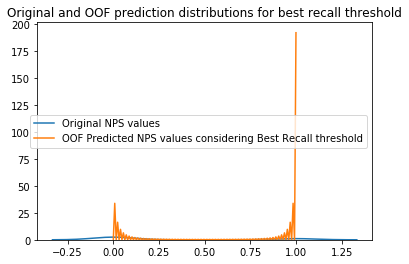

In [58]:
sns.kdeplot(y,label="Original NPS values")
sns.kdeplot(probstoLabel(oof,bstThreshRec),label="OOF Predicted NPS values considering Best Recall threshold")
plt.title("Original and OOF prediction distributions for best recall threshold")
;

''

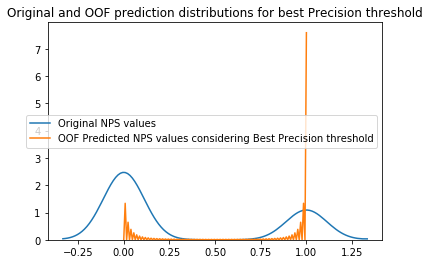

In [60]:
sns.kdeplot(y,label="Original NPS values")
sns.kdeplot(probstoLabel(oof,bstThreshPrec),label="OOF Predicted NPS values considering Best Precision threshold")
plt.title("Original and OOF prediction distributions for best Precision threshold")
;

''

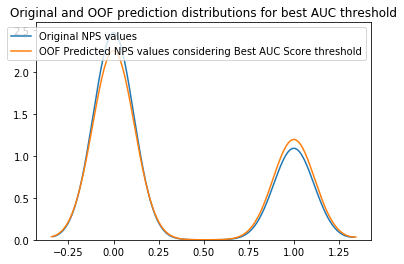

In [61]:
sns.kdeplot(y,label="Original NPS values")
sns.kdeplot(probstoLabel(oof,bstroc_auc_scoreThresh),label="OOF Predicted NPS values considering Best AUC Score threshold")
plt.title("Original and OOF prediction distributions for best AUC threshold")
;

''

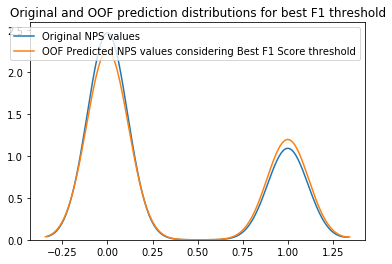

In [65]:
sns.kdeplot(y,label="Original NPS values")
sns.kdeplot(probstoLabel(oof,bstf1thresh),label="OOF Predicted NPS values considering Best F1 Score threshold")
plt.title("Original and OOF prediction distributions for best F1 threshold")
;

In [70]:
### fn to generate outputs on test dataset given input probs and a threshold
def generateThresholdPreds(NPS,preds,thresh):
    _ = NPS[['region','cluster','month']]
    preds = probstoLabel(preds,thresh)
    _['Target'] = preds
    return _

predsAUCOptimized = generateThresholdPreds(NPS_te,preds,bstroc_auc_scoreThresh)
predsRecallOptimized = generateThresholdPreds(NPS_te,preds,bstThreshRec)
predsPrecisionOptimized = generateThresholdPreds(NPS_te,preds,bstThreshPrec)

C:\Users\EIAJRTW\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


### Mix Approach: A 2 pronged appraoch

- First, we get the logit preds from shallow regression xgboost model --> this is without thresholding to 0.1
- Append these to the X train and X test dataframe
- Run the classifier on new X train and new X test

In [74]:
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from xgboost import XGBClassifier,XGBRegressor

NFOLDS = 5
kfold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=42)
drop_features = ['region','cluster','month','nps_bins','nps_values']
y = NPS_tr['nps_values']
X = NPS_tr.drop(drop_features,axis=1)
commonCols = [i for i in X.columns if i in NPS_te.columns]
X = X[commonCols]
test = NPS_te[commonCols]
feature_importance_df = pd.DataFrame()
oof = np.zeros_like(y)
preds = np.zeros(len(test))

for i,(tr_idx,val_idx) in enumerate(kfold.split(X, NPS_tr['nps_bins'])):
    print("Fold {}".format(i+1))
    X_tr, X_val, Y_tr, Y_val = X.loc[tr_idx,:], X.loc[val_idx,:], y[tr_idx], y[val_idx]
    bst  = XGBRegressor(max_depth=13, learning_rate=0.1, n_estimators=500, n_jobs=4, verbosity=3, objective='reg:squarederror', booster='gblinear', 
                        tree_method='auto', gamma=0.3, subsample=0.5, colsample_bytree=0.5, colsample_bylevel=0.5,
                        reg_alpha=1, reg_lambda=1, random_state=42, importance_type='gain')
    bst.fit(X_tr,Y_tr,early_stopping_rounds=250, eval_set=[(X_tr,Y_tr),(X_val, Y_val)],eval_metric=['rmse','mae'] ,verbose=True)

    oof[val_idx] = bst.predict(X_val,ntree_limit = 0)
    
    preds += bst.predict(test,ntree_limit = 0)/NFOLDS

C:\Users\EIAJRTW\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Fold 1


C:\Users\EIAJRTW\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	validation_0-rmse:0.129803	validation_0-mae:0.095556	validation_1-rmse:0.123057	validation_1-mae:0.095107
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 250 rounds.
[1]	validation_0-rmse:0.12705	validation_0-mae:0.093028	validation_1-rmse:0.121051	validation_1-mae:0.093242
[2]	validation_0-rmse:0.125596	validation_0-mae:0.091603	validation_1-rmse:0.120095	validation_1-mae:0.092546
[3]	validation_0-rmse:0.124643	validation_0-mae:0.090634	validation_1-rmse:0.119513	validation_1-mae:0.092091
[4]	validation_0-rmse:0.123933	validation_0-mae:0.089953	validation_1-rmse:0.119088	validation_1-mae:0.091739
[5]	validation_0-rmse:0.123369	validation_0-mae:0.089379	validation_1-rmse:0.118764	validation_1-mae:0.09141
[6]	validation_0-rmse:0.122906	validation_0-mae:0.088855	validation_1-rmse:0.118491	validation_1-mae:0.091115
[7]	validation_0-rmse:0.122521	validation_0-mae:0.088479	validation_1-rmse

[73]	validation_0-rmse:0.117635	validation_0-mae:0.083968	validation_1-rmse:0.115908	validation_1-mae:0.088243
[74]	validation_0-rmse:0.117614	validation_0-mae:0.083945	validation_1-rmse:0.115901	validation_1-mae:0.088223
[75]	validation_0-rmse:0.117594	validation_0-mae:0.083934	validation_1-rmse:0.115898	validation_1-mae:0.088218
[76]	validation_0-rmse:0.117575	validation_0-mae:0.083917	validation_1-rmse:0.115893	validation_1-mae:0.088203
[77]	validation_0-rmse:0.117555	validation_0-mae:0.083899	validation_1-rmse:0.115884	validation_1-mae:0.088186
[78]	validation_0-rmse:0.117536	validation_0-mae:0.083882	validation_1-rmse:0.115877	validation_1-mae:0.088171
[79]	validation_0-rmse:0.117517	validation_0-mae:0.083864	validation_1-rmse:0.115869	validation_1-mae:0.088155
[80]	validation_0-rmse:0.117498	validation_0-mae:0.083847	validation_1-rmse:0.115861	validation_1-mae:0.088139
[81]	validation_0-rmse:0.117479	validation_0-mae:0.083831	validation_1-rmse:0.115854	validation_1-mae:0.088124
[

[147]	validation_0-rmse:0.116646	validation_0-mae:0.083107	validation_1-rmse:0.115565	validation_1-mae:0.087711
[148]	validation_0-rmse:0.116637	validation_0-mae:0.0831	validation_1-rmse:0.115562	validation_1-mae:0.087707
[149]	validation_0-rmse:0.116627	validation_0-mae:0.083091	validation_1-rmse:0.115558	validation_1-mae:0.087701
[150]	validation_0-rmse:0.116618	validation_0-mae:0.083086	validation_1-rmse:0.115555	validation_1-mae:0.0877
[151]	validation_0-rmse:0.116609	validation_0-mae:0.083077	validation_1-rmse:0.115552	validation_1-mae:0.087693
[152]	validation_0-rmse:0.116601	validation_0-mae:0.083071	validation_1-rmse:0.11555	validation_1-mae:0.087693
[153]	validation_0-rmse:0.116592	validation_0-mae:0.083064	validation_1-rmse:0.115547	validation_1-mae:0.087688
[154]	validation_0-rmse:0.116583	validation_0-mae:0.083055	validation_1-rmse:0.115544	validation_1-mae:0.087682
[155]	validation_0-rmse:0.116575	validation_0-mae:0.083046	validation_1-rmse:0.115541	validation_1-mae:0.0876

[221]	validation_0-rmse:0.116134	validation_0-mae:0.082647	validation_1-rmse:0.115483	validation_1-mae:0.087537
[222]	validation_0-rmse:0.116129	validation_0-mae:0.08264	validation_1-rmse:0.115482	validation_1-mae:0.087534
[223]	validation_0-rmse:0.116124	validation_0-mae:0.082636	validation_1-rmse:0.115482	validation_1-mae:0.087532
[224]	validation_0-rmse:0.116119	validation_0-mae:0.082631	validation_1-rmse:0.115481	validation_1-mae:0.087532
[225]	validation_0-rmse:0.116114	validation_0-mae:0.082628	validation_1-rmse:0.11548	validation_1-mae:0.087532
[226]	validation_0-rmse:0.116109	validation_0-mae:0.082623	validation_1-rmse:0.115479	validation_1-mae:0.08753
[227]	validation_0-rmse:0.116104	validation_0-mae:0.082618	validation_1-rmse:0.115478	validation_1-mae:0.087528
[228]	validation_0-rmse:0.1161	validation_0-mae:0.082613	validation_1-rmse:0.115477	validation_1-mae:0.087526
[229]	validation_0-rmse:0.116095	validation_0-mae:0.082608	validation_1-rmse:0.115476	validation_1-mae:0.0875

[295]	validation_0-rmse:0.115826	validation_0-mae:0.082351	validation_1-rmse:0.115481	validation_1-mae:0.087522
[296]	validation_0-rmse:0.115823	validation_0-mae:0.082347	validation_1-rmse:0.11548	validation_1-mae:0.087521
[297]	validation_0-rmse:0.11582	validation_0-mae:0.082344	validation_1-rmse:0.115481	validation_1-mae:0.087522
[298]	validation_0-rmse:0.115816	validation_0-mae:0.082341	validation_1-rmse:0.115481	validation_1-mae:0.087522
[299]	validation_0-rmse:0.115813	validation_0-mae:0.082338	validation_1-rmse:0.115481	validation_1-mae:0.087524
[300]	validation_0-rmse:0.115809	validation_0-mae:0.082335	validation_1-rmse:0.115481	validation_1-mae:0.087524
[301]	validation_0-rmse:0.115806	validation_0-mae:0.082332	validation_1-rmse:0.115482	validation_1-mae:0.087525
[302]	validation_0-rmse:0.115803	validation_0-mae:0.082329	validation_1-rmse:0.115482	validation_1-mae:0.087524
[303]	validation_0-rmse:0.115799	validation_0-mae:0.082326	validation_1-rmse:0.115482	validation_1-mae:0.0

[369]	validation_0-rmse:0.115608	validation_0-mae:0.082139	validation_1-rmse:0.115462	validation_1-mae:0.087518
[370]	validation_0-rmse:0.115606	validation_0-mae:0.082137	validation_1-rmse:0.115462	validation_1-mae:0.087518
[371]	validation_0-rmse:0.115603	validation_0-mae:0.082134	validation_1-rmse:0.115462	validation_1-mae:0.087517
[372]	validation_0-rmse:0.115601	validation_0-mae:0.082131	validation_1-rmse:0.115462	validation_1-mae:0.087516
[373]	validation_0-rmse:0.115598	validation_0-mae:0.08213	validation_1-rmse:0.115461	validation_1-mae:0.087517
[374]	validation_0-rmse:0.115596	validation_0-mae:0.082127	validation_1-rmse:0.115461	validation_1-mae:0.087517
[375]	validation_0-rmse:0.115594	validation_0-mae:0.082125	validation_1-rmse:0.115461	validation_1-mae:0.087516
[376]	validation_0-rmse:0.115591	validation_0-mae:0.082123	validation_1-rmse:0.11546	validation_1-mae:0.087516
[377]	validation_0-rmse:0.115589	validation_0-mae:0.08212	validation_1-rmse:0.115459	validation_1-mae:0.08

[443]	validation_0-rmse:0.115444	validation_0-mae:0.081985	validation_1-rmse:0.115453	validation_1-mae:0.087507
[444]	validation_0-rmse:0.115442	validation_0-mae:0.081983	validation_1-rmse:0.115453	validation_1-mae:0.087507
[445]	validation_0-rmse:0.11544	validation_0-mae:0.081982	validation_1-rmse:0.115453	validation_1-mae:0.087507
[446]	validation_0-rmse:0.115438	validation_0-mae:0.08198	validation_1-rmse:0.115453	validation_1-mae:0.087508
[447]	validation_0-rmse:0.115436	validation_0-mae:0.081978	validation_1-rmse:0.115454	validation_1-mae:0.087507
[448]	validation_0-rmse:0.115434	validation_0-mae:0.081976	validation_1-rmse:0.115454	validation_1-mae:0.087507
[449]	validation_0-rmse:0.115432	validation_0-mae:0.081975	validation_1-rmse:0.115454	validation_1-mae:0.087508
[450]	validation_0-rmse:0.11543	validation_0-mae:0.081973	validation_1-rmse:0.115454	validation_1-mae:0.087508
[451]	validation_0-rmse:0.115428	validation_0-mae:0.081971	validation_1-rmse:0.115454	validation_1-mae:0.08

[11]	validation_0-rmse:0.120734	validation_0-mae:0.087779	validation_1-rmse:0.119868	validation_1-mae:0.087684
[12]	validation_0-rmse:0.120523	validation_0-mae:0.087572	validation_1-rmse:0.119832	validation_1-mae:0.087576
[13]	validation_0-rmse:0.120329	validation_0-mae:0.087382	validation_1-rmse:0.119797	validation_1-mae:0.087507
[14]	validation_0-rmse:0.120149	validation_0-mae:0.08718	validation_1-rmse:0.119784	validation_1-mae:0.087436
[15]	validation_0-rmse:0.119982	validation_0-mae:0.08706	validation_1-rmse:0.119742	validation_1-mae:0.087398
[16]	validation_0-rmse:0.119834	validation_0-mae:0.086912	validation_1-rmse:0.119711	validation_1-mae:0.087339
[17]	validation_0-rmse:0.119698	validation_0-mae:0.086749	validation_1-rmse:0.119687	validation_1-mae:0.087267
[18]	validation_0-rmse:0.119567	validation_0-mae:0.086622	validation_1-rmse:0.119676	validation_1-mae:0.087237
[19]	validation_0-rmse:0.119442	validation_0-mae:0.086534	validation_1-rmse:0.119645	validation_1-mae:0.087212
[20

[86]	validation_0-rmse:0.11674	validation_0-mae:0.084112	validation_1-rmse:0.118707	validation_1-mae:0.086582
[87]	validation_0-rmse:0.116724	validation_0-mae:0.084096	validation_1-rmse:0.118698	validation_1-mae:0.086577
[88]	validation_0-rmse:0.116709	validation_0-mae:0.084079	validation_1-rmse:0.11869	validation_1-mae:0.08657
[89]	validation_0-rmse:0.116693	validation_0-mae:0.084063	validation_1-rmse:0.118681	validation_1-mae:0.086564
[90]	validation_0-rmse:0.116677	validation_0-mae:0.084049	validation_1-rmse:0.118671	validation_1-mae:0.086557
[91]	validation_0-rmse:0.116662	validation_0-mae:0.084034	validation_1-rmse:0.118661	validation_1-mae:0.086552
[92]	validation_0-rmse:0.116647	validation_0-mae:0.084018	validation_1-rmse:0.118654	validation_1-mae:0.086547
[93]	validation_0-rmse:0.116632	validation_0-mae:0.084002	validation_1-rmse:0.118646	validation_1-mae:0.086541
[94]	validation_0-rmse:0.116617	validation_0-mae:0.083985	validation_1-rmse:0.11864	validation_1-mae:0.086536
[95]	

[160]	validation_0-rmse:0.115928	validation_0-mae:0.083278	validation_1-rmse:0.118185	validation_1-mae:0.086291
[161]	validation_0-rmse:0.115921	validation_0-mae:0.083271	validation_1-rmse:0.118178	validation_1-mae:0.086287
[162]	validation_0-rmse:0.115914	validation_0-mae:0.083262	validation_1-rmse:0.118175	validation_1-mae:0.086286
[163]	validation_0-rmse:0.115906	validation_0-mae:0.083254	validation_1-rmse:0.11817	validation_1-mae:0.086284
[164]	validation_0-rmse:0.115899	validation_0-mae:0.083246	validation_1-rmse:0.118165	validation_1-mae:0.086282
[165]	validation_0-rmse:0.115892	validation_0-mae:0.083239	validation_1-rmse:0.11816	validation_1-mae:0.086279
[166]	validation_0-rmse:0.115885	validation_0-mae:0.083233	validation_1-rmse:0.118154	validation_1-mae:0.086277
[167]	validation_0-rmse:0.115878	validation_0-mae:0.083225	validation_1-rmse:0.118148	validation_1-mae:0.086274
[168]	validation_0-rmse:0.115871	validation_0-mae:0.083217	validation_1-rmse:0.118146	validation_1-mae:0.0

[234]	validation_0-rmse:0.115518	validation_0-mae:0.082811	validation_1-rmse:0.11788	validation_1-mae:0.086153
[235]	validation_0-rmse:0.115514	validation_0-mae:0.082806	validation_1-rmse:0.117877	validation_1-mae:0.086152
[236]	validation_0-rmse:0.115509	validation_0-mae:0.082802	validation_1-rmse:0.117874	validation_1-mae:0.08615
[237]	validation_0-rmse:0.115505	validation_0-mae:0.082798	validation_1-rmse:0.117869	validation_1-mae:0.086148
[238]	validation_0-rmse:0.115501	validation_0-mae:0.082794	validation_1-rmse:0.117867	validation_1-mae:0.086146
[239]	validation_0-rmse:0.115497	validation_0-mae:0.082789	validation_1-rmse:0.117862	validation_1-mae:0.086144
[240]	validation_0-rmse:0.115493	validation_0-mae:0.082785	validation_1-rmse:0.11786	validation_1-mae:0.086143
[241]	validation_0-rmse:0.115489	validation_0-mae:0.082781	validation_1-rmse:0.117856	validation_1-mae:0.086142
[242]	validation_0-rmse:0.115485	validation_0-mae:0.082777	validation_1-rmse:0.117853	validation_1-mae:0.08

[308]	validation_0-rmse:0.115266	validation_0-mae:0.082558	validation_1-rmse:0.117665	validation_1-mae:0.086051
[309]	validation_0-rmse:0.115263	validation_0-mae:0.082555	validation_1-rmse:0.117663	validation_1-mae:0.08605
[310]	validation_0-rmse:0.11526	validation_0-mae:0.082552	validation_1-rmse:0.117663	validation_1-mae:0.08605
[311]	validation_0-rmse:0.115257	validation_0-mae:0.082549	validation_1-rmse:0.117661	validation_1-mae:0.086049
[312]	validation_0-rmse:0.115255	validation_0-mae:0.082547	validation_1-rmse:0.117658	validation_1-mae:0.086047
[313]	validation_0-rmse:0.115252	validation_0-mae:0.082544	validation_1-rmse:0.117655	validation_1-mae:0.086045
[314]	validation_0-rmse:0.115249	validation_0-mae:0.082542	validation_1-rmse:0.117652	validation_1-mae:0.086044
[315]	validation_0-rmse:0.115246	validation_0-mae:0.082539	validation_1-rmse:0.117651	validation_1-mae:0.086043
[316]	validation_0-rmse:0.115244	validation_0-mae:0.082537	validation_1-rmse:0.117648	validation_1-mae:0.08

[382]	validation_0-rmse:0.115085	validation_0-mae:0.082377	validation_1-rmse:0.117532	validation_1-mae:0.085981
[383]	validation_0-rmse:0.115083	validation_0-mae:0.082375	validation_1-rmse:0.11753	validation_1-mae:0.08598
[384]	validation_0-rmse:0.115081	validation_0-mae:0.082373	validation_1-rmse:0.117529	validation_1-mae:0.085979
[385]	validation_0-rmse:0.115079	validation_0-mae:0.08237	validation_1-rmse:0.117528	validation_1-mae:0.085979
[386]	validation_0-rmse:0.115077	validation_0-mae:0.082369	validation_1-rmse:0.117526	validation_1-mae:0.085978
[387]	validation_0-rmse:0.115075	validation_0-mae:0.082367	validation_1-rmse:0.117524	validation_1-mae:0.085977
[388]	validation_0-rmse:0.115073	validation_0-mae:0.082364	validation_1-rmse:0.117523	validation_1-mae:0.085976
[389]	validation_0-rmse:0.115071	validation_0-mae:0.082362	validation_1-rmse:0.117522	validation_1-mae:0.085976
[390]	validation_0-rmse:0.115069	validation_0-mae:0.08236	validation_1-rmse:0.117521	validation_1-mae:0.085

[456]	validation_0-rmse:0.114948	validation_0-mae:0.082238	validation_1-rmse:0.117449	validation_1-mae:0.085936
[457]	validation_0-rmse:0.114946	validation_0-mae:0.082236	validation_1-rmse:0.117448	validation_1-mae:0.085935
[458]	validation_0-rmse:0.114945	validation_0-mae:0.082234	validation_1-rmse:0.117448	validation_1-mae:0.085935
[459]	validation_0-rmse:0.114943	validation_0-mae:0.082233	validation_1-rmse:0.117448	validation_1-mae:0.085935
[460]	validation_0-rmse:0.114941	validation_0-mae:0.082232	validation_1-rmse:0.117447	validation_1-mae:0.085935
[461]	validation_0-rmse:0.11494	validation_0-mae:0.08223	validation_1-rmse:0.117447	validation_1-mae:0.085934
[462]	validation_0-rmse:0.114938	validation_0-mae:0.082228	validation_1-rmse:0.117446	validation_1-mae:0.085934
[463]	validation_0-rmse:0.114936	validation_0-mae:0.082227	validation_1-rmse:0.117445	validation_1-mae:0.085934
[464]	validation_0-rmse:0.114935	validation_0-mae:0.082225	validation_1-rmse:0.117444	validation_1-mae:0.0

[25]	validation_0-rmse:0.119487	validation_0-mae:0.085875	validation_1-rmse:0.116363	validation_1-mae:0.087355
[26]	validation_0-rmse:0.119402	validation_0-mae:0.085798	validation_1-rmse:0.116324	validation_1-mae:0.087319
[27]	validation_0-rmse:0.119321	validation_0-mae:0.085721	validation_1-rmse:0.116282	validation_1-mae:0.087277
[28]	validation_0-rmse:0.119242	validation_0-mae:0.085647	validation_1-rmse:0.11624	validation_1-mae:0.087239
[29]	validation_0-rmse:0.119167	validation_0-mae:0.085565	validation_1-rmse:0.116195	validation_1-mae:0.087175
[30]	validation_0-rmse:0.119094	validation_0-mae:0.085511	validation_1-rmse:0.116171	validation_1-mae:0.087175
[31]	validation_0-rmse:0.119025	validation_0-mae:0.085448	validation_1-rmse:0.116137	validation_1-mae:0.087145
[32]	validation_0-rmse:0.118958	validation_0-mae:0.085389	validation_1-rmse:0.116105	validation_1-mae:0.087124
[33]	validation_0-rmse:0.118896	validation_0-mae:0.085329	validation_1-rmse:0.116074	validation_1-mae:0.08709
[34

[100]	validation_0-rmse:0.11701	validation_0-mae:0.083661	validation_1-rmse:0.11553	validation_1-mae:0.086978
[101]	validation_0-rmse:0.116996	validation_0-mae:0.083649	validation_1-rmse:0.115527	validation_1-mae:0.086981
[102]	validation_0-rmse:0.116983	validation_0-mae:0.083637	validation_1-rmse:0.115523	validation_1-mae:0.086983
[103]	validation_0-rmse:0.11697	validation_0-mae:0.083626	validation_1-rmse:0.115522	validation_1-mae:0.086988
[104]	validation_0-rmse:0.116956	validation_0-mae:0.083615	validation_1-rmse:0.115521	validation_1-mae:0.086991
[105]	validation_0-rmse:0.116944	validation_0-mae:0.083603	validation_1-rmse:0.115517	validation_1-mae:0.086992
[106]	validation_0-rmse:0.116931	validation_0-mae:0.083592	validation_1-rmse:0.115515	validation_1-mae:0.086994
[107]	validation_0-rmse:0.116918	validation_0-mae:0.08358	validation_1-rmse:0.115512	validation_1-mae:0.086996
[108]	validation_0-rmse:0.116906	validation_0-mae:0.08357	validation_1-rmse:0.115512	validation_1-mae:0.0870

[174]	validation_0-rmse:0.116282	validation_0-mae:0.083022	validation_1-rmse:0.115464	validation_1-mae:0.087122
[175]	validation_0-rmse:0.116275	validation_0-mae:0.083016	validation_1-rmse:0.115463	validation_1-mae:0.087121
[176]	validation_0-rmse:0.116268	validation_0-mae:0.08301	validation_1-rmse:0.115462	validation_1-mae:0.087123
[177]	validation_0-rmse:0.116262	validation_0-mae:0.083004	validation_1-rmse:0.115461	validation_1-mae:0.087123
[178]	validation_0-rmse:0.116255	validation_0-mae:0.082998	validation_1-rmse:0.11546	validation_1-mae:0.087123
[179]	validation_0-rmse:0.116249	validation_0-mae:0.082992	validation_1-rmse:0.115459	validation_1-mae:0.087123
[180]	validation_0-rmse:0.116242	validation_0-mae:0.082986	validation_1-rmse:0.115458	validation_1-mae:0.087123
[181]	validation_0-rmse:0.116236	validation_0-mae:0.08298	validation_1-rmse:0.115456	validation_1-mae:0.087122
[182]	validation_0-rmse:0.116229	validation_0-mae:0.082974	validation_1-rmse:0.115455	validation_1-mae:0.08

[248]	validation_0-rmse:0.115902	validation_0-mae:0.082667	validation_1-rmse:0.115416	validation_1-mae:0.08715
[249]	validation_0-rmse:0.115898	validation_0-mae:0.082664	validation_1-rmse:0.115415	validation_1-mae:0.08715
[250]	validation_0-rmse:0.115894	validation_0-mae:0.08266	validation_1-rmse:0.115415	validation_1-mae:0.087151
[251]	validation_0-rmse:0.11589	validation_0-mae:0.082656	validation_1-rmse:0.115413	validation_1-mae:0.08715
[252]	validation_0-rmse:0.115887	validation_0-mae:0.082653	validation_1-rmse:0.115412	validation_1-mae:0.08715
[253]	validation_0-rmse:0.115883	validation_0-mae:0.082649	validation_1-rmse:0.115412	validation_1-mae:0.08715
[254]	validation_0-rmse:0.115879	validation_0-mae:0.082645	validation_1-rmse:0.115412	validation_1-mae:0.08715
[255]	validation_0-rmse:0.115876	validation_0-mae:0.082641	validation_1-rmse:0.115411	validation_1-mae:0.087151
[256]	validation_0-rmse:0.115872	validation_0-mae:0.082638	validation_1-rmse:0.11541	validation_1-mae:0.08715
[2

Will train until validation_1-mae hasn't improved in 250 rounds.
[1]	validation_0-rmse:0.12082	validation_0-mae:0.092907	validation_1-rmse:0.145627	validation_1-mae:0.095015
[2]	validation_0-rmse:0.119513	validation_0-mae:0.091701	validation_1-rmse:0.144622	validation_1-mae:0.093937
[3]	validation_0-rmse:0.118621	validation_0-mae:0.090834	validation_1-rmse:0.143841	validation_1-mae:0.093106
[4]	validation_0-rmse:0.117964	validation_0-mae:0.09017	validation_1-rmse:0.143229	validation_1-mae:0.092396
[5]	validation_0-rmse:0.117442	validation_0-mae:0.089641	validation_1-rmse:0.142746	validation_1-mae:0.091819
[6]	validation_0-rmse:0.117006	validation_0-mae:0.08917	validation_1-rmse:0.142339	validation_1-mae:0.091304
[7]	validation_0-rmse:0.116623	validation_0-mae:0.088809	validation_1-rmse:0.141961	validation_1-mae:0.09085
[8]	validation_0-rmse:0.116299	validation_0-mae:0.088483	validation_1-rmse:0.141665	validation_1-mae:0.090472
[9]	validation_0-rmse:0.116013	validation_0-mae:0.088189	va

[75]	validation_0-rmse:0.111334	validation_0-mae:0.083958	validation_1-rmse:0.138876	validation_1-mae:0.087237
[76]	validation_0-rmse:0.111314	validation_0-mae:0.083943	validation_1-rmse:0.138868	validation_1-mae:0.087233
[77]	validation_0-rmse:0.111293	validation_0-mae:0.083925	validation_1-rmse:0.13886	validation_1-mae:0.087227
[78]	validation_0-rmse:0.111274	validation_0-mae:0.083908	validation_1-rmse:0.138855	validation_1-mae:0.087224
[79]	validation_0-rmse:0.111254	validation_0-mae:0.08389	validation_1-rmse:0.138849	validation_1-mae:0.087222
[80]	validation_0-rmse:0.111234	validation_0-mae:0.083873	validation_1-rmse:0.138841	validation_1-mae:0.087217
[81]	validation_0-rmse:0.111215	validation_0-mae:0.083856	validation_1-rmse:0.138836	validation_1-mae:0.087214
[82]	validation_0-rmse:0.111196	validation_0-mae:0.083841	validation_1-rmse:0.138828	validation_1-mae:0.08721
[83]	validation_0-rmse:0.111178	validation_0-mae:0.083824	validation_1-rmse:0.138821	validation_1-mae:0.087204
[84]

[149]	validation_0-rmse:0.110295	validation_0-mae:0.083054	validation_1-rmse:0.138514	validation_1-mae:0.086901
[150]	validation_0-rmse:0.110286	validation_0-mae:0.083045	validation_1-rmse:0.138514	validation_1-mae:0.086898
[151]	validation_0-rmse:0.110277	validation_0-mae:0.083038	validation_1-rmse:0.138512	validation_1-mae:0.086895
[152]	validation_0-rmse:0.110267	validation_0-mae:0.083029	validation_1-rmse:0.13851	validation_1-mae:0.086892
[153]	validation_0-rmse:0.110258	validation_0-mae:0.083021	validation_1-rmse:0.138509	validation_1-mae:0.08689
[154]	validation_0-rmse:0.110249	validation_0-mae:0.083013	validation_1-rmse:0.138509	validation_1-mae:0.086888
[155]	validation_0-rmse:0.110239	validation_0-mae:0.083005	validation_1-rmse:0.138508	validation_1-mae:0.086885
[156]	validation_0-rmse:0.11023	validation_0-mae:0.082997	validation_1-rmse:0.138504	validation_1-mae:0.086881
[157]	validation_0-rmse:0.110221	validation_0-mae:0.082989	validation_1-rmse:0.138504	validation_1-mae:0.08

[223]	validation_0-rmse:0.109779	validation_0-mae:0.082596	validation_1-rmse:0.138464	validation_1-mae:0.086691
[224]	validation_0-rmse:0.109774	validation_0-mae:0.082592	validation_1-rmse:0.138464	validation_1-mae:0.086689
[225]	validation_0-rmse:0.109769	validation_0-mae:0.082587	validation_1-rmse:0.138463	validation_1-mae:0.086687
[226]	validation_0-rmse:0.109763	validation_0-mae:0.082582	validation_1-rmse:0.138466	validation_1-mae:0.086686
[227]	validation_0-rmse:0.109759	validation_0-mae:0.082578	validation_1-rmse:0.138465	validation_1-mae:0.086684
[228]	validation_0-rmse:0.109753	validation_0-mae:0.082573	validation_1-rmse:0.138467	validation_1-mae:0.086683
[229]	validation_0-rmse:0.109748	validation_0-mae:0.082568	validation_1-rmse:0.138468	validation_1-mae:0.086682
[230]	validation_0-rmse:0.109744	validation_0-mae:0.082563	validation_1-rmse:0.138468	validation_1-mae:0.08668
[231]	validation_0-rmse:0.109739	validation_0-mae:0.082558	validation_1-rmse:0.138468	validation_1-mae:0.

[297]	validation_0-rmse:0.10948	validation_0-mae:0.082319	validation_1-rmse:0.138514	validation_1-mae:0.086591
[298]	validation_0-rmse:0.109477	validation_0-mae:0.082316	validation_1-rmse:0.138514	validation_1-mae:0.086589
[299]	validation_0-rmse:0.109474	validation_0-mae:0.082313	validation_1-rmse:0.138515	validation_1-mae:0.086588
[300]	validation_0-rmse:0.10947	validation_0-mae:0.08231	validation_1-rmse:0.138515	validation_1-mae:0.086587
[301]	validation_0-rmse:0.109467	validation_0-mae:0.082307	validation_1-rmse:0.138516	validation_1-mae:0.086586
[302]	validation_0-rmse:0.109463	validation_0-mae:0.082303	validation_1-rmse:0.138518	validation_1-mae:0.086586
[303]	validation_0-rmse:0.10946	validation_0-mae:0.0823	validation_1-rmse:0.138518	validation_1-mae:0.086585
[304]	validation_0-rmse:0.109456	validation_0-mae:0.082297	validation_1-rmse:0.138518	validation_1-mae:0.086583
[305]	validation_0-rmse:0.109453	validation_0-mae:0.082295	validation_1-rmse:0.138519	validation_1-mae:0.08658

[371]	validation_0-rmse:0.109259	validation_0-mae:0.082122	validation_1-rmse:0.138545	validation_1-mae:0.086518
[372]	validation_0-rmse:0.109257	validation_0-mae:0.08212	validation_1-rmse:0.138545	validation_1-mae:0.086517
[373]	validation_0-rmse:0.109254	validation_0-mae:0.082118	validation_1-rmse:0.138546	validation_1-mae:0.086516
[374]	validation_0-rmse:0.109252	validation_0-mae:0.082115	validation_1-rmse:0.138546	validation_1-mae:0.086515
[375]	validation_0-rmse:0.109249	validation_0-mae:0.082113	validation_1-rmse:0.138546	validation_1-mae:0.086514
[376]	validation_0-rmse:0.109247	validation_0-mae:0.082111	validation_1-rmse:0.138547	validation_1-mae:0.086514
[377]	validation_0-rmse:0.109245	validation_0-mae:0.082108	validation_1-rmse:0.138547	validation_1-mae:0.086513
[378]	validation_0-rmse:0.109242	validation_0-mae:0.082106	validation_1-rmse:0.138548	validation_1-mae:0.086512
[379]	validation_0-rmse:0.10924	validation_0-mae:0.082104	validation_1-rmse:0.138549	validation_1-mae:0.0

[445]	validation_0-rmse:0.109096	validation_0-mae:0.081969	validation_1-rmse:0.138575	validation_1-mae:0.086494
[446]	validation_0-rmse:0.109094	validation_0-mae:0.081967	validation_1-rmse:0.138575	validation_1-mae:0.086494
[447]	validation_0-rmse:0.109092	validation_0-mae:0.081965	validation_1-rmse:0.138576	validation_1-mae:0.086494
[448]	validation_0-rmse:0.10909	validation_0-mae:0.081964	validation_1-rmse:0.138577	validation_1-mae:0.086495
[449]	validation_0-rmse:0.109088	validation_0-mae:0.081962	validation_1-rmse:0.138577	validation_1-mae:0.086495
[450]	validation_0-rmse:0.109086	validation_0-mae:0.08196	validation_1-rmse:0.138578	validation_1-mae:0.086495
[451]	validation_0-rmse:0.109084	validation_0-mae:0.081958	validation_1-rmse:0.138578	validation_1-mae:0.086495
[452]	validation_0-rmse:0.109082	validation_0-mae:0.081956	validation_1-rmse:0.138579	validation_1-mae:0.086496
[453]	validation_0-rmse:0.10908	validation_0-mae:0.081954	validation_1-rmse:0.13858	validation_1-mae:0.086

[13]	validation_0-rmse:0.121927	validation_0-mae:0.087641	validation_1-rmse:0.114795	validation_1-mae:0.089546
[14]	validation_0-rmse:0.121768	validation_0-mae:0.087512	validation_1-rmse:0.114678	validation_1-mae:0.089442
[15]	validation_0-rmse:0.121623	validation_0-mae:0.087367	validation_1-rmse:0.114571	validation_1-mae:0.089351
[16]	validation_0-rmse:0.121489	validation_0-mae:0.087252	validation_1-rmse:0.114463	validation_1-mae:0.089263
[17]	validation_0-rmse:0.121353	validation_0-mae:0.087128	validation_1-rmse:0.114347	validation_1-mae:0.089162
[18]	validation_0-rmse:0.121239	validation_0-mae:0.087022	validation_1-rmse:0.114244	validation_1-mae:0.089072
[19]	validation_0-rmse:0.12113	validation_0-mae:0.086917	validation_1-rmse:0.114144	validation_1-mae:0.088977
[20]	validation_0-rmse:0.121029	validation_0-mae:0.086826	validation_1-rmse:0.114046	validation_1-mae:0.08888
[21]	validation_0-rmse:0.120931	validation_0-mae:0.086727	validation_1-rmse:0.113949	validation_1-mae:0.088783
[22

[88]	validation_0-rmse:0.118556	validation_0-mae:0.084714	validation_1-rmse:0.11095	validation_1-mae:0.085797
[89]	validation_0-rmse:0.11854	validation_0-mae:0.084699	validation_1-rmse:0.110929	validation_1-mae:0.085776
[90]	validation_0-rmse:0.118525	validation_0-mae:0.084685	validation_1-rmse:0.110911	validation_1-mae:0.08576
[91]	validation_0-rmse:0.118511	validation_0-mae:0.084671	validation_1-rmse:0.110892	validation_1-mae:0.085742
[92]	validation_0-rmse:0.118496	validation_0-mae:0.084657	validation_1-rmse:0.110875	validation_1-mae:0.085724
[93]	validation_0-rmse:0.118481	validation_0-mae:0.084644	validation_1-rmse:0.110855	validation_1-mae:0.085706
[94]	validation_0-rmse:0.118467	validation_0-mae:0.084632	validation_1-rmse:0.11084	validation_1-mae:0.085691
[95]	validation_0-rmse:0.118453	validation_0-mae:0.084618	validation_1-rmse:0.110818	validation_1-mae:0.085671
[96]	validation_0-rmse:0.118439	validation_0-mae:0.084606	validation_1-rmse:0.110799	validation_1-mae:0.085652
[97]	

[162]	validation_0-rmse:0.117736	validation_0-mae:0.083926	validation_1-rmse:0.110109	validation_1-mae:0.084976
[163]	validation_0-rmse:0.117729	validation_0-mae:0.083918	validation_1-rmse:0.110104	validation_1-mae:0.084971
[164]	validation_0-rmse:0.117721	validation_0-mae:0.083911	validation_1-rmse:0.1101	validation_1-mae:0.084967
[165]	validation_0-rmse:0.117714	validation_0-mae:0.083904	validation_1-rmse:0.110096	validation_1-mae:0.084962
[166]	validation_0-rmse:0.117706	validation_0-mae:0.083896	validation_1-rmse:0.11009	validation_1-mae:0.084955
[167]	validation_0-rmse:0.117698	validation_0-mae:0.083888	validation_1-rmse:0.110085	validation_1-mae:0.084948
[168]	validation_0-rmse:0.117691	validation_0-mae:0.083881	validation_1-rmse:0.110079	validation_1-mae:0.084942
[169]	validation_0-rmse:0.117683	validation_0-mae:0.083873	validation_1-rmse:0.110073	validation_1-mae:0.084936
[170]	validation_0-rmse:0.117676	validation_0-mae:0.083866	validation_1-rmse:0.110068	validation_1-mae:0.08

[236]	validation_0-rmse:0.117294	validation_0-mae:0.083485	validation_1-rmse:0.10988	validation_1-mae:0.084707
[237]	validation_0-rmse:0.11729	validation_0-mae:0.08348	validation_1-rmse:0.109879	validation_1-mae:0.084705
[238]	validation_0-rmse:0.117285	validation_0-mae:0.083475	validation_1-rmse:0.109877	validation_1-mae:0.084701
[239]	validation_0-rmse:0.117281	validation_0-mae:0.083471	validation_1-rmse:0.109876	validation_1-mae:0.084699
[240]	validation_0-rmse:0.117277	validation_0-mae:0.083466	validation_1-rmse:0.109873	validation_1-mae:0.084695
[241]	validation_0-rmse:0.117272	validation_0-mae:0.083463	validation_1-rmse:0.109871	validation_1-mae:0.084693
[242]	validation_0-rmse:0.117268	validation_0-mae:0.08346	validation_1-rmse:0.10987	validation_1-mae:0.084691
[243]	validation_0-rmse:0.117264	validation_0-mae:0.083455	validation_1-rmse:0.109869	validation_1-mae:0.084688
[244]	validation_0-rmse:0.11726	validation_0-mae:0.08345	validation_1-rmse:0.109866	validation_1-mae:0.084684

[310]	validation_0-rmse:0.117033	validation_0-mae:0.083238	validation_1-rmse:0.109775	validation_1-mae:0.084553
[311]	validation_0-rmse:0.11703	validation_0-mae:0.083235	validation_1-rmse:0.109774	validation_1-mae:0.084552
[312]	validation_0-rmse:0.117027	validation_0-mae:0.083233	validation_1-rmse:0.109773	validation_1-mae:0.084551
[313]	validation_0-rmse:0.117024	validation_0-mae:0.08323	validation_1-rmse:0.109771	validation_1-mae:0.084549
[314]	validation_0-rmse:0.117021	validation_0-mae:0.083227	validation_1-rmse:0.109771	validation_1-mae:0.084547
[315]	validation_0-rmse:0.117018	validation_0-mae:0.083225	validation_1-rmse:0.10977	validation_1-mae:0.084545
[316]	validation_0-rmse:0.117015	validation_0-mae:0.083222	validation_1-rmse:0.109768	validation_1-mae:0.084542
[317]	validation_0-rmse:0.117012	validation_0-mae:0.083219	validation_1-rmse:0.109767	validation_1-mae:0.08454
[318]	validation_0-rmse:0.117009	validation_0-mae:0.083216	validation_1-rmse:0.109766	validation_1-mae:0.084

[384]	validation_0-rmse:0.116822	validation_0-mae:0.083051	validation_1-rmse:0.109739	validation_1-mae:0.084445
[385]	validation_0-rmse:0.116819	validation_0-mae:0.083049	validation_1-rmse:0.109738	validation_1-mae:0.084444
[386]	validation_0-rmse:0.116817	validation_0-mae:0.083046	validation_1-rmse:0.109739	validation_1-mae:0.084442
[387]	validation_0-rmse:0.116814	validation_0-mae:0.083045	validation_1-rmse:0.109739	validation_1-mae:0.084442
[388]	validation_0-rmse:0.116812	validation_0-mae:0.083043	validation_1-rmse:0.109738	validation_1-mae:0.084441
[389]	validation_0-rmse:0.116809	validation_0-mae:0.083041	validation_1-rmse:0.109739	validation_1-mae:0.084441
[390]	validation_0-rmse:0.116807	validation_0-mae:0.083038	validation_1-rmse:0.109739	validation_1-mae:0.08444
[391]	validation_0-rmse:0.116804	validation_0-mae:0.083035	validation_1-rmse:0.109739	validation_1-mae:0.084439
[392]	validation_0-rmse:0.116802	validation_0-mae:0.083034	validation_1-rmse:0.109739	validation_1-mae:0.

[458]	validation_0-rmse:0.116654	validation_0-mae:0.082905	validation_1-rmse:0.109756	validation_1-mae:0.08439
[459]	validation_0-rmse:0.116651	validation_0-mae:0.082903	validation_1-rmse:0.109757	validation_1-mae:0.08439
[460]	validation_0-rmse:0.116649	validation_0-mae:0.082901	validation_1-rmse:0.109758	validation_1-mae:0.08439
[461]	validation_0-rmse:0.116647	validation_0-mae:0.0829	validation_1-rmse:0.109758	validation_1-mae:0.08439
[462]	validation_0-rmse:0.116645	validation_0-mae:0.082898	validation_1-rmse:0.109759	validation_1-mae:0.08439
[463]	validation_0-rmse:0.116643	validation_0-mae:0.082896	validation_1-rmse:0.10976	validation_1-mae:0.08439
[464]	validation_0-rmse:0.116641	validation_0-mae:0.082894	validation_1-rmse:0.109761	validation_1-mae:0.08439
[465]	validation_0-rmse:0.116639	validation_0-mae:0.082893	validation_1-rmse:0.109762	validation_1-mae:0.084391
[466]	validation_0-rmse:0.116637	validation_0-mae:0.082891	validation_1-rmse:0.109763	validation_1-mae:0.084391
[4

In [81]:
regOOF = oof
regPreds = preds

In [84]:
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from xgboost import XGBClassifier,XGBRegressor

NFOLDS = 5
kfold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=42)
drop_features = ['region','cluster','month','nps_bins','nps_values']
y = NPS_tr['nps_values']
X = NPS_tr.drop(drop_features,axis=1)
commonCols = [i for i in X.columns if i in NPS_te.columns]
X = X[commonCols]
X = pd.concat([X,pd.Series(regOOF)],1)
test = NPS_te[commonCols]
test = pd.concat([test,pd.Series(regPreds)],1)
feature_importance_df = pd.DataFrame()
oof = np.zeros_like(y)
preds = np.zeros(len(test))

y = getBins(y)

for i,(tr_idx,val_idx) in enumerate(kfold.split(X, y)):
    print("Fold {}".format(i+1))
    X_tr, X_val, Y_tr, Y_val = X.loc[tr_idx,:], X.loc[val_idx,:], y[tr_idx], y[val_idx]
    bst  = XGBClassifier(max_depth=13, learning_rate=0.008, n_estimators=2000, n_jobs=4,verbosity=1, objective='binary:logistic', booster='gbtree', 
                        tree_method='auto', gamma=0.3, subsample=0.5, colsample_bytree=0.5, colsample_bylevel=0.5,
                        reg_alpha=1.75, reg_lambda=1, random_state=42, importance_type='gain')
    bst.fit(X_tr,Y_tr,early_stopping_rounds=250, eval_set=[(X_tr,Y_tr),(X_val, Y_val)],eval_metric = ['logloss','auc'] ,verbose=True)

    oof[val_idx] = bst.predict_proba(X_val)[:,1]
    
    preds += (bst.predict_proba(test)[:,1])/NFOLDS

Fold 1
[13:41:08] ======== Monitor: Learner ========
[13:41:08] EvalOneIter: 0.191663s, 500 calls @ 383us
[13:41:08] GetGradient: 0.0993024s, 500 calls @ 198us
[13:41:08] PredictRaw: 0.0102556s, 500 calls @ 20us
[13:41:08] UpdateOneIter: 15.4504s, 500 calls @ 30900us
[13:41:08] ======== Monitor: GBLinear ========
[13:41:08] DoBoost: 15.3379s, 500 calls @ 30675us
[13:41:08] PredictBatch: 0.0162225s, 1502 calls @ 10us
[13:41:08] PredictBatchInternal: 8.83658s, 1503 calls @ 5879us
[0]	validation_0-logloss:0.689427	validation_0-auc:0.853876	validation_1-logloss:0.689438	validation_1-auc:0.821869
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 250 rounds.
[1]	validation_0-logloss:0.6857	validation_0-auc:0.879432	validation_1-logloss:0.685837	validation_1-auc:0.84206
[2]	validation_0-logloss:0.682046	validation_0-auc:0.888782	validation_1-logloss:0.682461	validation_1-auc:0.845497
[3]	validation

[65]	validation_0-logloss:0.523215	validation_0-auc:0.914248	validation_1-logloss:0.529612	validation_1-auc:0.891997
[66]	validation_0-logloss:0.521593	validation_0-auc:0.914207	validation_1-logloss:0.528014	validation_1-auc:0.891478
[67]	validation_0-logloss:0.519848	validation_0-auc:0.914074	validation_1-logloss:0.526403	validation_1-auc:0.891046
[68]	validation_0-logloss:0.518114	validation_0-auc:0.914229	validation_1-logloss:0.524716	validation_1-auc:0.891003
[69]	validation_0-logloss:0.516349	validation_0-auc:0.914553	validation_1-logloss:0.523131	validation_1-auc:0.891716
[70]	validation_0-logloss:0.514619	validation_0-auc:0.91468	validation_1-logloss:0.521434	validation_1-auc:0.891457
[71]	validation_0-logloss:0.512959	validation_0-auc:0.914506	validation_1-logloss:0.519749	validation_1-auc:0.891673
[72]	validation_0-logloss:0.511302	validation_0-auc:0.914577	validation_1-logloss:0.518427	validation_1-auc:0.891111
[73]	validation_0-logloss:0.509578	validation_0-auc:0.914982	vali

[135]	validation_0-logloss:0.431007	validation_0-auc:0.924933	validation_1-logloss:0.448466	validation_1-auc:0.891911
[136]	validation_0-logloss:0.430007	validation_0-auc:0.925229	validation_1-logloss:0.447575	validation_1-auc:0.891997
[137]	validation_0-logloss:0.428982	validation_0-auc:0.925591	validation_1-logloss:0.446885	validation_1-auc:0.89217
[138]	validation_0-logloss:0.428031	validation_0-auc:0.92567	validation_1-logloss:0.446125	validation_1-auc:0.892256
[139]	validation_0-logloss:0.427108	validation_0-auc:0.925841	validation_1-logloss:0.445314	validation_1-auc:0.8923
[140]	validation_0-logloss:0.426113	validation_0-auc:0.926059	validation_1-logloss:0.444459	validation_1-auc:0.892559
[141]	validation_0-logloss:0.425058	validation_0-auc:0.926255	validation_1-logloss:0.443761	validation_1-auc:0.89204
[142]	validation_0-logloss:0.424118	validation_0-auc:0.926279	validation_1-logloss:0.443022	validation_1-auc:0.892256
[143]	validation_0-logloss:0.423131	validation_0-auc:0.926475

[205]	validation_0-logloss:0.376247	validation_0-auc:0.935321	validation_1-logloss:0.409172	validation_1-auc:0.890873
[206]	validation_0-logloss:0.375524	validation_0-auc:0.935552	validation_1-logloss:0.408823	validation_1-auc:0.8907
[207]	validation_0-logloss:0.374906	validation_0-auc:0.935808	validation_1-logloss:0.408461	validation_1-auc:0.890786
[208]	validation_0-logloss:0.374295	validation_0-auc:0.936074	validation_1-logloss:0.408089	validation_1-auc:0.891911
[209]	validation_0-logloss:0.373702	validation_0-auc:0.936197	validation_1-logloss:0.407628	validation_1-auc:0.891781
[210]	validation_0-logloss:0.373222	validation_0-auc:0.936216	validation_1-logloss:0.407204	validation_1-auc:0.891521
[211]	validation_0-logloss:0.372688	validation_0-auc:0.936156	validation_1-logloss:0.406744	validation_1-auc:0.891521
[212]	validation_0-logloss:0.372082	validation_0-auc:0.936278	validation_1-logloss:0.406388	validation_1-auc:0.891305
[213]	validation_0-logloss:0.371519	validation_0-auc:0.936

[275]	validation_0-logloss:0.34019	validation_0-auc:0.943937	validation_1-logloss:0.390884	validation_1-auc:0.890354
[276]	validation_0-logloss:0.339711	validation_0-auc:0.94409	validation_1-logloss:0.390854	validation_1-auc:0.890051
[277]	validation_0-logloss:0.339207	validation_0-auc:0.944188	validation_1-logloss:0.390943	validation_1-auc:0.889835
[278]	validation_0-logloss:0.338878	validation_0-auc:0.944163	validation_1-logloss:0.39081	validation_1-auc:0.889662
[279]	validation_0-logloss:0.338441	validation_0-auc:0.944283	validation_1-logloss:0.390675	validation_1-auc:0.889835
[280]	validation_0-logloss:0.338071	validation_0-auc:0.944381	validation_1-logloss:0.390477	validation_1-auc:0.889879
[281]	validation_0-logloss:0.337716	validation_0-auc:0.944446	validation_1-logloss:0.390228	validation_1-auc:0.889792
[282]	validation_0-logloss:0.337274	validation_0-auc:0.944522	validation_1-logloss:0.390102	validation_1-auc:0.889879
[283]	validation_0-logloss:0.336925	validation_0-auc:0.9446

[345]	validation_0-logloss:0.314282	validation_0-auc:0.950225	validation_1-logloss:0.383692	validation_1-auc:0.885858
[346]	validation_0-logloss:0.314001	validation_0-auc:0.950293	validation_1-logloss:0.383707	validation_1-auc:0.885641
[347]	validation_0-logloss:0.313618	validation_0-auc:0.950451	validation_1-logloss:0.383592	validation_1-auc:0.885771
[348]	validation_0-logloss:0.313248	validation_0-auc:0.950506	validation_1-logloss:0.383484	validation_1-auc:0.885685
[349]	validation_0-logloss:0.312974	validation_0-auc:0.950541	validation_1-logloss:0.383367	validation_1-auc:0.885555
[350]	validation_0-logloss:0.312521	validation_0-auc:0.95075	validation_1-logloss:0.383243	validation_1-auc:0.885987
Stopping. Best iteration:
[100]	validation_0-logloss:0.470436	validation_0-auc:0.921125	validation_1-logloss:0.482342	validation_1-auc:0.893229

Fold 2
[0]	validation_0-logloss:0.689194	validation_0-auc:0.856469	validation_1-logloss:0.690179	validation_1-auc:0.764656
Multiple eval metrics hav

[62]	validation_0-logloss:0.519036	validation_0-auc:0.925284	validation_1-logloss:0.55953	validation_1-auc:0.829642
[63]	validation_0-logloss:0.516949	validation_0-auc:0.926192	validation_1-logloss:0.557995	validation_1-auc:0.829555
[64]	validation_0-logloss:0.515053	validation_0-auc:0.926289	validation_1-logloss:0.556831	validation_1-auc:0.829056
[65]	validation_0-logloss:0.513208	validation_0-auc:0.926526	validation_1-logloss:0.555343	validation_1-auc:0.829295
[66]	validation_0-logloss:0.511292	validation_0-auc:0.92655	validation_1-logloss:0.554206	validation_1-auc:0.828861
[67]	validation_0-logloss:0.509389	validation_0-auc:0.926852	validation_1-logloss:0.552763	validation_1-auc:0.828774
[68]	validation_0-logloss:0.507541	validation_0-auc:0.926982	validation_1-logloss:0.551542	validation_1-auc:0.828426
[69]	validation_0-logloss:0.505742	validation_0-auc:0.926946	validation_1-logloss:0.550394	validation_1-auc:0.828383
[70]	validation_0-logloss:0.503955	validation_0-auc:0.927364	valid

[132]	validation_0-logloss:0.420127	validation_0-auc:0.934193	validation_1-logloss:0.493034	validation_1-auc:0.830684
[133]	validation_0-logloss:0.419066	validation_0-auc:0.934432	validation_1-logloss:0.492494	validation_1-auc:0.830815
[134]	validation_0-logloss:0.418096	validation_0-auc:0.934508	validation_1-logloss:0.491866	validation_1-auc:0.830684
[135]	validation_0-logloss:0.41717	validation_0-auc:0.934435	validation_1-logloss:0.491118	validation_1-auc:0.830511
[136]	validation_0-logloss:0.416163	validation_0-auc:0.934707	validation_1-logloss:0.490539	validation_1-auc:0.830467
[137]	validation_0-logloss:0.41526	validation_0-auc:0.934766	validation_1-logloss:0.489881	validation_1-auc:0.830598
[138]	validation_0-logloss:0.414201	validation_0-auc:0.935158	validation_1-logloss:0.489162	validation_1-auc:0.831205
[139]	validation_0-logloss:0.413306	validation_0-auc:0.935275	validation_1-logloss:0.488624	validation_1-auc:0.830902
[140]	validation_0-logloss:0.412359	validation_0-auc:0.935

[202]	validation_0-logloss:0.363832	validation_0-auc:0.94155	validation_1-logloss:0.463932	validation_1-auc:0.832465
[203]	validation_0-logloss:0.363168	validation_0-auc:0.941659	validation_1-logloss:0.463566	validation_1-auc:0.832986
[204]	validation_0-logloss:0.362606	validation_0-auc:0.941575	validation_1-logloss:0.463299	validation_1-auc:0.833073
[205]	validation_0-logloss:0.362025	validation_0-auc:0.941744	validation_1-logloss:0.462915	validation_1-auc:0.833333
[206]	validation_0-logloss:0.361395	validation_0-auc:0.941808	validation_1-logloss:0.46266	validation_1-auc:0.832942
[207]	validation_0-logloss:0.360816	validation_0-auc:0.941882	validation_1-logloss:0.462433	validation_1-auc:0.833073
[208]	validation_0-logloss:0.360252	validation_0-auc:0.942042	validation_1-logloss:0.462372	validation_1-auc:0.832639
[209]	validation_0-logloss:0.359647	validation_0-auc:0.942129	validation_1-logloss:0.462243	validation_1-auc:0.832682
[210]	validation_0-logloss:0.359034	validation_0-auc:0.942

[272]	validation_0-logloss:0.3275	validation_0-auc:0.948119	validation_1-logloss:0.449685	validation_1-auc:0.834853
[273]	validation_0-logloss:0.327055	validation_0-auc:0.948163	validation_1-logloss:0.44966	validation_1-auc:0.834853
[274]	validation_0-logloss:0.326612	validation_0-auc:0.94822	validation_1-logloss:0.449512	validation_1-auc:0.83481
[275]	validation_0-logloss:0.326168	validation_0-auc:0.94832	validation_1-logloss:0.449345	validation_1-auc:0.83494
[276]	validation_0-logloss:0.325785	validation_0-auc:0.948312	validation_1-logloss:0.449225	validation_1-auc:0.835157
[277]	validation_0-logloss:0.325308	validation_0-auc:0.948475	validation_1-logloss:0.449213	validation_1-auc:0.834766
[278]	validation_0-logloss:0.324894	validation_0-auc:0.948546	validation_1-logloss:0.449063	validation_1-auc:0.83507
[279]	validation_0-logloss:0.324543	validation_0-auc:0.94866	validation_1-logloss:0.449017	validation_1-auc:0.835548
[280]	validation_0-logloss:0.324117	validation_0-auc:0.948888	val

[342]	validation_0-logloss:0.302088	validation_0-auc:0.953514	validation_1-logloss:0.444591	validation_1-auc:0.836373
[343]	validation_0-logloss:0.301788	validation_0-auc:0.953604	validation_1-logloss:0.4446	validation_1-auc:0.836199
[344]	validation_0-logloss:0.301464	validation_0-auc:0.953715	validation_1-logloss:0.444693	validation_1-auc:0.836243
[345]	validation_0-logloss:0.301154	validation_0-auc:0.953816	validation_1-logloss:0.444616	validation_1-auc:0.836199
[346]	validation_0-logloss:0.300911	validation_0-auc:0.953851	validation_1-logloss:0.444607	validation_1-auc:0.836373
[347]	validation_0-logloss:0.300572	validation_0-auc:0.95393	validation_1-logloss:0.444552	validation_1-auc:0.836286
[348]	validation_0-logloss:0.300219	validation_0-auc:0.953984	validation_1-logloss:0.444476	validation_1-auc:0.836243
[349]	validation_0-logloss:0.299912	validation_0-auc:0.954033	validation_1-logloss:0.4443	validation_1-auc:0.836373
[350]	validation_0-logloss:0.299561	validation_0-auc:0.954147

[412]	validation_0-logloss:0.282603	validation_0-auc:0.958572	validation_1-logloss:0.445307	validation_1-auc:0.837632
[413]	validation_0-logloss:0.282373	validation_0-auc:0.958588	validation_1-logloss:0.445302	validation_1-auc:0.837632
[414]	validation_0-logloss:0.282065	validation_0-auc:0.958716	validation_1-logloss:0.445198	validation_1-auc:0.837719
[415]	validation_0-logloss:0.281772	validation_0-auc:0.958787	validation_1-logloss:0.445302	validation_1-auc:0.837502
[416]	validation_0-logloss:0.281515	validation_0-auc:0.958852	validation_1-logloss:0.445364	validation_1-auc:0.837328
[417]	validation_0-logloss:0.281231	validation_0-auc:0.959007	validation_1-logloss:0.445439	validation_1-auc:0.837459
[418]	validation_0-logloss:0.281012	validation_0-auc:0.95902	validation_1-logloss:0.44535	validation_1-auc:0.837763
[419]	validation_0-logloss:0.280694	validation_0-auc:0.959135	validation_1-logloss:0.445202	validation_1-auc:0.837806
[420]	validation_0-logloss:0.280477	validation_0-auc:0.959

[482]	validation_0-logloss:0.266688	validation_0-auc:0.963122	validation_1-logloss:0.444845	validation_1-auc:0.838979
[483]	validation_0-logloss:0.266489	validation_0-auc:0.96316	validation_1-logloss:0.444784	validation_1-auc:0.839065
[484]	validation_0-logloss:0.266268	validation_0-auc:0.963219	validation_1-logloss:0.444719	validation_1-auc:0.839326
[485]	validation_0-logloss:0.266072	validation_0-auc:0.96323	validation_1-logloss:0.444925	validation_1-auc:0.839065
[486]	validation_0-logloss:0.265861	validation_0-auc:0.963266	validation_1-logloss:0.444852	validation_1-auc:0.839109
[487]	validation_0-logloss:0.265629	validation_0-auc:0.963377	validation_1-logloss:0.445062	validation_1-auc:0.838762
[488]	validation_0-logloss:0.265424	validation_0-auc:0.963459	validation_1-logloss:0.445114	validation_1-auc:0.838805
[489]	validation_0-logloss:0.26517	validation_0-auc:0.963562	validation_1-logloss:0.445035	validation_1-auc:0.839109
[490]	validation_0-logloss:0.264967	validation_0-auc:0.9635

[552]	validation_0-logloss:0.253485	validation_0-auc:0.967128	validation_1-logloss:0.447833	validation_1-auc:0.838979
[553]	validation_0-logloss:0.253363	validation_0-auc:0.96716	validation_1-logloss:0.448001	validation_1-auc:0.839109
[554]	validation_0-logloss:0.253126	validation_0-auc:0.967255	validation_1-logloss:0.448008	validation_1-auc:0.838892
[555]	validation_0-logloss:0.252877	validation_0-auc:0.967356	validation_1-logloss:0.448063	validation_1-auc:0.838805
[556]	validation_0-logloss:0.252695	validation_0-auc:0.96741	validation_1-logloss:0.447928	validation_1-auc:0.838935
[557]	validation_0-logloss:0.252501	validation_0-auc:0.967427	validation_1-logloss:0.448043	validation_1-auc:0.839022
[558]	validation_0-logloss:0.252349	validation_0-auc:0.967516	validation_1-logloss:0.448141	validation_1-auc:0.838544
[559]	validation_0-logloss:0.252176	validation_0-auc:0.967538	validation_1-logloss:0.448241	validation_1-auc:0.838631
[560]	validation_0-logloss:0.252015	validation_0-auc:0.967

[622]	validation_0-logloss:0.241656	validation_0-auc:0.971033	validation_1-logloss:0.451443	validation_1-auc:0.838588
[623]	validation_0-logloss:0.241518	validation_0-auc:0.971093	validation_1-logloss:0.451575	validation_1-auc:0.838414
[624]	validation_0-logloss:0.241341	validation_0-auc:0.971164	validation_1-logloss:0.451611	validation_1-auc:0.838675
[625]	validation_0-logloss:0.241252	validation_0-auc:0.971177	validation_1-logloss:0.45162	validation_1-auc:0.838544
[626]	validation_0-logloss:0.241128	validation_0-auc:0.97118	validation_1-logloss:0.451615	validation_1-auc:0.838675
[627]	validation_0-logloss:0.240955	validation_0-auc:0.97127	validation_1-logloss:0.451686	validation_1-auc:0.838501
[628]	validation_0-logloss:0.240851	validation_0-auc:0.971291	validation_1-logloss:0.451669	validation_1-auc:0.838501
[629]	validation_0-logloss:0.240691	validation_0-auc:0.971327	validation_1-logloss:0.451731	validation_1-auc:0.838718
[630]	validation_0-logloss:0.240609	validation_0-auc:0.9713

[692]	validation_0-logloss:0.232289	validation_0-auc:0.973708	validation_1-logloss:0.453864	validation_1-auc:0.838631
[693]	validation_0-logloss:0.232146	validation_0-auc:0.973776	validation_1-logloss:0.454065	validation_1-auc:0.838501
[694]	validation_0-logloss:0.231968	validation_0-auc:0.973822	validation_1-logloss:0.45423	validation_1-auc:0.838762
[695]	validation_0-logloss:0.231808	validation_0-auc:0.973892	validation_1-logloss:0.454378	validation_1-auc:0.838631
[696]	validation_0-logloss:0.231734	validation_0-auc:0.973882	validation_1-logloss:0.454405	validation_1-auc:0.838675
[697]	validation_0-logloss:0.231602	validation_0-auc:0.973914	validation_1-logloss:0.454316	validation_1-auc:0.838675
[698]	validation_0-logloss:0.231476	validation_0-auc:0.973979	validation_1-logloss:0.454468	validation_1-auc:0.838501
[699]	validation_0-logloss:0.231365	validation_0-auc:0.974017	validation_1-logloss:0.454643	validation_1-auc:0.838458
[700]	validation_0-logloss:0.231201	validation_0-auc:0.97

[45]	validation_0-logloss:0.55892	validation_0-auc:0.918938	validation_1-logloss:0.575308	validation_1-auc:0.865902
[46]	validation_0-logloss:0.556615	validation_0-auc:0.919067	validation_1-logloss:0.573391	validation_1-auc:0.865859
[47]	validation_0-logloss:0.554377	validation_0-auc:0.919171	validation_1-logloss:0.571369	validation_1-auc:0.866033
[48]	validation_0-logloss:0.552154	validation_0-auc:0.918997	validation_1-logloss:0.569512	validation_1-auc:0.866163
[49]	validation_0-logloss:0.550104	validation_0-auc:0.918862	validation_1-logloss:0.567832	validation_1-auc:0.865989
[50]	validation_0-logloss:0.547963	validation_0-auc:0.918688	validation_1-logloss:0.565794	validation_1-auc:0.865989
[51]	validation_0-logloss:0.545706	validation_0-auc:0.919114	validation_1-logloss:0.563927	validation_1-auc:0.866684
[52]	validation_0-logloss:0.543632	validation_0-auc:0.919912	validation_1-logloss:0.562244	validation_1-auc:0.866727
[53]	validation_0-logloss:0.541463	validation_0-auc:0.920116	vali

[116]	validation_0-logloss:0.444009	validation_0-auc:0.928322	validation_1-logloss:0.482331	validation_1-auc:0.869854
[117]	validation_0-logloss:0.442879	validation_0-auc:0.928369	validation_1-logloss:0.481294	validation_1-auc:0.870375
[118]	validation_0-logloss:0.441765	validation_0-auc:0.928445	validation_1-logloss:0.480518	validation_1-auc:0.870006
[119]	validation_0-logloss:0.440685	validation_0-auc:0.928542	validation_1-logloss:0.479758	validation_1-auc:0.870527
[120]	validation_0-logloss:0.439603	validation_0-auc:0.928711	validation_1-logloss:0.478934	validation_1-auc:0.87044
[121]	validation_0-logloss:0.43855	validation_0-auc:0.928703	validation_1-logloss:0.478086	validation_1-auc:0.870484
[122]	validation_0-logloss:0.437267	validation_0-auc:0.928912	validation_1-logloss:0.477152	validation_1-auc:0.871092
[123]	validation_0-logloss:0.43632	validation_0-auc:0.928839	validation_1-logloss:0.476469	validation_1-auc:0.870788
[124]	validation_0-logloss:0.435203	validation_0-auc:0.9288

[186]	validation_0-logloss:0.381234	validation_0-auc:0.936775	validation_1-logloss:0.438468	validation_1-auc:0.872894
[187]	validation_0-logloss:0.380498	validation_0-auc:0.936943	validation_1-logloss:0.438075	validation_1-auc:0.87285
[188]	validation_0-logloss:0.379721	validation_0-auc:0.93699	validation_1-logloss:0.437543	validation_1-auc:0.873545
[189]	validation_0-logloss:0.378959	validation_0-auc:0.937115	validation_1-logloss:0.43723	validation_1-auc:0.873328
[190]	validation_0-logloss:0.378193	validation_0-auc:0.937327	validation_1-logloss:0.436907	validation_1-auc:0.872633
[191]	validation_0-logloss:0.377498	validation_0-auc:0.937495	validation_1-logloss:0.436467	validation_1-auc:0.872894
[192]	validation_0-logloss:0.37679	validation_0-auc:0.937628	validation_1-logloss:0.436104	validation_1-auc:0.873111
[193]	validation_0-logloss:0.376038	validation_0-auc:0.937753	validation_1-logloss:0.435554	validation_1-auc:0.873328
[194]	validation_0-logloss:0.375394	validation_0-auc:0.93785

[256]	validation_0-logloss:0.340291	validation_0-auc:0.945252	validation_1-logloss:0.417296	validation_1-auc:0.874544
[257]	validation_0-logloss:0.33979	validation_0-auc:0.945382	validation_1-logloss:0.417001	validation_1-auc:0.874674
[258]	validation_0-logloss:0.339313	validation_0-auc:0.945428	validation_1-logloss:0.41676	validation_1-auc:0.874631
[259]	validation_0-logloss:0.338824	validation_0-auc:0.945597	validation_1-logloss:0.416578	validation_1-auc:0.874718
[260]	validation_0-logloss:0.338376	validation_0-auc:0.945673	validation_1-logloss:0.416193	validation_1-auc:0.874805
[261]	validation_0-logloss:0.337935	validation_0-auc:0.945746	validation_1-logloss:0.416016	validation_1-auc:0.874891
[262]	validation_0-logloss:0.337509	validation_0-auc:0.945765	validation_1-logloss:0.415795	validation_1-auc:0.874891
[263]	validation_0-logloss:0.33719	validation_0-auc:0.945825	validation_1-logloss:0.415643	validation_1-auc:0.874674
[264]	validation_0-logloss:0.336735	validation_0-auc:0.9459

[326]	validation_0-logloss:0.313411	validation_0-auc:0.950978	validation_1-logloss:0.4074	validation_1-auc:0.876281
[327]	validation_0-logloss:0.313088	validation_0-auc:0.951046	validation_1-logloss:0.407175	validation_1-auc:0.876411
[328]	validation_0-logloss:0.312752	validation_0-auc:0.951117	validation_1-logloss:0.407039	validation_1-auc:0.876455
[329]	validation_0-logloss:0.312462	validation_0-auc:0.951144	validation_1-logloss:0.407042	validation_1-auc:0.876324
[330]	validation_0-logloss:0.312157	validation_0-auc:0.951239	validation_1-logloss:0.407041	validation_1-auc:0.875934
[331]	validation_0-logloss:0.311752	validation_0-auc:0.951353	validation_1-logloss:0.406917	validation_1-auc:0.876151
[332]	validation_0-logloss:0.311438	validation_0-auc:0.951356	validation_1-logloss:0.406773	validation_1-auc:0.876151
[333]	validation_0-logloss:0.311148	validation_0-auc:0.951427	validation_1-logloss:0.406634	validation_1-auc:0.876368
[334]	validation_0-logloss:0.310768	validation_0-auc:0.951

[396]	validation_0-logloss:0.292946	validation_0-auc:0.956205	validation_1-logloss:0.403101	validation_1-auc:0.875977
[397]	validation_0-logloss:0.292735	validation_0-auc:0.956191	validation_1-logloss:0.403055	validation_1-auc:0.875803
[398]	validation_0-logloss:0.292421	validation_0-auc:0.956286	validation_1-logloss:0.403011	validation_1-auc:0.875934
[399]	validation_0-logloss:0.292198	validation_0-auc:0.956392	validation_1-logloss:0.403098	validation_1-auc:0.875847
[400]	validation_0-logloss:0.291909	validation_0-auc:0.956539	validation_1-logloss:0.403064	validation_1-auc:0.87602
[401]	validation_0-logloss:0.291644	validation_0-auc:0.956542	validation_1-logloss:0.403029	validation_1-auc:0.875934
[402]	validation_0-logloss:0.291376	validation_0-auc:0.95664	validation_1-logloss:0.402939	validation_1-auc:0.876151
[403]	validation_0-logloss:0.291157	validation_0-auc:0.956686	validation_1-logloss:0.402775	validation_1-auc:0.876324
[404]	validation_0-logloss:0.290895	validation_0-auc:0.956

[466]	validation_0-logloss:0.276417	validation_0-auc:0.961214	validation_1-logloss:0.403714	validation_1-auc:0.874153
[467]	validation_0-logloss:0.276168	validation_0-auc:0.961216	validation_1-logloss:0.403734	validation_1-auc:0.874327
[468]	validation_0-logloss:0.275966	validation_0-auc:0.961254	validation_1-logloss:0.403734	validation_1-auc:0.874544
[469]	validation_0-logloss:0.275804	validation_0-auc:0.96129	validation_1-logloss:0.403702	validation_1-auc:0.87437
[470]	validation_0-logloss:0.275668	validation_0-auc:0.961309	validation_1-logloss:0.40362	validation_1-auc:0.874501
[471]	validation_0-logloss:0.275486	validation_0-auc:0.961369	validation_1-logloss:0.403701	validation_1-auc:0.874414
[472]	validation_0-logloss:0.275237	validation_0-auc:0.961477	validation_1-logloss:0.403658	validation_1-auc:0.874327
[473]	validation_0-logloss:0.275023	validation_0-auc:0.961534	validation_1-logloss:0.403584	validation_1-auc:0.874631
[474]	validation_0-logloss:0.274779	validation_0-auc:0.9615

[536]	validation_0-logloss:0.262764	validation_0-auc:0.96519	validation_1-logloss:0.403758	validation_1-auc:0.87424
[537]	validation_0-logloss:0.262571	validation_0-auc:0.965297	validation_1-logloss:0.403793	validation_1-auc:0.874414
[538]	validation_0-logloss:0.262395	validation_0-auc:0.965316	validation_1-logloss:0.40385	validation_1-auc:0.874587
[539]	validation_0-logloss:0.262266	validation_0-auc:0.965403	validation_1-logloss:0.403787	validation_1-auc:0.874457
[540]	validation_0-logloss:0.262101	validation_0-auc:0.965399	validation_1-logloss:0.403688	validation_1-auc:0.874761
[541]	validation_0-logloss:0.261931	validation_0-auc:0.965478	validation_1-logloss:0.403676	validation_1-auc:0.874414
[542]	validation_0-logloss:0.261802	validation_0-auc:0.965486	validation_1-logloss:0.403819	validation_1-auc:0.874197
[543]	validation_0-logloss:0.261681	validation_0-auc:0.965494	validation_1-logloss:0.403854	validation_1-auc:0.874414
[544]	validation_0-logloss:0.261539	validation_0-auc:0.9655

[25]	validation_0-logloss:0.607161	validation_0-auc:0.91452	validation_1-logloss:0.622577	validation_1-auc:0.828383
[26]	validation_0-logloss:0.604292	validation_0-auc:0.914544	validation_1-logloss:0.62032	validation_1-auc:0.828014
[27]	validation_0-logloss:0.601538	validation_0-auc:0.914968	validation_1-logloss:0.618237	validation_1-auc:0.827536
[28]	validation_0-logloss:0.598853	validation_0-auc:0.915365	validation_1-logloss:0.616352	validation_1-auc:0.826776
[29]	validation_0-logloss:0.596183	validation_0-auc:0.916632	validation_1-logloss:0.614251	validation_1-auc:0.83025
[30]	validation_0-logloss:0.593494	validation_0-auc:0.916626	validation_1-logloss:0.612202	validation_1-auc:0.829729
[31]	validation_0-logloss:0.590886	validation_0-auc:0.916744	validation_1-logloss:0.610455	validation_1-auc:0.828491
[32]	validation_0-logloss:0.588405	validation_0-auc:0.916508	validation_1-logloss:0.608607	validation_1-auc:0.828448
[33]	validation_0-logloss:0.585624	validation_0-auc:0.917085	valida

[96]	validation_0-logloss:0.465117	validation_0-auc:0.92818	validation_1-logloss:0.51654	validation_1-auc:0.837719
[97]	validation_0-logloss:0.463816	validation_0-auc:0.928203	validation_1-logloss:0.515695	validation_1-auc:0.837676
[98]	validation_0-logloss:0.462518	validation_0-auc:0.928091	validation_1-logloss:0.514846	validation_1-auc:0.837198
[99]	validation_0-logloss:0.461091	validation_0-auc:0.928097	validation_1-logloss:0.513759	validation_1-auc:0.837589
[100]	validation_0-logloss:0.459665	validation_0-auc:0.928116	validation_1-logloss:0.512992	validation_1-auc:0.837285
[101]	validation_0-logloss:0.458405	validation_0-auc:0.928091	validation_1-logloss:0.512171	validation_1-auc:0.837632
[102]	validation_0-logloss:0.457143	validation_0-auc:0.928271	validation_1-logloss:0.511343	validation_1-auc:0.837763
[103]	validation_0-logloss:0.455864	validation_0-auc:0.928396	validation_1-logloss:0.510417	validation_1-auc:0.838588
[104]	validation_0-logloss:0.4546	validation_0-auc:0.928602	va

[166]	validation_0-logloss:0.392109	validation_0-auc:0.935807	validation_1-logloss:0.472055	validation_1-auc:0.841367
[167]	validation_0-logloss:0.391313	validation_0-auc:0.935905	validation_1-logloss:0.471642	validation_1-auc:0.84141
[168]	validation_0-logloss:0.390539	validation_0-auc:0.935938	validation_1-logloss:0.471229	validation_1-auc:0.841324
[169]	validation_0-logloss:0.389746	validation_0-auc:0.936117	validation_1-logloss:0.470636	validation_1-auc:0.841628
[170]	validation_0-logloss:0.389073	validation_0-auc:0.936133	validation_1-logloss:0.470328	validation_1-auc:0.841714
[171]	validation_0-logloss:0.388349	validation_0-auc:0.936248	validation_1-logloss:0.469826	validation_1-auc:0.841497
[172]	validation_0-logloss:0.387573	validation_0-auc:0.936411	validation_1-logloss:0.469369	validation_1-auc:0.842105
[173]	validation_0-logloss:0.386884	validation_0-auc:0.93643	validation_1-logloss:0.468976	validation_1-auc:0.841801
[174]	validation_0-logloss:0.386144	validation_0-auc:0.936

[236]	validation_0-logloss:0.347713	validation_0-auc:0.943232	validation_1-logloss:0.451869	validation_1-auc:0.844146
[237]	validation_0-logloss:0.347225	validation_0-auc:0.943205	validation_1-logloss:0.451506	validation_1-auc:0.844711
[238]	validation_0-logloss:0.346676	validation_0-auc:0.943224	validation_1-logloss:0.451537	validation_1-auc:0.844711
[239]	validation_0-logloss:0.346182	validation_0-auc:0.943477	validation_1-logloss:0.451562	validation_1-auc:0.844494
[240]	validation_0-logloss:0.345691	validation_0-auc:0.943515	validation_1-logloss:0.451373	validation_1-auc:0.844363
[241]	validation_0-logloss:0.345112	validation_0-auc:0.943605	validation_1-logloss:0.451087	validation_1-auc:0.844667
[242]	validation_0-logloss:0.344586	validation_0-auc:0.9437	validation_1-logloss:0.450918	validation_1-auc:0.845058
[243]	validation_0-logloss:0.344084	validation_0-auc:0.943781	validation_1-logloss:0.450804	validation_1-auc:0.844885
[244]	validation_0-logloss:0.343606	validation_0-auc:0.943

[306]	validation_0-logloss:0.316758	validation_0-auc:0.949899	validation_1-logloss:0.442394	validation_1-auc:0.847447
[307]	validation_0-logloss:0.316365	validation_0-auc:0.950013	validation_1-logloss:0.442456	validation_1-auc:0.84749
[308]	validation_0-logloss:0.315961	validation_0-auc:0.950117	validation_1-logloss:0.442108	validation_1-auc:0.847707
[309]	validation_0-logloss:0.31557	validation_0-auc:0.950198	validation_1-logloss:0.442023	validation_1-auc:0.847924
[310]	validation_0-logloss:0.31521	validation_0-auc:0.950264	validation_1-logloss:0.441887	validation_1-auc:0.847924
[311]	validation_0-logloss:0.314897	validation_0-auc:0.95034	validation_1-logloss:0.441687	validation_1-auc:0.848141
[312]	validation_0-logloss:0.31454	validation_0-auc:0.950481	validation_1-logloss:0.441461	validation_1-auc:0.848185
[313]	validation_0-logloss:0.314237	validation_0-auc:0.950543	validation_1-logloss:0.441419	validation_1-auc:0.848272
[314]	validation_0-logloss:0.313894	validation_0-auc:0.950581

[376]	validation_0-logloss:0.29472	validation_0-auc:0.95506	validation_1-logloss:0.43945	validation_1-auc:0.848706
[377]	validation_0-logloss:0.29451	validation_0-auc:0.955099	validation_1-logloss:0.439474	validation_1-auc:0.848315
[378]	validation_0-logloss:0.294146	validation_0-auc:0.955259	validation_1-logloss:0.439506	validation_1-auc:0.848272
[379]	validation_0-logloss:0.293883	validation_0-auc:0.955278	validation_1-logloss:0.439484	validation_1-auc:0.848098
[380]	validation_0-logloss:0.293615	validation_0-auc:0.955422	validation_1-logloss:0.439613	validation_1-auc:0.848011
[381]	validation_0-logloss:0.293382	validation_0-auc:0.955433	validation_1-logloss:0.439764	validation_1-auc:0.847924
[382]	validation_0-logloss:0.29311	validation_0-auc:0.95555	validation_1-logloss:0.4397	validation_1-auc:0.848228
[383]	validation_0-logloss:0.292825	validation_0-auc:0.955607	validation_1-logloss:0.439525	validation_1-auc:0.848315
[384]	validation_0-logloss:0.29258	validation_0-auc:0.955607	val

[446]	validation_0-logloss:0.277441	validation_0-auc:0.959833	validation_1-logloss:0.440676	validation_1-auc:0.849314
[447]	validation_0-logloss:0.277249	validation_0-auc:0.959828	validation_1-logloss:0.44098	validation_1-auc:0.849227
[448]	validation_0-logloss:0.277007	validation_0-auc:0.959901	validation_1-logloss:0.440938	validation_1-auc:0.849184
[449]	validation_0-logloss:0.276857	validation_0-auc:0.95992	validation_1-logloss:0.440958	validation_1-auc:0.84927
[450]	validation_0-logloss:0.276607	validation_0-auc:0.960018	validation_1-logloss:0.44094	validation_1-auc:0.849227
[451]	validation_0-logloss:0.276402	validation_0-auc:0.960037	validation_1-logloss:0.441004	validation_1-auc:0.849227
[452]	validation_0-logloss:0.276124	validation_0-auc:0.960186	validation_1-logloss:0.441169	validation_1-auc:0.848662
[453]	validation_0-logloss:0.275901	validation_0-auc:0.960262	validation_1-logloss:0.440818	validation_1-auc:0.849314
[454]	validation_0-logloss:0.275753	validation_0-auc:0.96026

[516]	validation_0-logloss:0.263069	validation_0-auc:0.963999	validation_1-logloss:0.441512	validation_1-auc:0.850399
[517]	validation_0-logloss:0.26281	validation_0-auc:0.964144	validation_1-logloss:0.441327	validation_1-auc:0.850703
[518]	validation_0-logloss:0.262677	validation_0-auc:0.964211	validation_1-logloss:0.441379	validation_1-auc:0.85066
[519]	validation_0-logloss:0.262471	validation_0-auc:0.964274	validation_1-logloss:0.441561	validation_1-auc:0.850747
[520]	validation_0-logloss:0.262291	validation_0-auc:0.964372	validation_1-logloss:0.441454	validation_1-auc:0.850747
[521]	validation_0-logloss:0.262127	validation_0-auc:0.964467	validation_1-logloss:0.441569	validation_1-auc:0.850443
[522]	validation_0-logloss:0.261989	validation_0-auc:0.964442	validation_1-logloss:0.441632	validation_1-auc:0.850443
[523]	validation_0-logloss:0.261768	validation_0-auc:0.96454	validation_1-logloss:0.441672	validation_1-auc:0.850617
[524]	validation_0-logloss:0.261586	validation_0-auc:0.9646

[586]	validation_0-logloss:0.250694	validation_0-auc:0.967717	validation_1-logloss:0.444097	validation_1-auc:0.850964
[587]	validation_0-logloss:0.25054	validation_0-auc:0.96772	validation_1-logloss:0.444305	validation_1-auc:0.850834
[588]	validation_0-logloss:0.250449	validation_0-auc:0.967723	validation_1-logloss:0.444254	validation_1-auc:0.850834
[589]	validation_0-logloss:0.250279	validation_0-auc:0.967802	validation_1-logloss:0.44429	validation_1-auc:0.850703
[590]	validation_0-logloss:0.250116	validation_0-auc:0.967848	validation_1-logloss:0.444126	validation_1-auc:0.850921
[591]	validation_0-logloss:0.250001	validation_0-auc:0.967905	validation_1-logloss:0.444112	validation_1-auc:0.851138
[592]	validation_0-logloss:0.249811	validation_0-auc:0.967929	validation_1-logloss:0.444332	validation_1-auc:0.851268
[593]	validation_0-logloss:0.249587	validation_0-auc:0.967968	validation_1-logloss:0.444346	validation_1-auc:0.851094
[594]	validation_0-logloss:0.24938	validation_0-auc:0.96809

[656]	validation_0-logloss:0.240057	validation_0-auc:0.971098	validation_1-logloss:0.447553	validation_1-auc:0.849705
[657]	validation_0-logloss:0.239947	validation_0-auc:0.97118	validation_1-logloss:0.447514	validation_1-auc:0.849661
[658]	validation_0-logloss:0.239799	validation_0-auc:0.97121	validation_1-logloss:0.447656	validation_1-auc:0.849661
[659]	validation_0-logloss:0.239696	validation_0-auc:0.971251	validation_1-logloss:0.44768	validation_1-auc:0.849748
[660]	validation_0-logloss:0.23954	validation_0-auc:0.971343	validation_1-logloss:0.447737	validation_1-auc:0.849748
[661]	validation_0-logloss:0.239355	validation_0-auc:0.9714	validation_1-logloss:0.447653	validation_1-auc:0.849748
[662]	validation_0-logloss:0.239191	validation_0-auc:0.971449	validation_1-logloss:0.447786	validation_1-auc:0.849922
[663]	validation_0-logloss:0.239005	validation_0-auc:0.971533	validation_1-logloss:0.447859	validation_1-auc:0.850009
[664]	validation_0-logloss:0.238794	validation_0-auc:0.971612	

[726]	validation_0-logloss:0.230242	validation_0-auc:0.974564	validation_1-logloss:0.449878	validation_1-auc:0.850486
[727]	validation_0-logloss:0.230074	validation_0-auc:0.974613	validation_1-logloss:0.449769	validation_1-auc:0.850617
[728]	validation_0-logloss:0.229988	validation_0-auc:0.97467	validation_1-logloss:0.449781	validation_1-auc:0.850573
[729]	validation_0-logloss:0.22984	validation_0-auc:0.97474	validation_1-logloss:0.449687	validation_1-auc:0.850486
[730]	validation_0-logloss:0.229728	validation_0-auc:0.974768	validation_1-logloss:0.44966	validation_1-auc:0.850486
[731]	validation_0-logloss:0.229574	validation_0-auc:0.974776	validation_1-logloss:0.449734	validation_1-auc:0.850486
[732]	validation_0-logloss:0.229442	validation_0-auc:0.974819	validation_1-logloss:0.449783	validation_1-auc:0.850486
[733]	validation_0-logloss:0.229331	validation_0-auc:0.974849	validation_1-logloss:0.449852	validation_1-auc:0.850443
[734]	validation_0-logloss:0.229221	validation_0-auc:0.97488

[796]	validation_0-logloss:0.222145	validation_0-auc:0.977015	validation_1-logloss:0.453738	validation_1-auc:0.850052
[797]	validation_0-logloss:0.222026	validation_0-auc:0.977097	validation_1-logloss:0.453821	validation_1-auc:0.849878
[798]	validation_0-logloss:0.221963	validation_0-auc:0.97707	validation_1-logloss:0.453993	validation_1-auc:0.849878
[799]	validation_0-logloss:0.221864	validation_0-auc:0.977157	validation_1-logloss:0.454106	validation_1-auc:0.849835
[800]	validation_0-logloss:0.221793	validation_0-auc:0.977162	validation_1-logloss:0.453985	validation_1-auc:0.849965
[801]	validation_0-logloss:0.221701	validation_0-auc:0.977167	validation_1-logloss:0.454183	validation_1-auc:0.849878
[802]	validation_0-logloss:0.221541	validation_0-auc:0.977222	validation_1-logloss:0.45422	validation_1-auc:0.849792
[803]	validation_0-logloss:0.221397	validation_0-auc:0.977265	validation_1-logloss:0.454245	validation_1-auc:0.849922
[804]	validation_0-logloss:0.221316	validation_0-auc:0.977

[21]	validation_0-logloss:0.619152	validation_0-auc:0.911509	validation_1-logloss:0.628022	validation_1-auc:0.847566
[22]	validation_0-logloss:0.616235	validation_0-auc:0.912573	validation_1-logloss:0.625793	validation_1-auc:0.847939
[23]	validation_0-logloss:0.613391	validation_0-auc:0.91206	validation_1-logloss:0.62327	validation_1-auc:0.848224
[24]	validation_0-logloss:0.610665	validation_0-auc:0.913114	validation_1-logloss:0.620903	validation_1-auc:0.850417
[25]	validation_0-logloss:0.607823	validation_0-auc:0.914765	validation_1-logloss:0.618763	validation_1-auc:0.849759
[26]	validation_0-logloss:0.604972	validation_0-auc:0.915625	validation_1-logloss:0.616606	validation_1-auc:0.849539
[27]	validation_0-logloss:0.602183	validation_0-auc:0.916442	validation_1-logloss:0.614193	validation_1-auc:0.85057
[28]	validation_0-logloss:0.599573	validation_0-auc:0.916133	validation_1-logloss:0.611611	validation_1-auc:0.850833
[29]	validation_0-logloss:0.596874	validation_0-auc:0.916805	valida

[92]	validation_0-logloss:0.472901	validation_0-auc:0.927263	validation_1-logloss:0.508648	validation_1-auc:0.855373
[93]	validation_0-logloss:0.471448	validation_0-auc:0.927497	validation_1-logloss:0.507448	validation_1-auc:0.855395
[94]	validation_0-logloss:0.470014	validation_0-auc:0.927567	validation_1-logloss:0.506294	validation_1-auc:0.855307
[95]	validation_0-logloss:0.4687	validation_0-auc:0.927404	validation_1-logloss:0.505488	validation_1-auc:0.855
[96]	validation_0-logloss:0.467336	validation_0-auc:0.927719	validation_1-logloss:0.504548	validation_1-auc:0.855
[97]	validation_0-logloss:0.465991	validation_0-auc:0.927939	validation_1-logloss:0.503626	validation_1-auc:0.85443
[98]	validation_0-logloss:0.464609	validation_0-auc:0.928356	validation_1-logloss:0.502589	validation_1-auc:0.855044
[99]	validation_0-logloss:0.463255	validation_0-auc:0.928465	validation_1-logloss:0.501574	validation_1-auc:0.854825
[100]	validation_0-logloss:0.461972	validation_0-auc:0.92844	validation_1

[162]	validation_0-logloss:0.396878	validation_0-auc:0.936441	validation_1-logloss:0.457566	validation_1-auc:0.855614
[163]	validation_0-logloss:0.395999	validation_0-auc:0.936644	validation_1-logloss:0.457311	validation_1-auc:0.855439
[164]	validation_0-logloss:0.395142	validation_0-auc:0.936771	validation_1-logloss:0.456567	validation_1-auc:0.855614
[165]	validation_0-logloss:0.394335	validation_0-auc:0.93701	validation_1-logloss:0.456116	validation_1-auc:0.855307
[166]	validation_0-logloss:0.393679	validation_0-auc:0.937034	validation_1-logloss:0.455812	validation_1-auc:0.854825
[167]	validation_0-logloss:0.392926	validation_0-auc:0.937097	validation_1-logloss:0.455352	validation_1-auc:0.855175
[168]	validation_0-logloss:0.392179	validation_0-auc:0.937346	validation_1-logloss:0.455043	validation_1-auc:0.854956
[169]	validation_0-logloss:0.391332	validation_0-auc:0.937433	validation_1-logloss:0.454622	validation_1-auc:0.854737
[170]	validation_0-logloss:0.390517	validation_0-auc:0.93

[232]	validation_0-logloss:0.350543	validation_0-auc:0.943056	validation_1-logloss:0.434483	validation_1-auc:0.855702
[233]	validation_0-logloss:0.350042	validation_0-auc:0.943191	validation_1-logloss:0.434199	validation_1-auc:0.85614
[234]	validation_0-logloss:0.349505	validation_0-auc:0.94327	validation_1-logloss:0.434133	validation_1-auc:0.855833
[235]	validation_0-logloss:0.348941	validation_0-auc:0.943311	validation_1-logloss:0.433943	validation_1-auc:0.855921
[236]	validation_0-logloss:0.348312	validation_0-auc:0.943441	validation_1-logloss:0.433881	validation_1-auc:0.855526
[237]	validation_0-logloss:0.347705	validation_0-auc:0.94356	validation_1-logloss:0.433698	validation_1-auc:0.855526
[238]	validation_0-logloss:0.347251	validation_0-auc:0.943633	validation_1-logloss:0.433564	validation_1-auc:0.855395
[239]	validation_0-logloss:0.346699	validation_0-auc:0.943815	validation_1-logloss:0.433165	validation_1-auc:0.855526
[240]	validation_0-logloss:0.346032	validation_0-auc:0.9440

[302]	validation_0-logloss:0.318708	validation_0-auc:0.949581	validation_1-logloss:0.42542	validation_1-auc:0.854868
[303]	validation_0-logloss:0.318367	validation_0-auc:0.949663	validation_1-logloss:0.425365	validation_1-auc:0.855
[304]	validation_0-logloss:0.317999	validation_0-auc:0.949812	validation_1-logloss:0.425244	validation_1-auc:0.855219
[305]	validation_0-logloss:0.31766	validation_0-auc:0.949798	validation_1-logloss:0.425163	validation_1-auc:0.855307
[306]	validation_0-logloss:0.317277	validation_0-auc:0.949874	validation_1-logloss:0.42518	validation_1-auc:0.855263
[307]	validation_0-logloss:0.31697	validation_0-auc:0.94992	validation_1-logloss:0.425173	validation_1-auc:0.855482
[308]	validation_0-logloss:0.316615	validation_0-auc:0.94998	validation_1-logloss:0.425117	validation_1-auc:0.855746
[309]	validation_0-logloss:0.316312	validation_0-auc:0.950059	validation_1-logloss:0.425061	validation_1-auc:0.855789
[310]	validation_0-logloss:0.315974	validation_0-auc:0.950094	val

[372]	validation_0-logloss:0.29631	validation_0-auc:0.954901	validation_1-logloss:0.421627	validation_1-auc:0.856667
[373]	validation_0-logloss:0.296084	validation_0-auc:0.954947	validation_1-logloss:0.421637	validation_1-auc:0.856754
[374]	validation_0-logloss:0.295856	validation_0-auc:0.955047	validation_1-logloss:0.421775	validation_1-auc:0.856447
[375]	validation_0-logloss:0.295626	validation_0-auc:0.955012	validation_1-logloss:0.421812	validation_1-auc:0.856404
[376]	validation_0-logloss:0.295353	validation_0-auc:0.95508	validation_1-logloss:0.421713	validation_1-auc:0.856535
[377]	validation_0-logloss:0.295102	validation_0-auc:0.955118	validation_1-logloss:0.421707	validation_1-auc:0.856711
[378]	validation_0-logloss:0.294841	validation_0-auc:0.955185	validation_1-logloss:0.421644	validation_1-auc:0.856491
[379]	validation_0-logloss:0.294586	validation_0-auc:0.955188	validation_1-logloss:0.421456	validation_1-auc:0.856579
[380]	validation_0-logloss:0.294298	validation_0-auc:0.955

[442]	validation_0-logloss:0.279449	validation_0-auc:0.959108	validation_1-logloss:0.420895	validation_1-auc:0.857061
[443]	validation_0-logloss:0.279204	validation_0-auc:0.959116	validation_1-logloss:0.420917	validation_1-auc:0.856974
[444]	validation_0-logloss:0.278991	validation_0-auc:0.959122	validation_1-logloss:0.420862	validation_1-auc:0.856974
[445]	validation_0-logloss:0.278807	validation_0-auc:0.959116	validation_1-logloss:0.420651	validation_1-auc:0.857237
[446]	validation_0-logloss:0.27858	validation_0-auc:0.959247	validation_1-logloss:0.42077	validation_1-auc:0.857105
[447]	validation_0-logloss:0.278359	validation_0-auc:0.959341	validation_1-logloss:0.42116	validation_1-auc:0.856842
[448]	validation_0-logloss:0.278097	validation_0-auc:0.959379	validation_1-logloss:0.421148	validation_1-auc:0.856842
[449]	validation_0-logloss:0.277843	validation_0-auc:0.959466	validation_1-logloss:0.421118	validation_1-auc:0.856886
[450]	validation_0-logloss:0.277622	validation_0-auc:0.9594

[512]	validation_0-logloss:0.264597	validation_0-auc:0.963451	validation_1-logloss:0.421827	validation_1-auc:0.857281
[513]	validation_0-logloss:0.264468	validation_0-auc:0.963503	validation_1-logloss:0.421858	validation_1-auc:0.857412
[514]	validation_0-logloss:0.264351	validation_0-auc:0.963492	validation_1-logloss:0.421982	validation_1-auc:0.857412
[515]	validation_0-logloss:0.264163	validation_0-auc:0.963552	validation_1-logloss:0.421937	validation_1-auc:0.857456
[516]	validation_0-logloss:0.263983	validation_0-auc:0.963557	validation_1-logloss:0.421886	validation_1-auc:0.8575
[517]	validation_0-logloss:0.263788	validation_0-auc:0.963571	validation_1-logloss:0.422037	validation_1-auc:0.857281
[518]	validation_0-logloss:0.26362	validation_0-auc:0.96362	validation_1-logloss:0.421985	validation_1-auc:0.857325
[519]	validation_0-logloss:0.263404	validation_0-auc:0.963693	validation_1-logloss:0.422104	validation_1-auc:0.857325
[520]	validation_0-logloss:0.263135	validation_0-auc:0.96383

[582]	validation_0-logloss:0.252241	validation_0-auc:0.96764	validation_1-logloss:0.42322	validation_1-auc:0.8575
[583]	validation_0-logloss:0.252098	validation_0-auc:0.967627	validation_1-logloss:0.423248	validation_1-auc:0.857632
[584]	validation_0-logloss:0.251909	validation_0-auc:0.967721	validation_1-logloss:0.423458	validation_1-auc:0.857368
[585]	validation_0-logloss:0.251752	validation_0-auc:0.967781	validation_1-logloss:0.423571	validation_1-auc:0.857412
[586]	validation_0-logloss:0.251572	validation_0-auc:0.967838	validation_1-logloss:0.423514	validation_1-auc:0.857412
[587]	validation_0-logloss:0.251441	validation_0-auc:0.967941	validation_1-logloss:0.423345	validation_1-auc:0.857588
[588]	validation_0-logloss:0.251284	validation_0-auc:0.967968	validation_1-logloss:0.42335	validation_1-auc:0.857851
[589]	validation_0-logloss:0.251164	validation_0-auc:0.968001	validation_1-logloss:0.423327	validation_1-auc:0.857544
[590]	validation_0-logloss:0.251053	validation_0-auc:0.968063

[652]	validation_0-logloss:0.241527	validation_0-auc:0.971373	validation_1-logloss:0.424845	validation_1-auc:0.857675
[653]	validation_0-logloss:0.241385	validation_0-auc:0.971398	validation_1-logloss:0.424742	validation_1-auc:0.857719
[654]	validation_0-logloss:0.241232	validation_0-auc:0.971436	validation_1-logloss:0.424795	validation_1-auc:0.857807
[655]	validation_0-logloss:0.241093	validation_0-auc:0.971474	validation_1-logloss:0.42499	validation_1-auc:0.857588
[656]	validation_0-logloss:0.240961	validation_0-auc:0.971531	validation_1-logloss:0.424955	validation_1-auc:0.857675
[657]	validation_0-logloss:0.240849	validation_0-auc:0.97156	validation_1-logloss:0.425021	validation_1-auc:0.857807
[658]	validation_0-logloss:0.240592	validation_0-auc:0.971661	validation_1-logloss:0.425014	validation_1-auc:0.857851
[659]	validation_0-logloss:0.240435	validation_0-auc:0.97175	validation_1-logloss:0.425038	validation_1-auc:0.857982
[660]	validation_0-logloss:0.240348	validation_0-auc:0.9717

[722]	validation_0-logloss:0.232088	validation_0-auc:0.974361	validation_1-logloss:0.428754	validation_1-auc:0.856754
[723]	validation_0-logloss:0.232022	validation_0-auc:0.974353	validation_1-logloss:0.428841	validation_1-auc:0.856491
[724]	validation_0-logloss:0.231872	validation_0-auc:0.974421	validation_1-logloss:0.428751	validation_1-auc:0.856447
[725]	validation_0-logloss:0.231741	validation_0-auc:0.974453	validation_1-logloss:0.428779	validation_1-auc:0.856535
[726]	validation_0-logloss:0.231662	validation_0-auc:0.974437	validation_1-logloss:0.428888	validation_1-auc:0.856579
[727]	validation_0-logloss:0.231548	validation_0-auc:0.974513	validation_1-logloss:0.428847	validation_1-auc:0.856535
[728]	validation_0-logloss:0.231439	validation_0-auc:0.974583	validation_1-logloss:0.428946	validation_1-auc:0.856623
[729]	validation_0-logloss:0.231321	validation_0-auc:0.974559	validation_1-logloss:0.428854	validation_1-auc:0.856491
[730]	validation_0-logloss:0.231212	validation_0-auc:0.9

[792]	validation_0-logloss:0.223554	validation_0-auc:0.977316	validation_1-logloss:0.431191	validation_1-auc:0.856272
[793]	validation_0-logloss:0.223438	validation_0-auc:0.977324	validation_1-logloss:0.431213	validation_1-auc:0.856272
[794]	validation_0-logloss:0.223358	validation_0-auc:0.977362	validation_1-logloss:0.431234	validation_1-auc:0.856404
[795]	validation_0-logloss:0.223246	validation_0-auc:0.977403	validation_1-logloss:0.431292	validation_1-auc:0.856184
[796]	validation_0-logloss:0.223163	validation_0-auc:0.977452	validation_1-logloss:0.431278	validation_1-auc:0.856053
[797]	validation_0-logloss:0.223084	validation_0-auc:0.977454	validation_1-logloss:0.431266	validation_1-auc:0.856009
[798]	validation_0-logloss:0.222956	validation_0-auc:0.977511	validation_1-logloss:0.431241	validation_1-auc:0.856184
[799]	validation_0-logloss:0.222854	validation_0-auc:0.977538	validation_1-logloss:0.43142	validation_1-auc:0.856097
[800]	validation_0-logloss:0.222786	validation_0-auc:0.97

[862]	validation_0-logloss:0.21598	validation_0-auc:0.980084	validation_1-logloss:0.433628	validation_1-auc:0.856711
[863]	validation_0-logloss:0.215882	validation_0-auc:0.980111	validation_1-logloss:0.433568	validation_1-auc:0.856667
[864]	validation_0-logloss:0.215771	validation_0-auc:0.980157	validation_1-logloss:0.433551	validation_1-auc:0.856535
[865]	validation_0-logloss:0.215703	validation_0-auc:0.98019	validation_1-logloss:0.433576	validation_1-auc:0.856447
[866]	validation_0-logloss:0.215645	validation_0-auc:0.980176	validation_1-logloss:0.433639	validation_1-auc:0.856623
[867]	validation_0-logloss:0.215522	validation_0-auc:0.980263	validation_1-logloss:0.433697	validation_1-auc:0.856623
[868]	validation_0-logloss:0.21543	validation_0-auc:0.980287	validation_1-logloss:0.433832	validation_1-auc:0.856579
[869]	validation_0-logloss:0.215279	validation_0-auc:0.980328	validation_1-logloss:0.433874	validation_1-auc:0.856447
[870]	validation_0-logloss:0.21522	validation_0-auc:0.98034

In [122]:
from sklearn.metrics import mean_squared_error,roc_auc_score,precision_score,recall_score,f1_score
from collections import OrderedDict 

bstRecall = 0.05
bstPrec = 0.05
bstf1scr = 0.05
bstroc_auc_score = 0.05

bstThreshRec = 0.05
bstThreshPrec = 0.05
bstroc_auc_scoreThresh = 0.05
bstf1thresh = 0.05

for th in tqdm(np.arange(0.05,0.99,0.05)):
    if recall_score(y,probstoLabel(oof,th)) > bstRecall:
        bstRecall = recall_score(y,probstoLabel(oof,th))
        bstThreshRec = th
    
    if precision_score(y,probstoLabel(oof,th)) > bstPrec:
        bstPrec = precision_score(y,probstoLabel(oof,th))
        bstThreshPrec = th

    if roc_auc_score(y,oof) > bstroc_auc_score:
        bstroc_auc_score = roc_auc_score(y,oof)
        bstroc_auc_scoreThresh = th

    if f1_score(y,probstoLabel(oof,th)) > bstf1scr:
        bstf1scr = f1_score(y,probstoLabel(oof,th))
        bstf1thresh = th

print("Recall optimized @")
print(bstRecall,bstThresh)
print("-"*100)
print("Precision optimized @")
print(bstPrec,bstThreshPrec)
print("-"*100)
print("AUC-ROC optimized @")
print(bstroc_auc_score,bstroc_auc_scoreThresh)
print("-"*100)
print("F1 score optimized @")
print(bstf1scr,bstf1thresh)

100%|██████████| 19/19 [00:00<00:00, 131.94it/s]


Recall optimized @
0.9742063492063492 0.05
----------------------------------------------------------------------------------------------------
Precision optimized @
0.9014084507042254 0.9000000000000001
----------------------------------------------------------------------------------------------------
AUC-ROC optimized @
0.8463205834481031 0.05
----------------------------------------------------------------------------------------------------
F1 score optimized @
0.7018181818181819 0.35000000000000003


In [94]:
### get feature importances
FeatImpDF = pd.DataFrame()
count = 0
FeatImpDF['Feature'] = 0
FeatImpDF['Importance'] = 0
for i in tqdm(zip(X.columns,bst.feature_importances_)):
    v,scr = i
    FeatImpDF.loc[count,'Feature'] = v
    FeatImpDF.loc[count,'Importance'] = scr
    count += 1
    
FeatImpDF.sort_values('Importance',ascending=False)[:25]

1414it [00:01, 825.00it/s]


Feature  Importance
33        region_kpi2_percentile_25    0.038075
90        region_kpi4_percentile_25    0.016953
19               region_kpi2_median    0.014732
36        region_kpi2_percentile_35    0.010858
862    cluster_kpi2_kpi3_div_median    0.010857
78                  region_kpi4_max    0.009639
155      cluster_kpi7_percentile_85    0.008960
152      cluster_kpi7_percentile_75    0.008431
39        region_kpi2_percentile_45    0.007777
0                      region_count    0.007657
146                region_kpi7_kurt    0.007403
16                 region_kpi2_mean    0.007173
45        region_kpi2_percentile_85    0.006914
272        region_kpi2_kpi3_add_max    0.006171
154       region_kpi7_percentile_85    0.005868
1141    cluster_kpi2_kpi4_mult_mean    0.005804
795      cluster_kpi7_kpi8_sub_mean    0.005014
1413                              0    0.004710
1399      region_kpi7_kpi9_mult_max    0.004490
151       region_kpi7_percentile_75    0.004402
106                 region_kpi5_max    0.004380
30                 region_kpi2_kurt    0.004375
28                 region_kpi2_skew    0.003877
1082  cluster_kpi1_kpi4_mult_median    0.003714
1144  cluster_kpi2_kpi4_mult_median    0.003587

In [100]:
from sklearn.metrics import confusion_matrix,roc_curve
confusion_matrix(y, probstoLabel(oof,bstf1thresh))

array([[931, 210],
       [118, 386]], dtype=int64)

Text(0.5, 1.0, 'AUC Curve; Overall AUC:0.846')

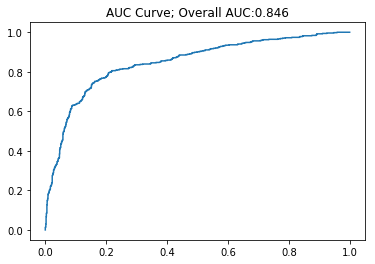

In [116]:
fpr, tpr, _ = roc_curve(y,  oof)
auc = roc_auc_score(y, oof)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.title("AUC Curve; Overall AUC:{}".format(round(auc,3)))

In [140]:
predsAUCOptimized = generateThresholdPreds(NPS_te,preds,bstroc_auc_scoreThresh)
predsRecallOptimized = generateThresholdPreds(NPS_te,preds,bstThreshRec)
predsPrecisionOptimized = generateThresholdPreds(NPS_te,preds,bstThreshPrec)
predsF1Optimized = generateThresholdPreds(NPS_te,preds,bstf1thresh)

C:\Users\EIAJRTW\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [144]:
predsF1Optimized.to_csv(r'C:\Users\EIAJRTW\OneDrive - Ericsson AB\Err Hackathon\Prob-7 NPS & KPI Correlation\F1Optimized_Predictions.csv',index=False)

In [ ]:
### End ###